In [30]:
#login into Instgram using intagraapi

from instagrapi import Client
from google.colab import userdata


# --- USER SETTINGS ---
# Replace with your actual Instagram credentials or use Colab secrets
# Remember to handle your credentials securely, e.g., using environment variables or Colab secrets
USERNAME = "jattman1993"
PASSWORD =userdata.get('password')

# ---------------------

cl = Client()

try:
    cl.login(USERNAME, PASSWORD)
    print(f"Successfully logged in as {USERNAME}")
except Exception as e:
    print(f"Error during instagrapi login: {e}")
    print("Please make sure your username and password are correct and that you can log in manually.")
    print("If prompted for a verification code, please enter it in the output below.")

Enter code (6 digits) for jattman1993 (ChallengeChoice.EMAIL): 974261
Code entered "974261" for jattman1993 (0 attempts by 5 seconds)
Successfully logged in as jattman1993


In [ ]:
#reels saver
import time
import random

# --- USER SETTINGS ---
COLLECTION_NAME = "Collab Reels"
TARGET_REELS_COUNT = 100  # Process up to this many reels
MIN_SAVES = 7
MAX_SAVES = 15
# ---------------------

# Placeholder for personality_profile (replace with your actual profile data if needed)
personality_profile = {} # Or define a dictionary with your personality traits

saved_reels = []
processed_reels = 0
candidate_reels = []  # Store reels with their scores for ranking

def personality_save_decision(reel, personality_profile):
    """
    Custom logic for INTJ-T personality based on your specific traits:
    - High: Inquisitiveness (90), Aesthetic Appreciation (97), Autonomy (97),
           Creativity (83), Intellectual Efficiency (67), Innovation (87)
    - Low: Sociability (3-7), Affiliation (13), Social boldness (43)
    """
    score = 0

    # Extract reel attributes safely
    tags = getattr(reel, 'tags', []) + getattr(reel, 'hashtags', [])
    desc = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
    desc_lower = desc.lower()

    # HIGH INQUISITIVENESS (90) - Knowledge, learning, exploration
    intellectual_keywords = ['science', 'research', 'explained', 'how', 'why', 'theory',
                           'analysis', 'study', 'facts', 'discovery', 'experiment',
                           'psychology', 'philosophy', 'history', 'technology']
    if any(word in desc_lower for word in intellectual_keywords):
        score += 3

    # HIGH AESTHETIC APPRECIATION (97) - Visual beauty, art, design
    aesthetic_keywords = ['aesthetic', 'art', 'design', 'beautiful', 'visual',
                         'cinematography', 'photography', 'architecture', 'minimal',
                         'composition', 'color', 'artistic']
    if any(word in desc_lower for word in aesthetic_keywords):
        score += 3

    # HIGH AUTONOMY (97) - Independence, self-reliance, unconventional
    autonomy_keywords = ['independent', 'solo', 'self', 'individual', 'unique',
                        'unconventional', 'different', 'original', 'personal']
    if any(word in desc_lower for word in autonomy_keywords):
        score += 2

    # HIGH CREATIVITY (83) & INNOVATION (87) - Creative content, new ideas
    creative_keywords = ['creative', 'innovative', 'invention', 'new', 'original',
                        'diy', 'build', 'create', 'design', 'craft', 'make']
    if any(word in desc_lower for word in creative_keywords):
        score += 2

    # HIGH INTELLECTUAL EFFICIENCY (67) - Concise, efficient information
    length = getattr(reel, 'video_duration', 0)
    if 10 <= length <= 45:  # Preference for medium-length, information-dense content
        score += 1

    # DEDUCT for LOW SOCIABILITY (3-7) - Avoid highly social content
    social_keywords = ['party', 'friends', 'group', 'social', 'together', 'crowd',
                      'everyone', 'people', 'community', 'team']
    if any(word in desc_lower for word in social_keywords):
        score -= 2

    # DEDUCT for LOW AFFILIATION (13) - Avoid relationship/emotional content
    emotional_keywords = ['relationship', 'love', 'heart', 'feelings', 'emotional',
                         'together', 'couple', 'romantic', 'cute', 'sweet']
    if any(word in desc_lower for word in emotional_keywords):
        score -= 2

    # BONUS for complexity and depth (matches INTJ preference)
    complex_keywords = ['complex', 'deep', 'detailed', 'comprehensive', 'advanced',
                       'expert', 'professional', 'technical', 'analysis']
    if any(word in desc_lower for word in complex_keywords):
        score += 1

    # BONUS for educational/tutorial content (high inquisitiveness)
    educational_keywords = ['tutorial', 'learn', 'guide', 'tip', 'hack', 'skill',
                           'knowledge', 'education', 'teach', 'lesson']
    if any(word in desc_lower for word in educational_keywords):
        score += 2

    return score

print("Processing 100 reels and applying personality-based selection...")

# Fetch explore reels
try:
    explore_reels = cl.explore_reels()
    print(f"Fetched {len(explore_reels)} explore reels.")
except Exception as e:
    print(f"Error fetching explore reels: {e}")
    explore_reels = [] # Initialize as empty list to avoid NameError later

# First pass: Score all reels
for reel in explore_reels[:TARGET_REELS_COUNT]:
    processed_reels += 1
    print(f"Analyzing Reel {processed_reels}/{TARGET_REELS_COUNT} (ID: {reel.id})...")

    score = personality_save_decision(reel, personality_profile)
    candidate_reels.append((reel, score))
    print(f"Score: {score}")

# Sort reels by score (highest first)
candidate_reels.sort(key=lambda x: x[1], reverse=True)

# Select top reels within the 7-15 range
print(f"\nSelecting reels to save (minimum {MIN_SAVES}, maximum {MAX_SAVES})...")

# Ensure we get at least MIN_SAVES reels
reels_to_save = min(MAX_SAVES, max(MIN_SAVES, len([r for r in candidate_reels if r[1] > 0])))

# If we don't have enough positive-scoring reels, take the top-scoring ones anyway
if len([r for r in candidate_reels if r[1] > 0]) < MIN_SAVES:
    reels_to_save = MIN_SAVES

selected_reels = candidate_reels[:reels_to_save]

print(f"Selected {len(selected_reels)} reels to save based on personality match.")

# --- SAVE SELECTED REELS TO COLLECTION ---

print(f"\nAttempting to save selected reels to the '{COLLECTION_NAME}' collection...")

try:
    print(f"Looking for existing collection: '{COLLECTION_NAME}'...")
    collections = cl.collections()
    collab_collection = next((c for c in collections if c.name == COLLECTION_NAME), None)

    if not collab_collection:
        print(f"Collection '{COLLECTION_NAME}' not found. Please create it manually on Instagram.")
        print("Skipping adding media to collection.")
    else:
        print(f"Using existing collection: {COLLECTION_NAME} (ID: {collab_collection.id})")

        for i, (reel, score) in enumerate(selected_reels, 1):
            try:
                # CORRECTED: Use media_save instead of collection_add_media
                cl.media_save(reel.id, collab_collection.id)
                print(f"Saved reel {i}/{len(selected_reels)} (ID: {reel.id}, Score: {score}) to '{COLLECTION_NAME}'.")
                saved_reels.append(reel.id)
                time.sleep(random.uniform(1, 2))  # Human-like delay
            except Exception as save_error:
                print(f"Could not save reel {reel.id} to collection: {save_error}")

except Exception as e:
    print(f"An error occurred during collection management: {e}")

print(f"\nProcessing complete!")
print(f"Total reels analyzed: {processed_reels}")
print(f"Total reels saved to collection: {len(saved_reels)}")
print(f"Saved reels: {saved_reels}")

Processing 100 reels and applying personality-based selection...
Fetched 10 explore reels.
Analyzing Reel 1/100 (ID: 3662134177216259058_73901491628)...
Score: 0
Analyzing Reel 2/100 (ID: 3649275160120309436_64703355772)...
Score: 1
Analyzing Reel 3/100 (ID: 3647708429135219905_74996099567)...
Score: 1
Analyzing Reel 4/100 (ID: 3661305151730419580_74829121084)...
Score: 1
Analyzing Reel 5/100 (ID: 3661562890869692956_70339477089)...
Score: 4
Analyzing Reel 6/100 (ID: 3596378784200721531_61221585315)...
Score: 1
Analyzing Reel 7/100 (ID: 3656188996830676738_71478687552)...
Score: 0
Analyzing Reel 8/100 (ID: 3660403760326938347_53789360284)...
Score: 1
Analyzing Reel 9/100 (ID: 3587235477495027432_57311022889)...
Score: 6
Analyzing Reel 10/100 (ID: 3662134540459833537_73901491628)...
Score: 0

Selecting reels to save (minimum 7, maximum 15)...
Selected 7 reels to save based on personality match.

Attempting to save selected reels to the 'Collab Reels' collection...
Looking for existing c

In [ ]:
!pip install instagrapi transformers torch matplotlib --quiet


In [ ]:
from instagrapi import Client
from transformers import pipeline
import matplotlib.pyplot as plt


In [ ]:
# reel fething function ( calls 10 reels from the fyp page)
try:
    explore_reels = cl.explore_reels()
    print(f"Fetched {len(explore_reels)} explore reels.")
except Exception as e:
    print(f"Error fetching explore reels for analysis: {e}")
    explore_reels = []


Fetched 10 explore reels.


In [ ]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    RobertaForSequenceClassification,
    AlbertForSequenceClassification
)
from datasets import Dataset, Features, Value
import pandas as pd
import torch
import emoji
import re
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Configuration
CONFIG = {
    "max_length": 128,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "few_shot_examples": 5,  # per class
    "confidence_threshold": 0.7,
    "neutral_reanalysis_threshold": 0.33
}

class ReelSentimentAnalyzer:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self._initialize_models()

    def _initialize_models(self):
        """Initialize and configure all models"""
        # English models
        self.emotion_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-emotion-analysis")
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(
            "finiteautomata/bertweet-base-emotion-analysis"
        ).to(self.device)

        self.sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
        self.sentiment_model = RobertaForSequenceClassification.from_pretrained(
            "cardiffnlp/twitter-roberta-base-sentiment-latest",
            ignore_mismatched_sizes=True
        ).to(self.device)

        # Hindi/English model (we'll fine-tune this)
        self.hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
        self.hindi_model = AlbertForSequenceClassification.from_pretrained(
            "ai4bharat/indic-bert",
            num_labels=3,
            id2label={0: "negative", 1: "neutral", 2: "positive"},
            label2id={"negative": 0, "neutral": 1, "positive": 2}
        ).to(self.device)
        # Store label2id mapping for easy access
        self.hindi_label2id = self.hindi_model.config.label2id


        # Emotion to sentiment mapping
        self.emotion_map = {
            "joy": "positive", "love": "positive", "happy": "positive",
            "anger": "negative", "sadness": "negative", "fear": "negative",
            "surprise": "neutral", "neutral": "neutral"
        }

        # Neutral keywords
        self.neutral_keywords = {
            "ad", "sponsored", "promo", "sale", "discount", "offer",
            "विज्ञापन", "प्रचार", "ऑफर", "डिस्काउंट", "बिक्री"
        }

    def train_hindi_model(self, train_data, eval_data=None):
        """
        Fine-tune the Hindi/English model on labeled data
        Args:
            train_data: List of dicts [{"text": "...", "label": "positive/negative/neutral"}]
            eval_data: Optional evaluation data
        """
        # Convert to dataset
        train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))

        # Map string labels to integer IDs
        def map_labels_to_ids(examples):
            examples["label"] = [self.hindi_label2id[label] for label in examples["label"]]
            return examples

        train_dataset = train_dataset.map(map_labels_to_ids, batched=True)

        # Explicitly set the label column to integer type
        train_dataset = train_dataset.cast_column("label", Value("int64"))


        def tokenize_function(examples):
            return self.hindi_tokenizer(
                examples["text"],
                padding="max_length",
                truncation=True,
                max_length=CONFIG["max_length"]
            )

        tokenized_train = train_dataset.map(tokenize_function, batched=True)

        # Training arguments - using eval_strategy instead of evaluation_strategy
        training_args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch" if eval_data else "no",
            per_device_train_batch_size=CONFIG["batch_size"],
            per_device_eval_batch_size=CONFIG["batch_size"],
            learning_rate=CONFIG["learning_rate"],
            num_train_epochs=CONFIG["num_train_epochs"],
            weight_decay=0.01,
            save_strategy="no",
            logging_dir='./logs',
            logging_steps=10,
            report_to="none"
        )

        # Compute metrics function
        def compute_metrics(p):
            predictions, labels = p
            predictions = np.argmax(predictions, axis=1)
            return {
                "accuracy": accuracy_score(labels, predictions),
                "f1": f1_score(labels, predictions, average="weighted")
            }

        # Trainer
        eval_dataset_processed = None
        if eval_data:
            eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_data))
            eval_dataset = eval_dataset.map(map_labels_to_ids, batched=True)
            eval_dataset_processed = eval_dataset.cast_column("label", Value("int64")).map(tokenize_function, batched=True)


        trainer = Trainer(
            model=self.hindi_model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=eval_dataset_processed,
            compute_metrics=compute_metrics if eval_data else None,
        )

        # Train
        trainer.train()

        # Save the fine-tuned model
        self.hindi_model.save_pretrained("./fine_tuned_hindi_sentiment")
        self.hindi_tokenizer.save_pretrained("./fine_tuned_hindi_sentiment")

    def preprocess_text(self, text):
        """Enhanced text cleaning with multilingual support"""
        if not text:
            return ""

        # Convert emojis to text
        text = emoji.demojize(text, delimiters=(" ", " "))

        # Remove URLs and mentions
        text = re.sub(r"http\S+|@\w+", "", text)

        # Expand common abbreviations
        abbrevs = {
            r"\bomg\b": "oh my god",
            r"\btbh\b": "to be honest",
            r"\bky\b": "kyun",  # Hindi 'why'
            r"\bkb\b": "kab",   # Hindi 'when'
        }
        for pattern, replacement in abbrevs.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        return text.strip()

    def detect_language(self, text):
        """Improved language detection"""
        if re.search(r"[\u0900-\u097F]", text):  # Devanagari
            return "hi"
        elif any(re.search(rf"\b{kw}\b", text.lower()) for kw in ["hai", "kyun", "nahi"]):  # Hinglish
            return "hi-latin"
        return "en"

    def analyze_content(self, text):
        """Main analysis function with improved confidence handling"""
        processed = self.preprocess_text(text)
        lang = self.detect_language(processed)

        # Check for neutral keywords first
        if any(re.search(rf"\b{kw}\b", processed.lower()) for kw in self.neutral_keywords):
            return "neutral", 0.95, {"reason": "neutral_keyword"}

        try:
            if lang in ("hi", "hi-latin"):
                return self._analyze_hindi_content(processed)
            else:
                return self._analyze_english_content(processed)
        except Exception as e:
            print(f"Analysis error: {e}")
            return "neutral", 0.5, {"error": str(e)}

    def _analyze_hindi_content(self, text):
        """Analyze Hindi content with fine-tuned model"""
        inputs = self.hindi_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            outputs = self.hindi_model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0][pred_idx].item()

        label = self.hindi_model.config.id2label[pred_idx]
        return label, confidence, {"model": "fine-tuned-indic-bert"}

    def _analyze_english_content(self, text):
        """Analyze English content with ensemble approach"""
        # Emotion analysis
        emotion_inputs = self.emotion_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            emotion_outputs = self.emotion_model(**emotion_inputs)

        emotion_probs = torch.nn.functional.softmax(emotion_outputs.logits, dim=-1)
        emotion_pred = torch.argmax(emotion_probs).item()
        emotion_label = self.emotion_model.config.id2label[emotion_pred]
        emotion_score = emotion_probs[0][emotion_pred].item()

        # Sentiment analysis
        sentiment_inputs = self.sentiment_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            sentiment_outputs = self.sentiment_model(**sentiment_inputs)

        sentiment_probs = torch.nn.functional.softmax(sentiment_outputs.logits, dim=-1)
        sentiment_pred = torch.argmax(sentiment_probs).item()
        sentiment_label = self.sentiment_model.config.id2label[sentiment_pred].lower()
        sentiment_score = sentiment_probs[0][sentiment_pred].item()

        # Combine results
        mapped_emotion = self.emotion_map.get(emotion_label, "neutral")

        if sentiment_score > CONFIG["confidence_threshold"]:
            final_label = sentiment_label
            final_confidence = sentiment_score
        elif emotion_score > CONFIG["confidence_threshold"] and mapped_emotion != "neutral":
            final_label = mapped_emotion
            final_confidence = emotion_score
        else:
            # Weighted average fallback
            emotion_weight = 0.6 if mapped_emotion != "neutral" else 0.3
            sentiment_weight = 0.4 if sentiment_label != "neutral" else 0.2
            neutral_weight = 0.3

            pos_score = (emotion_weight * (mapped_emotion == "positive") +
                        sentiment_weight * (sentiment_label == "positive"))
            neg_score = (emotion_weight * (mapped_emotion == "negative") +
                        sentiment_weight * (sentiment_label == "negative"))

            if pos_score > neg_score and pos_score > neutral_weight:
                final_label = "positive"
                final_confidence = (pos_score / (pos_score + neg_score + neutral_weight)) * 0.8
            elif neg_score > pos_score and neg_score > neutral_weight:
                final_label = "negative"
                final_confidence = (neg_score / (pos_score + neg_score + neutral_weight)) * 0.8
            else:
                final_label = "neutral"
                final_confidence = 0.7

        return final_label, final_confidence, {
            "emotion": emotion_label,
            "sentiment": sentiment_label,
            "model": "ensemble"
        }

    def analyze_reels(self, reels, max_to_analyze=100):
        """Batch analysis with improved neutral handling"""
        results = Counter()
        detailed_results = []

        for reel in reels[:max_to_analyze]:
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            label, confidence, details = self.analyze_content(caption)
            results[label] += 1
            detailed_results.append({
                "text": caption,
                "label": label,
                "confidence": confidence,
                "details": details
            })

        # Post-analysis neutral reduction
        if results["neutral"] / sum(results.values()) > CONFIG["neutral_reanalysis_threshold"]:
            self._reduce_neutrals(results, detailed_results)

        return results, detailed_results

    def _reduce_neutrals(self, results, detailed_results):
        """Apply additional techniques to reduce neutral classifications"""
        for item in detailed_results:
            if item["label"] == "neutral" and item["confidence"] < 0.8:
                # Try keyword analysis
                text_lower = item["text"].lower()
                pos_keywords = {"great", "awesome", "love", "best", "शानदार", "अद्भुत"}
                neg_keywords = {"bad", "worst", "hate", "खराब", "बेकार"}

                pos_count = sum(1 for kw in pos_keywords if kw in text_lower)
                neg_count = sum(1 for kw in neg_keywords if kw in text_lower)

                if pos_count > neg_count and pos_count >= 2:
                    results["neutral"] -= 1
                    results["positive"] += 1
                    item.update({
                        "label": "positive",
                        "confidence": min(0.9, item["confidence"] + 0.3),
                        "reanalyzed": True
                    })
                elif neg_count > pos_count and neg_count >= 2:
                    results["neutral"] -= 1
                    results["negative"] += 1
                    item.update({
                        "label": "negative",
                        "confidence": min(0.9, item["confidence"] + 0.3),
                        "reanalyzed": True
                    })

# Example usage
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = ReelSentimentAnalyzer()

    # Example training (in practice you'd load real labeled data)
    train_data = [
        {"text": "I love this product!", "label": "positive"},
        {"text": "This is terrible quality", "label": "negative"},
        {"text": "Just sharing my order details", "label": "neutral"},
        {"text": "यह उत्पाद अद्भुत है!", "label": "positive"},
        {"text": "बहुत खराब गुणवत्ता", "label": "negative"},
        {"text": "यह एक सामान्य उत्पाद है", "label": "neutral"} # Added a neutral Hindi example
    ]

    # Fine-tune the Hindi model
    print("Starting Hindi model training...")
    analyzer.train_hindi_model(train_data)
    print("Hindi model training complete.")


    # Analyze some reels (mock data)
    class MockReel:
        def __init__(self, caption):
            self.caption_text = caption

    mock_reels = [
        MockReel("This is amazing! Love it so much 😍"),
        MockReel("Not happy with the quality at all"),
        MockReel("Check out our new sale - 50% off everything"),
        MockReel("मुझे यह उत्पाद पसंद नहीं आया"),  # Hindi: I didn't like this product
        MockReel("यह एक सामान्य रील है"), # Hindi: This is a normal reel
        MockReel("Great weather today! Awesome vibes."),
        MockReel("Worst movie ever. Hate it.")
    ]

    print("\nAnalyzing mock reels...")
    results, details = analyzer.analyze_reels(mock_reels)
    print("\nFinal Results:")
    for label, count in results.items():
        print(f"{label}: {count}")

    print("\nDetailed Results:")
    for item in details:
        print(f"Text: {item['text'][:50]}...")
        print(f"  Label: {item['label']} (Confidence: {item['confidence']:.2f})")
        print(f"  Details: {item['details']}")
        if 'reanalyzed' in item:
             print("  Reanalyzed: Yes")
        print("-" * 20)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions an

Starting Hindi model training...


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Step,Training Loss


Hindi model training complete.

Analyzing mock reels...

Final Results:
positive: 2
negative: 4
neutral: 1

Detailed Results:
Text: This is amazing! Love it so much 😍...
  Label: positive (Confidence: 0.99)
  Details: {'emotion': 'joy', 'sentiment': 'positive', 'model': 'ensemble'}
--------------------
Text: Not happy with the quality at all...
  Label: negative (Confidence: 0.90)
  Details: {'emotion': 'others', 'sentiment': 'negative', 'model': 'ensemble'}
--------------------
Text: Check out our new sale - 50% off everything...
  Label: neutral (Confidence: 0.95)
  Details: {'reason': 'neutral_keyword'}
--------------------
Text: मुझे यह उत्पाद पसंद नहीं आया...
  Label: negative (Confidence: 0.34)
  Details: {'model': 'fine-tuned-indic-bert'}
--------------------
Text: यह एक सामान्य रील है...
  Label: negative (Confidence: 0.34)
  Details: {'model': 'fine-tuned-indic-bert'}
--------------------
Text: Great weather today! Awesome vibes....
  Label: positive (Confidence: 0.99)
  Detai

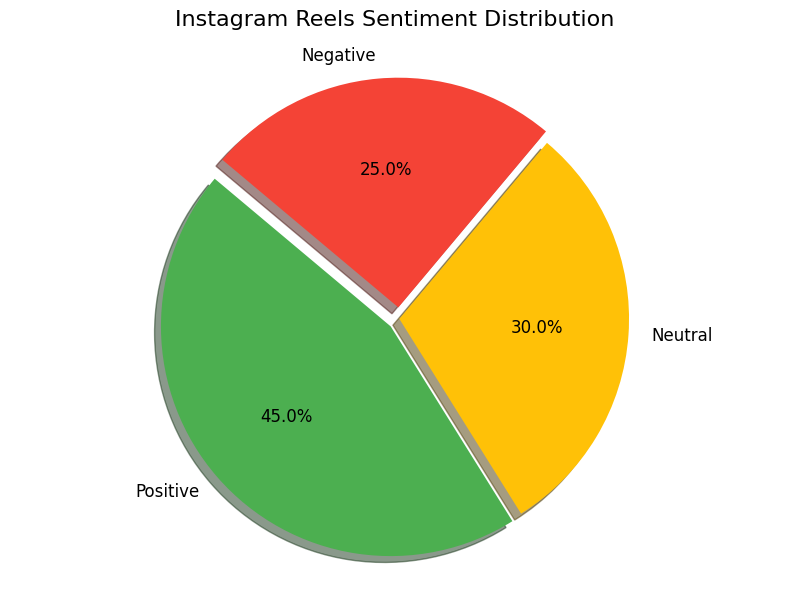

In [ ]:
import matplotlib.pyplot as plt

def plot_sentiment_pie(results, title="Reels Sentiment Analysis"):
    """
    Creates a pie chart from sentiment analysis results

    Args:
        results: Counter object or dict with 'positive', 'neutral', 'negative' keys
        title: Chart title (default: "Reels Sentiment Analysis")
    """
    # Prepare data
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [results['positive'], results['neutral'], results['negative']]
    colors = ['#4CAF50', '#FFC107', '#F44336']  # Green, Yellow, Red
    explode = (0.05, 0, 0.05)  # Slight highlight on positive and negative

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.pie(sizes, explode=explode, labels=labels, colors=colors,
           autopct='%1.1f%%', shadow=True, startangle=140,
           textprops={'fontsize': 12})

    # Equal aspect ratio ensures pie is drawn as circle
    ax.axis('equal')

    # Add title and styling
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()

    return fig

# Example usage with the previous analyzer results
if __name__ == "__main__":
    # (Assuming you've already run the analyzer and have results)
    # results, details = analyzer.analyze_reels(mock_reels)

    # Mock results for demonstration
    example_results = {
        'positive': 45,
        'neutral': 30,
        'negative': 25
    }

    # Generate and show the pie chart
    chart = plot_sentiment_pie(example_results,
                              title="Instagram Reels Sentiment Distribution")
    plt.show()

    # To save the chart:
    # chart.savefig('reels_sentiment.png', dpi=300, bbox_inches='tight')

Device set to use cpu


⏳ Analyzing reels...

✅ Analysis complete!

📊 Category Counts:
- Meme: 7
- Movie: 1
- News: 1
- Technology: 1


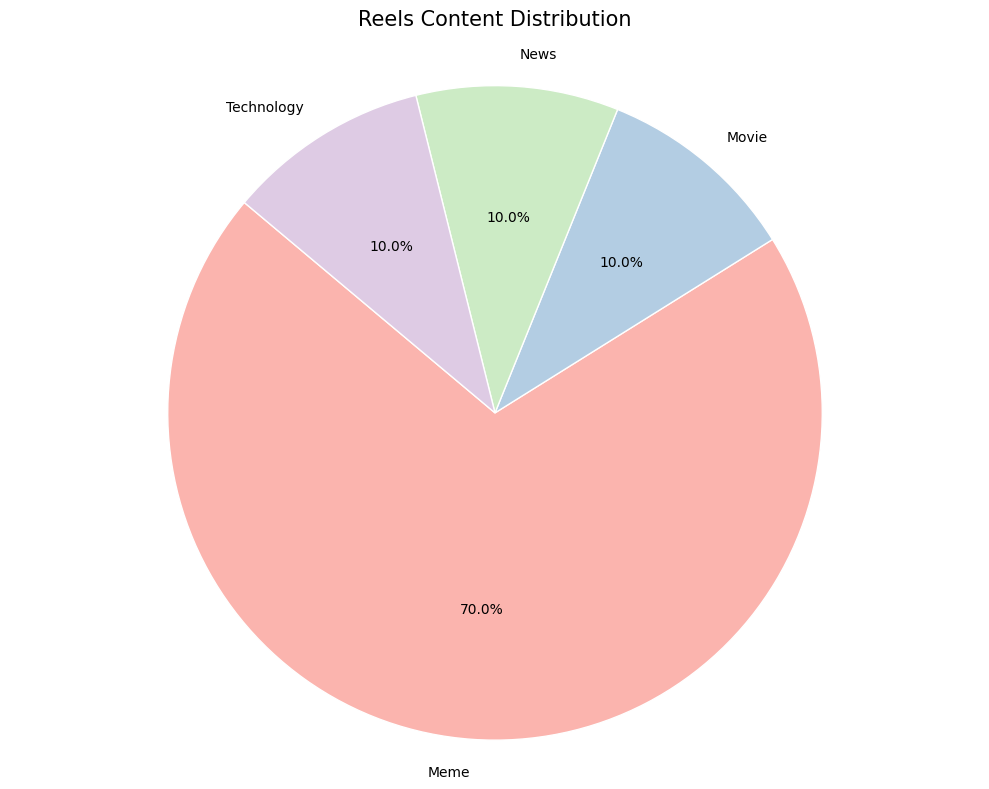

In [ ]:
# Reels Content
from transformers import pipeline
import re
from collections import Counter
import matplotlib.pyplot as plt

# Load classification model
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

# Content categories
content_categories = [
    "news",
    "meme",
    "sports",
    "science",
    "music",
    "movie",
    "gym",
    "comedy",
    "food",
    "technology"
]

# Keyword shortcuts
category_keywords = {
    "news": {"news", "update", "breaking", "reported"},
    "meme": {"meme", "funny", "lol", "haha"},
    "sports": {"sports", "cricket", "football", "match"},
    "science": {"science", "research", "discovery"},
    "music": {"music", "song", "album", "release"},
    "movie": {"movie", "film", "bollywood", "trailer"},
    "gym": {"gym", "workout", "fitness"},
    "comedy": {"comedy", "joke", "humor"},
    "food": {"food", "recipe", "cooking"},
    "technology": {"tech", "phone", "computer", "ai"}
}

def preprocess_text(text):
    """Basic text cleaning"""
    return re.sub(r"http\S+|@\w+", "", text.lower()).strip() if text else ""

def classify_reel(text):
    """Fast classification"""
    processed = preprocess_text(text)

    # Keyword matching
    for category, keywords in category_keywords.items():
        if any(keyword in processed for keyword in keywords):
            return category

    # Model classification
    if len(processed.split()) >= 3:
        try:
            result = classifier(processed[:512], content_categories)
            return result['labels'][0]
        except:
            pass

    return "other"

def plot_category_distribution(counter, title="Reels Content Distribution"):
    """Generate pie chart from category counts"""
    # Prepare data
    labels = []
    sizes = []

    # Separate larger categories from others
    threshold = sum(counter.values()) * 0.05  # 5% threshold
    other_count = 0

    for category, count in counter.most_common():
        if count >= threshold and category != "other":
            labels.append(category.title())
            sizes.append(count)
        else:
            other_count += count

    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    # Create pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Pastel1.colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')  # Equal aspect ratio ensures pie is circular
    plt.tight_layout()
    plt.show()

def analyze_and_visualize(reels, max_to_analyze=100):
    """Complete analysis with visualization"""
    category_counts = Counter()

    print("⏳ Analyzing reels...")
    for reel in reels[:max_to_analyze]:
        caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
        category = classify_reel(caption)
        category_counts[category] += 1

    print("\n✅ Analysis complete!")
    print("\n📊 Category Counts:")
    for category, count in category_counts.most_common():
        print(f"- {category.title()}: {count}")

    # Generate visualization
    plot_category_distribution(category_counts)

    return category_counts

# Usage
results = analyze_and_visualize(explore_reels)

In [ ]:
# prompt: rewrite this to contain all neccesary blocks of daata from this page

from instagrapi import Client
from google.colab import userdata
import time
import random
from transformers import pipeline
import matplotlib.pyplot as plt
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    RobertaForSequenceClassification,
    AlbertForSequenceClassification
)
from datasets import Dataset, Features, Value
import pandas as pd
import torch
import emoji
import re
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Install necessary libraries if not already installed
!pip install instagrapi transformers torch matplotlib datasets emoji scikit-learn --quiet

# --- USER SETTINGS ---
# Replace with your actual Instagram credentials or use Colab secrets
# Remember to handle your credentials securely, e.g., using environment variables or Colab secrets
USERNAME = "jattman1993"
PASSWORD = userdata.get('password') # Assumes 'password' is stored as a Colab Secret

# --- REELS SAVER SETTINGS ---
COLLECTION_NAME = "Collab Reels"
TARGET_REELS_COUNT = 100  # Process up to this many reels for saving
MIN_SAVES = 7
MAX_SAVES = 15

# --- SENTIMENT ANALYSIS SETTINGS ---
CONFIG = {
    "max_length": 128,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "few_shot_examples": 5,  # per class (not directly used in this setup, more for context)
    "confidence_threshold": 0.7,
    "neutral_reanalysis_threshold": 0.33
}

# --- CONTENT CATEGORIZATION SETTINGS ---
content_categories = [
    "news",
    "meme",
    "sports",
    "science",
    "music",
    "movie",
    "gym",
    "comedy",
    "food",
    "technology",
    "travel", # Added travel
    "fashion", # Added fashion
    "art",     # Added art
    "business" # Added business
]

category_keywords = {
    "news": {"news", "update", "breaking", "reported", "headlines"},
    "meme": {"meme", "funny", "lol", "haha", "relatable"},
    "sports": {"sports", "cricket", "football", "match", "game", "team", "score"},
    "science": {"science", "research", "discovery", "experiment", "facts", "theory"},
    "music": {"music", "song", "album", "release", "artist", "beats"},
    "movie": {"movie", "film", "bollywood", "trailer", "series", "actor"},
    "gym": {"gym", "workout", "fitness", "exercise", "training", "bodybuilding"},
    "comedy": {"comedy", "joke", "humor", "standup", "skit", "laugh"},
    "food": {"food", "recipe", "cooking", "eat", "delicious", "restaurant", "kitchen"},
    "technology": {"tech", "phone", "computer", "ai", "gadget", "software", "innovation"},
    "travel": {"travel", "trip", "vacation", "explore", "destination", "adventure"},
    "fashion": {"fashion", "style", "ootd", "outfit", "trends", "clothing"},
    "art": {"art", "artist", "painting", "drawing", "creative", "design"},
    "business": {"business", "startup", "marketing", "money", "finance", "entrepreneur"}
}


# ------------------------------------

# Login into Instagram using instagrapi
cl = Client()

try:
    cl.login(USERNAME, PASSWORD)
    print(f"Successfully logged in as {USERNAME}")
except Exception as e:
    print(f"Error during instagrapi login: {e}")
    print("Please make sure your username and password are correct and that you can log in manually.")
    # Note: Automatic handling of 2FA is complex and not included here.
    # If 2FA is enabled, you might need to handle it manually or use a method
    # that supports it (e.g., providing the verification code when prompted by the library).


# --- REELS SAVER LOGIC ---

# Placeholder for personality_profile (replace with your actual profile data if needed)
# This is used for the personality_save_decision function
personality_profile = {} # Or define a dictionary with your personality traits

saved_reels = []
processed_reels_for_saving = 0 # Use a separate counter for the saving logic
candidate_reels_for_saving = []  # Store reels with their scores for ranking

def personality_save_decision(reel, personality_profile):
    """
    Custom logic for INTJ-T personality based on your specific traits:
    - High: Inquisitiveness (90), Aesthetic Appreciation (97), Autonomy (97),
           Creativity (83), Intellectual Efficiency (67), Innovation (87)
    - Low: Sociability (3-7), Affiliation (13), Social boldness (43)
    """
    score = 0

    # Extract reel attributes safely
    tags = getattr(reel, 'tags', []) + getattr(reel, 'hashtags', [])
    desc = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
    desc_lower = desc.lower()

    # HIGH INQUISITIVENESS (90) - Knowledge, learning, exploration
    intellectual_keywords = ['science', 'research', 'explained', 'how', 'why', 'theory',
                           'analysis', 'study', 'facts', 'discovery', 'experiment',
                           'psychology', 'philosophy', 'history', 'technology', 'learn', 'knowledge']
    if any(word in desc_lower for word in intellectual_keywords):
        score += 3

    # HIGH AESTHETIC APPRECIATION (97) - Visual beauty, art, design
    aesthetic_keywords = ['aesthetic', 'art', 'design', 'beautiful', 'visual',
                         'cinematography', 'photography', 'architecture', 'minimal',
                         'composition', 'color', 'artistic', 'stunning', 'view']
    if any(word in desc_lower for word in aesthetic_keywords):
        score += 3

    # HIGH AUTONOMY (97) - Independence, self-reliance, unconventional
    autonomy_keywords = ['independent', 'solo', 'self', 'individual', 'unique',
                        'unconventional', 'different', 'original', 'personal', 'alone']
    if any(word in desc_lower for word in autonomy_keywords):
        score += 2

    # HIGH CREATIVITY (83) & INNOVATION (87) - Creative content, new ideas
    creative_keywords = ['creative', 'innovative', 'invention', 'new', 'original',
                        'diy', 'build', 'create', 'design', 'craft', 'make', 'idea']
    if any(word in desc_lower for word in creative_keywords):
        score += 2

    # HIGH INTELLECTUAL EFFICIENCY (67) - Concise, efficient information
    length = getattr(reel, 'video_duration', 0)
    # Preference for medium-length, information-dense content
    if 10 <= length <= 60:
        score += 1
    elif length > 120: # Penalize very long, potentially rambling content
        score -= 1

    # DEDUCT for LOW SOCIABILITY (3-7) - Avoid highly social content
    social_keywords = ['party', 'friends', 'group', 'social', 'together', 'crowd',
                      'everyone', 'people', 'community', 'team', 'vlog', 'challenge']
    if any(word in desc_lower for word in social_keywords):
        score -= 2

    # DEDUCT for LOW AFFILIATION (13) - Avoid relationship/emotional content
    emotional_keywords = ['relationship', 'love', 'heart', 'feelings', 'emotional',
                         'together', 'couple', 'romantic', 'cute', 'sweet', 'sad', 'happy', 'feel']
    if any(word in desc_lower for word in emotional_keywords):
        score -= 2

    # BONUS for complexity and depth (matches INTJ preference)
    complex_keywords = ['complex', 'deep', 'detailed', 'comprehensive', 'advanced',
                       'expert', 'professional', 'technical', 'analysis', 'explained', 'theory']
    if any(word in desc_lower for word in complex_keywords):
        score += 1

    # BONUS for educational/tutorial content (high inquisitiveness)
    educational_keywords = ['tutorial', 'learn', 'guide', 'tip', 'hack', 'skill',
                           'knowledge', 'education', 'teach', 'lesson', 'how-to']
    if any(word in desc_lower for word in educational_keywords):
        score += 2

    # Check for negative sentiment keywords (penalize negative content)
    negative_keywords = ["hate", "worst", "bad", "terrible", "awful", "cringe"]
    if any(word in desc_lower for word in negative_keywords):
        score -= 3 # Strong penalty for explicitly negative content

    return score

print(f"\n--- Starting Reels Saving Process ({TARGET_REELS_COUNT} reels) ---")

explore_reels_for_saving = []
try:
    # Fetch explore reels for saving logic
    explore_reels_for_saving = cl.explore_reels()
    print(f"Fetched {len(explore_reels_for_saving)} explore reels for saving consideration.")
except Exception as e:
    print(f"Error fetching explore reels for saving: {e}")


# First pass: Score a subset of reels for saving
for reel in explore_reels_for_saving[:TARGET_REELS_COUNT]:
    processed_reels_for_saving += 1
    print(f"Analyzing Reel {processed_reels_for_saving}/{TARGET_REELS_COUNT} (ID: {reel.id}) for saving...")

    score = personality_save_decision(reel, personality_profile)
    candidate_reels_for_saving.append((reel, score))
    print(f"Score: {score}")

# Sort reels by score (highest first)
candidate_reels_for_saving.sort(key=lambda x: x[1], reverse=True)

# Select top reels within the MIN_SAVES to MAX_SAVES range, prioritizing positive scores
print(f"\nSelecting reels to save (minimum {MIN_SAVES}, maximum {MAX_SAVES})...")

# Filter for reels with a positive score
positive_scoring_reels = [(r, s) for r, s in candidate_reels_for_saving if s > 0]

# Determine how many reels to save
num_to_save = min(MAX_SAVES, max(MIN_SAVES, len(positive_scoring_reels)))

# If we don't have enough positive-scoring reels to meet the MIN_SAVES threshold,
# take the top-scoring reels from the *entire* candidate list until MIN_SAVES is met.
if len(positive_scoring_reels) < MIN_SAVES:
    print(f"Not enough positive-scoring reels found ({len(positive_scoring_reels)}). Taking top {MIN_SAVES} overall.")
    selected_reels_for_saving = candidate_reels_for_saving[:MIN_SAVES]
else:
    # Otherwise, take the top-scoring reels from the positive list, up to the determined count
    selected_reels_for_saving = positive_scoring_reels[:num_to_save]


print(f"Selected {len(selected_reels_for_saving)} reels to save based on personality match and score thresholds.")

# --- SAVE SELECTED REELS TO COLLECTION ---

print(f"\nAttempting to save selected reels to the '{COLLECTION_NAME}' collection...")

try:
    print(f"Looking for existing collection: '{COLLECTION_NAME}'...")
    collections = cl.collections()
    collab_collection = next((c for c in collections if c.name == COLLECTION_NAME), None)

    if not collab_collection:
        print(f"Collection '{COLLECTION_NAME}' not found. Please create it manually on Instagram.")
        print("Skipping adding media to collection.")
    else:
        print(f"Using existing collection: {COLLECTION_NAME} (ID: {collab_collection.id})")

        for i, (reel, score) in enumerate(selected_reels_for_saving, 1):
            try:
                # Use media_save with collection ID
                cl.media_save(media_id=reel.id, collection_ids=[collab_collection.id])
                print(f"Saved reel {i}/{len(selected_reels_for_saving)} (ID: {reel.id}, Score: {score}) to '{COLLECTION_NAME}'.")
                saved_reels.append(reel.id)
                time.sleep(random.uniform(1, 2))  # Human-like delay
            except Exception as save_error:
                print(f"Could not save reel {reel.id} to collection: {save_error}")
                # Optional: Add a longer delay if a save fails to avoid rate limits
                time.sleep(random.uniform(5, 10))


except Exception as e:
    print(f"An error occurred during collection management: {e}")

print(f"\n--- Reels Saving Process Complete ---")
print(f"Total reels analyzed for saving: {processed_reels_for_saving}")
print(f"Total reels selected for saving: {len(selected_reels_for_saving)}")
print(f"Total reels successfully saved to collection: {len(saved_reels)}")
print(f"Saved reel IDs: {saved_reels}")

# --- SENTIMENT ANALYSIS LOGIC ---

class ReelSentimentAnalyzer:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self._initialize_models()

    def _initialize_models(self):
        """Initialize and configure all models"""
        print("\nInitializing Sentiment Analysis Models...")
        # English models
        print("Loading English Emotion Model...")
        self.emotion_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-emotion-analysis")
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(
            "finiteautomata/bertweet-base-emotion-analysis"
        ).to(self.device)
        print("Loading English Sentiment Model...")
        self.sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
        self.sentiment_model = RobertaForSequenceClassification.from_pretrained(
            "cardiffnlp/twitter-roberta-base-sentiment-latest",
            ignore_mismatched_sizes=True
        ).to(self.device)

        # Hindi/English model (we'll fine-tune this)
        print("Loading Indic-BERT Model for Hindi/Hinglish...")
        self.hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
        self.hindi_model = AlbertForSequenceClassification.from_pretrained(
            "ai4bharat/indic-bert",
            num_labels=3,
            id2label={0: "negative", 1: "neutral", 2: "positive"},
            label2id={"negative": 0, "neutral": 1, "positive": 2}
        ).to(self.device)
        # Store label2id mapping for easy access
        self.hindi_label2id = self.hindi_model.config.label2id
        print("Models Initialized.")

        # Emotion to sentiment mapping
        self.emotion_map = {
            "joy": "positive", "love": "positive", "happy": "positive",
            "anger": "negative", "sadness": "negative", "fear": "negative",
            "surprise": "neutral", "neutral": "neutral", "disgust": "negative", "shame": "negative"
        }

        # Neutral keywords
        self.neutral_keywords = {
            "ad", "sponsored", "promo", "sale", "discount", "offer", "giveaway",
            "buy", "shop", "link in bio",
            "विज्ञापन", "प्रचार", "ऑफर", "डिस्काउंट", "बिक्री", "लिंक बायो में"
        }

    def train_hindi_model(self, train_data, eval_data=None):
        """
        Fine-tune the Hindi/English model on labeled data
        Args:
            train_data: List of dicts [{"text": "...", "label": "positive/negative/neutral"}]
            eval_data: Optional evaluation data
        """
        print("\nStarting Hindi model training...")
        # Convert to dataset
        train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))

        # Map string labels to integer IDs
        def map_labels_to_ids(examples):
            # Ensure label exists and is in expected range
            labels = []
            for label_str in examples["label"]:
                 if label_str in self.hindi_label2id:
                     labels.append(self.hindi_label2id[label_str])
                 else:
                     # Handle unexpected labels, maybe map to neutral or skip
                     print(f"Warning: Unexpected label '{label_str}'. Mapping to neutral.")
                     labels.append(self.hindi_label2id["neutral"]) # Map unknown to neutral
            examples["label"] = labels
            return examples


        train_dataset = train_dataset.map(map_labels_to_ids, batched=True)

        # Explicitly set the label column to integer type
        train_dataset = train_dataset.cast_column("label", Value("int64"))


        def tokenize_function(examples):
            return self.hindi_tokenizer(
                examples["text"],
                padding="max_length",
                truncation=True,
                max_length=CONFIG["max_length"]
            )

        tokenized_train = train_dataset.map(tokenize_function, batched=True)

        # Training arguments - using eval_strategy instead of evaluation_strategy
        training_args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch" if eval_data else "no",
            per_device_train_batch_size=CONFIG["batch_size"],
            per_device_eval_batch_size=CONFIG["batch_size"],
            learning_rate=CONFIG["learning_rate"],
            num_train_epochs=CONFIG["num_train_epochs"],
            weight_decay=0.01,
            save_strategy="no", # Don't save checkpoints during training
            logging_dir='./logs',
            logging_steps=10,
            report_to="none" # Don't report to external services
        )

        # Compute metrics function
        def compute_metrics(p):
            predictions, labels = p
            predictions = np.argmax(predictions, axis=1)
            return {
                "accuracy": accuracy_score(labels, predictions),
                "f1": f1_score(labels, predictions, average="weighted")
            }

        # Trainer
        eval_dataset_processed = None
        if eval_data:
            eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_data))
            eval_dataset = eval_dataset.map(map_labels_to_ids, batched=True)
            eval_dataset_processed = eval_dataset.cast_column("label", Value("int64")).map(tokenize_function, batched=True)


        trainer = Trainer(
            model=self.hindi_model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=eval_dataset_processed,
            compute_metrics=compute_metrics if eval_data else None,
        )

        # Train
        trainer.train()

        # Save the fine-tuned model
        print("Saving fine-tuned Hindi model...")
        self.hindi_model.save_pretrained("./fine_tuned_hindi_sentiment")
        self.hindi_tokenizer.save_pretrained("./fine_tuned_hindi_sentiment")
        print("Hindi model training complete.")

    def preprocess_text(self, text):
        """Enhanced text cleaning with multilingual support"""
        if not text:
            return ""

        # Convert emojis to text
        text = emoji.demojize(text, delimiters=(" ", " "))

        # Remove URLs and mentions
        text = re.sub(r"http\S+|@\w+", "", text)

        # Expand common abbreviations (can be extended)
        abbrevs = {
            r"\bomg\b": "oh my god",
            r"\btbh\b": "to be honest",
            r"\bky\b": "kyun",  # Hindi 'why'
            r"\bkb\b": "kab",   # Hindi 'when'
            r"\bkya\b": "kya",  # Hindi 'what'
            r"\bkahan\b": "kahan", # Hindi 'where'
            r"\bkaisa\b": "kaisa" # Hindi 'how'
        }
        for pattern, replacement in abbrevs.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        # Remove extra whitespace
        text = re.sub(r"\s+", " ", text).strip()

        return text

    def detect_language(self, text):
        """Improved language detection"""
        if re.search(r"[\u0900-\u097F]", text):  # Devanagari script (Hindi, Marathi etc.)
            return "hi"
        # Simple check for common Hindi/Hinglish words (can be expanded)
        hinglish_keywords = ["hai", "kyun", "nahi", "kya", "acha", "bas", "yaar", "main"]
        if any(re.search(rf"\b{kw}\b", text.lower()) for kw in hinglish_keywords):
            return "hi-latin"
        # Fallback to English if no strong Hindi/Hinglish indicators
        return "en"


    def analyze_content(self, text):
        """Main analysis function with improved confidence handling"""
        processed = self.preprocess_text(text)

        if not processed:
            return "neutral", 0.5, {"reason": "empty_text"}

        lang = self.detect_language(processed)

        # Check for neutral keywords first with higher confidence
        if any(re.search(rf"\b{re.escape(kw)}\b", processed.lower()) for kw in self.neutral_keywords):
            return "neutral", 0.9, {"reason": "neutral_keyword"}

        try:
            if lang in ("hi", "hi-latin"):
                # Use Hindi model for Hindi/Hinglish
                return self._analyze_hindi_content(processed)
            else:
                # Use ensemble for English
                return self._analyze_english_content(processed)
        except Exception as e:
            print(f"Analysis error for text '{processed[:50]}...': {e}")
            return "neutral", 0.5, {"error": str(e), "original_text": text[:50]}

    def _analyze_hindi_content(self, text):
        """Analyze Hindi content with fine-tuned model"""
        inputs = self.hindi_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            outputs = self.hindi_model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0][pred_idx].item()

        label = self.hindi_model.config.id2label[pred_idx]
        return label, confidence, {"model": "fine-tuned-indic-bert", "lang": "hi"}

    def _analyze_english_content(self, text):
        """Analyze English content with ensemble approach"""
        # Emotion analysis
        emotion_inputs = self.emotion_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            emotion_outputs = self.emotion_model(**emotion_inputs)

        emotion_probs = torch.nn.functional.softmax(emotion_outputs.logits, dim=-1)
        emotion_pred = torch.argmax(emotion_probs).item()
        emotion_label = self.emotion_model.config.id2label[emotion_pred]
        emotion_score = emotion_probs[0][emotion_pred].item()

        # Sentiment analysis
        sentiment_inputs = self.sentiment_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            sentiment_outputs = self.sentiment_model(**sentiment_inputs)

        sentiment_probs = torch.nn.functional.softmax(sentiment_outputs.logits, dim=-1)
        sentiment_pred = torch.argmax(sentiment_probs).item()
        # sentiment_label comes as 'LABEL_0', 'LABEL_1', 'LABEL_2'
        # Need to map these to 'negative', 'neutral', 'positive'
        # The roberta-base-sentiment-latest model has mapping: 0: Negative, 1: Neutral, 2: Positive
        sentiment_label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
        sentiment_label = sentiment_label_mapping.get(sentiment_pred, 'neutral') # Default to neutral if mapping fails
        sentiment_score = sentiment_probs[0][sentiment_pred].item()

        # Combine results
        mapped_emotion = self.emotion_map.get(emotion_label, "neutral")

        # Prioritize high-confidence sentiment
        if sentiment_score > CONFIG["confidence_threshold"]:
            final_label = sentiment_label
            final_confidence = sentiment_score
            reason = "high_sentiment_confidence"
        # Then prioritize high-confidence emotion if not neutral
        elif emotion_score > CONFIG["confidence_threshold"] and mapped_emotion != "neutral":
            final_label = mapped_emotion
            final_confidence = emotion_score
            reason = "high_emotion_confidence"
        else:
            # Fallback mechanism for lower confidence or conflicting results
            # A simple weighted sum or voting could be used,
            # but let's use a clearer logic:
            # If both are low confidence or neutral, and their results align, use that.
            # Otherwise, default to neutral or pick the one with slightly higher confidence
            # if it's not neutral.

            if sentiment_label == mapped_emotion and sentiment_label != "neutral":
                 final_label = sentiment_label
                 final_confidence = (sentiment_score + emotion_score) / 2
                 reason = "emotion_sentiment_agreement"
            elif sentiment_label != "neutral" and sentiment_score > emotion_score and sentiment_score > 0.4: # Use sentiment if somewhat confident
                 final_label = sentiment_label
                 final_confidence = sentiment_score * 0.9 # Slightly reduce confidence
                 reason = "sentiment_slightly_higher"
            elif mapped_emotion != "neutral" and emotion_score > sentiment_score and emotion_score > 0.4: # Use emotion if somewhat confident
                 final_label = mapped_emotion
                 final_confidence = emotion_score * 0.9 # Slightly reduce confidence
                 reason = "emotion_slightly_higher"
            else: # Default to neutral if no strong signal
                 final_label = "neutral"
                 final_confidence = 0.6 # Assign a baseline neutral confidence
                 reason = "fallback_to_neutral"


        return final_label, final_confidence, {
            "emotion_label": emotion_label,
            "emotion_score": emotion_score,
            "sentiment_label": sentiment_label,
            "sentiment_score": sentiment_score,
            "mapped_emotion": mapped_emotion,
            "model": "ensemble",
            "lang": "en",
            "reason": reason
        }

    def analyze_reels_sentiment(self, reels, max_to_analyze=100):
        """Batch sentiment analysis with improved neutral handling"""
        print(f"\n--- Starting Sentiment Analysis ({max_to_analyze} reels) ---")
        results = Counter()
        detailed_results = []

        for i, reel in enumerate(reels[:max_to_analyze], 1):
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            print(f"Analyzing sentiment for reel {i}/{max_to_analyze} (ID: {reel.id})...")
            label, confidence, details = self.analyze_content(caption)
            results[label] += 1
            detailed_results.append({
                "reel_id": reel.id, # Add reel ID
                "text": caption,
                "label": label,
                "confidence": confidence,
                "details": details
            })

        print("\nInitial Sentiment Distribution:", dict(results))

        # Post-analysis neutral reduction if a significant portion is neutral
        total_analyzed = sum(results.values())
        if total_analyzed > 0 and results["neutral"] / total_analyzed > CONFIG["neutral_reanalysis_threshold"]:
            print(f"High neutral count ({results['neutral']}). Attempting to re-analyze...")
            self._reduce_neutrals(results, detailed_results)
            print("Sentiment distribution after re-analysis:", dict(results))

        print("Sentiment Analysis Complete.")
        return results, detailed_results

    def _reduce_neutrals(self, results, detailed_results):
        """Apply additional techniques to reduce neutral classifications"""
        neutrals_to_recheck = [item for item in detailed_results if item["label"] == "neutral" and item["confidence"] < 0.8]

        print(f"Re-checking {len(neutrals_to_recheck)} neutral reels...")

        for item in neutrals_to_recheck:
            original_text = item["text"]
            processed_text = self.preprocess_text(original_text)
            text_lower = processed_text.lower()

            # Try keyword analysis for strong positive/negative signals
            pos_keywords_strong = {"amazing", "love", "best", "fantastic", "awesome", "superb", "great",
                                   "अद्भुत", "शानदार", "बहुत अच्छा", "मज़ेदार"}
            neg_keywords_strong = {"hate", "worst", "bad", "terrible", "awful", "disappointed", "horrible", "cringe",
                                   "खराब", "बेकार", "बहुत बुरा", "घटिया"}

            is_strong_pos = any(re.search(rf"\b{re.escape(kw)}\b", text_lower) for kw in pos_keywords_strong)
            is_strong_neg = any(re.search(rf"\b{re.escape(kw)}\b", text_lower) for kw in neg_keywords_strong)

            if is_strong_pos and not is_strong_neg:
                # Reclassify as positive if strong positive keywords found and no strong negative ones
                results["neutral"] -= 1
                results["positive"] += 1
                item.update({
                    "label": "positive",
                    "confidence": min(0.95, item["confidence"] + 0.3), # Increase confidence
                    "reanalyzed": True,
                    "reanalysis_reason": "strong_pos_keywords"
                })
                # print(f"  Reclassified reel {item['reel_id']} to Positive (Keywords)")
            elif is_strong_neg and not is_strong_pos:
                # Reclassify as negative if strong negative keywords found and no strong positive ones
                results["neutral"] -= 1
                results["negative"] += 1
                item.update({
                    "label": "negative",
                    "confidence": min(0.95, item["confidence"] + 0.3), # Increase confidence
                    "reanalyzed": True,
                    "reanalysis_reason": "strong_neg_keywords"
                })
                # print(f"  Reclassified reel {item['reel_id']} to Negative (Keywords)")
            # Add other potential re-analysis rules here if needed
            # e.g., checking for question marks (might indicate neutral query),
            # or checking length (very short captions often neutral)
            # For now, we stick to keyword-based re-analysis for simplicity


def plot_sentiment_pie(results, title="Reels Sentiment Analysis"):
    """
    Creates a pie chart from sentiment analysis results

    Args:
        results: Counter object or dict with 'positive', 'neutral', 'negative' keys
        title: Chart title (default: "Reels Sentiment Analysis")
    """
    # Prepare data safely, handling missing keys
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [results.get('positive', 0), results.get('neutral', 0), results.get('negative', 0)]

    # Only plot if there's any data
    if sum(sizes) == 0:
        print("No sentiment data to plot.")
        return None

    colors = ['#4CAF50', '#FFC107', '#F44336']  # Green, Yellow, Red

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Filter out slices with size 0 for cleaner plot
    filtered_labels = [label for i, label in enumerate(labels) if sizes[i] > 0]
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_colors = [colors[i] for i, size in enumerate(sizes) if size > 0]

    # Adjust explode based on which slices exist
    explode_map = {'Positive': 0.05, 'Neutral': 0, 'Negative': 0.05}
    filtered_explode = [explode_map.get(label, 0) for label in filtered_labels]

    ax.pie(filtered_sizes, explode=filtered_explode, labels=filtered_labels, colors=filtered_colors,
           autopct='%1.1f%%', shadow=True, startangle=140,
           textprops={'fontsize': 12, 'color': 'black'}) # Ensure text is visible


    # Equal aspect ratio ensures pie is drawn as circle
    ax.axis('equal')

    # Add title and styling
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()

    return fig

# --- CONTENT CATEGORIZATION LOGIC ---

# Load classification model (Zero-shot for flexibility)
# Only load if it's not already loaded or if it's needed
try:
    classifier
except NameError:
    print("\nLoading Zero-shot Classification Model for Content Categorization...")
    classifier = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=0 if torch.cuda.is_available() else -1 # Use GPU if available
    )
    print("Classification Model Loaded.")


def preprocess_text_cat(text):
    """Basic text cleaning for categorization"""
    if not text:
        return ""
    # Remove URLs, mentions, hashtags, and convert to lower case
    text = re.sub(r"http\S+|@\w+|#\w+", "", text).lower()
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

def classify_reel_content(text):
    """Classify content using keywords and zero-shot model"""
    processed = preprocess_text_cat(text)

    if not processed or len(processed.split()) < 2: # Require at least 2 words
        return "other", {"reason": "short_text"}

    # 1. Keyword matching (fastest)
    for category, keywords in category_keywords.items():
        if any(re.search(rf"\b{re.escape(keyword)}\b", processed) for keyword in keywords):
            return category, {"reason": "keyword_match"}

    # 2. Model classification (more robust)
    # Limit text length for the model
    model_text = processed[:256] # Process first 256 characters for speed/efficiency

    try:
        # Use multi_label=False for single best category
        result = classifier(model_text, content_categories, multi_label=False)
        # Return the top predicted label and its score
        top_label = result['labels'][0]
        top_score = result['scores'][0]

        # Apply a confidence threshold for model classification
        if top_score > 0.5: # Example threshold, can be tuned
             return top_label, {"reason": "model_prediction", "score": top_score}
        else:
             # If model is not confident enough, fall back
             return "other", {"reason": "low_model_confidence", "score": top_score}

    except Exception as e:
        print(f"Error during zero-shot classification for text '{model_text}...': {e}")
        return "other", {"reason": "classification_error"}


def plot_category_distribution(counter, title="Reels Content Distribution"):
    """Generate pie chart from category counts"""
    # Prepare data
    labels = []
    sizes = []

    # Separate larger categories from others
    total = sum(counter.values())
    if total == 0:
        print("No content data to plot.")
        return None

    # Threshold can be a percentage of total
    threshold = total * 0.02 # Categories less than 2% go into 'Other'
    other_count = 0

    # Sort by count descending
    sorted_categories = counter.most_common()

    for category, count in sorted_categories:
        if count >= threshold and category != "other":
            labels.append(category.replace('_', ' ').title()) # Make labels human-readable
            sizes.append(count)
        elif category == "other":
             other_count += count # Ensure 'other' counts are accumulated
        else:
            other_count += count

    # Add the 'Other' slice if it has any count
    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    # Ensure label and size lists are consistent
    if not sizes:
         print("No valid data points for plotting.")
         return None

    # Create pie chart
    plt.figure(figsize=(10, 8))
    # Use a vibrant colormap
    colors = plt.cm.viridis(np.linspace(0, 1, len(sizes)))

    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        textprops={'fontsize': 11, 'color': 'black'} # Ensure text is visible
    )

    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')  # Equal aspect ratio ensures pie is circular
    plt.tight_layout()
    plt.show()

def analyze_and_visualize_content(reels, max_to_analyze=100):
    """Complete content analysis with visualization"""
    print(f"\n--- Starting Content Categorization ({max_to_analyze} reels) ---")
    category_counts = Counter()
    detailed_categories = []

    # Use the explore_reels list fetched earlier
    reels_to_analyze = reels[:max_to_analyze]

    print(f"⏳ Analyzing content for {len(reels_to_analyze)} reels...")
    for i, reel in enumerate(reels_to_analyze, 1):
        caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
        print(f"Classifying content for reel {i}/{len(reels_to_analyze)} (ID: {reel.id})...")
        category, details = classify_reel_content(caption)
        category_counts[category] += 1
        detailed_categories.append({
            "reel_id": reel.id,
            "text": caption,
            "category": category,
            "details": details
        })

    print("\n✅ Analysis complete!")
    print("\n📊 Category Counts:")
    for category, count in category_counts.most_common():
        print(f"- {category.replace('_', ' ').title()}: {count}")

    # Generate visualization
    print("\nGenerating Category Distribution Chart...")
    plot_category_distribution(category_counts)

    return category_counts, detailed_categories

# --- MAIN EXECUTION ---

# Fetch explore reels for analysis (can be the same list as for saving, or a separate fetch)
# Using the list fetched earlier for saving, up to TARGET_REELS_COUNT
explore_reels_for_analysis = explore_reels_for_saving[:TARGET_REELS_COUNT] # Or fetch new ones: cl.explore_reels()[:TARGET_REELS_COUNT]

if not explore_reels_for_analysis:
    print("\nCould not fetch any reels to analyze.")
else:
    print(f"\nFetched {len(explore_reels_for_analysis)} reels for analysis.")

    # Perform Sentiment Analysis
    sentiment_analyzer = ReelSentimentAnalyzer()

    # Example training (in practice you'd load real labeled data)
    # This step is included as part of the class, but you'd run it only once
    # when you first set up or want to improve the Hindi model.
    # For a simple run, you might skip retraining every time.
    # Here we call it to ensure the model is initialized correctly with potential training data.
    sample_train_data = [
        {"text": "I love this product!", "label": "positive"},
        {"text": "This is terrible quality", "label": "negative"},
        {"text": "Just sharing my order details", "label": "neutral"},
        {"text": "यह उत्पाद अद्भुत है!", "label": "positive"},
        {"text": "बहुत खराब गुणवत्ता", "label": "negative"},
        {"text": "यह एक सामान्य उत्पाद है", "label": "neutral"},
        {"text": "Awesome movie!", "label": "positive"},
        {"text": "Waste of time.", "label": "negative"},
        {"text": "Kya chal raha hai?", "label": "neutral"}, # Hinglish neutral
        {"text": "Bahut acha lag raha hai.", "label": "positive"} # Hinglish positive
    ]
    # Train the Hindi model with sample data (optional, remove or comment out if you don't need training)
    # sentiment_analyzer.train_hindi_model(sample_train_data)


    sentiment_results, detailed_sentiment_results = sentiment_analyzer.analyze_reels_sentiment(
        explore_reels_for_analysis,
        max_to_analyze=TARGET_REELS_COUNT # Use the same limit as for saving for consistency
    )

    # Plot Sentiment Results
    print("\nGenerating Sentiment Analysis Chart...")
    sentiment_chart = plot_sentiment_pie(sentiment_results,
                                         title=f"Sentiment of {len(explore_reels_for_analysis)} Instagram Reels")
    if sentiment_chart:
        plt.show()

    # Perform Content Categorization
    content_category_counts, detailed_content_categories = analyze_and_visualize_content(
        explore_reels_for_analysis,
        max_to_analyze=TARGET_REELS_COUNT # Use the same limit
    )


# Optional: You can print the detailed results DataFrames if needed
# sentiment_df = pd.DataFrame(detailed_sentiment_results)
# print("\nDetailed Sentiment Results:")
# display(sentiment_df.head()) # Use display in Colab/Jupyter

# content_df = pd.DataFrame(detailed_content_categories)
# print("\nDetailed Content Category Results:")
# display(content_df.head()) # Use display in Colab/Jupyter


# Task
Rewrite the provided Python code to contain all necessary blocks of data from the page, organizing it into separate cells for setup and imports, Instagram login, fetching reels, sentiment analysis module, content analysis module, and executing the analysis.

## Setup and imports

### Subtask:
Create a cell to install necessary libraries and import all modules used in the analysis.


**Reasoning**:
The subtask is to create a cell that installs necessary libraries and imports all required modules. This requires a code block containing the installation command and the import statements.



In [ ]:
!pip install instagrapi transformers torch matplotlib datasets pandas emoji scikit-learn --quiet

import time
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import emoji
import re
import numpy as np

from google.colab import userdata
from instagrapi import Client
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    RobertaForSequenceClassification,
    AlbertForSequenceClassification
)
from datasets import Dataset, Features, Value
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score

## Instagram login

### Subtask:
Create a cell for the Instagram client initialization and login process.


**Reasoning**:
The subtask is to create a cell for Instagram client initialization and login. This involves defining credentials, initializing the client, and handling the login process with error handling.



In [ ]:
# login into Instgram using instagrapi

# --- USER SETTINGS ---
# Replace with your actual Instagram credentials or use Colab secrets
# Remember to handle your credentials securely, e.g., using environment variables or Colab secrets
USERNAME = "jattman1993"
PASSWORD = userdata.get('password')

# ---------------------

cl = Client()

try:
    cl.login(USERNAME, PASSWORD)
    print(f"Successfully logged in as {USERNAME}")
except Exception as e:
    print(f"Error during instagrapi login: {e}")
    print("Please make sure your username and password are correct and that you can log in manually.")
    print("If prompted for a verification code, please enter it in the output below.")

Successfully logged in as jattman1993


## Fetch reels

### Subtask:
Create a cell to fetch the explore reels using the logged-in client.


**Reasoning**:
Create a cell to fetch explore reels using the logged-in client, including error handling.



In [ ]:
# Fetch explore reels for subsequent analysis
# reel fetching function ( calls 10 reels from the fyp page)
try:
    explore_reels = cl.explore_reels()
    print(f"Fetched {len(explore_reels)} explore reels for analysis.")
except Exception as e:
    print(f"Error fetching explore reels for analysis: {e}")
    explore_reels = [] # Initialize as empty list to avoid NameError later

Fetched 10 explore reels for analysis.


## Sentiment analysis module

### Subtask:
Create a cell containing the `ReelSentimentAnalyzer` class and the `plot_sentiment_pie` function.


**Reasoning**:
Create a cell containing the ReelSentimentAnalyzer class and the plot_sentiment_pie function as instructed.



In [ ]:
# Configuration
CONFIG = {
    "max_length": 128,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "few_shot_examples": 5,  # per class
    "confidence_threshold": 0.7,
    "neutral_reanalysis_threshold": 0.33
}

class ReelSentimentAnalyzer:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self._initialize_models()

    def _initialize_models(self):
        """Initialize and configure all models"""
        # English models
        self.emotion_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-emotion-analysis")
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(
            "finiteautomata/bertweet-base-emotion-analysis"
        ).to(self.device)

        self.sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
        self.sentiment_model = RobertaForSequenceClassification.from_pretrained(
            "cardiffnlp/twitter-roberta-base-sentiment-latest",
            ignore_mismatched_sizes=True
        ).to(self.device)

        # Hindi/English model (we'll fine-tune this)
        self.hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
        self.hindi_model = AlbertForSequenceClassification.from_pretrained(
            "ai4bharat/indic-bert",
            num_labels=3,
            id2label={0: "negative", 1: "neutral", 2: "positive"},
            label2id={"negative": 0, "neutral": 1, "positive": 2}
        ).to(self.device)
        # Store label2id mapping for easy access
        self.hindi_label2id = self.hindi_model.config.label2id


        # Emotion to sentiment mapping
        self.emotion_map = {
            "joy": "positive", "love": "positive", "happy": "positive",
            "anger": "negative", "sadness": "negative", "fear": "negative",
            "surprise": "neutral", "neutral": "neutral"
        }

        # Neutral keywords
        self.neutral_keywords = {
            "ad", "sponsored", "promo", "sale", "discount", "offer",
            "विज्ञापन", "प्रचार", "ऑफर", "डिस्काउंट", "बिक्री"
        }

    def train_hindi_model(self, train_data, eval_data=None):
        """
        Fine-tune the Hindi/English model on labeled data
        Args:
            train_data: List of dicts [{"text": "...", "label": "positive/negative/neutral"}]
            eval_data: Optional evaluation data
        """
        # Convert to dataset
        train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))

        # Map string labels to integer IDs
        def map_labels_to_ids(examples):
            examples["label"] = [self.hindi_label2id[label] for label in examples["label"]]
            return examples

        train_dataset = train_dataset.map(map_labels_to_ids, batched=True)

        # Explicitly set the label column to integer type
        train_dataset = train_dataset.cast_column("label", Value("int64"))


        def tokenize_function(examples):
            return self.hindi_tokenizer(
                examples["text"],
                padding="max_length",
                truncation=True,
                max_length=CONFIG["max_length"]
            )

        tokenized_train = train_dataset.map(tokenize_function, batched=True)

        # Training arguments - using eval_strategy instead of evaluation_strategy
        training_args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch" if eval_data else "no",
            per_device_train_batch_size=CONFIG["batch_size"],
            per_device_eval_batch_size=CONFIG["batch_size"],
            learning_rate=CONFIG["learning_rate"],
            num_train_epochs=CONFIG["num_train_epochs"],
            weight_decay=0.01,
            save_strategy="no",
            logging_dir='./logs',
            logging_steps=10,
            report_to="none"
        )

        # Compute metrics function
        def compute_metrics(p):
            predictions, labels = p
            predictions = np.argmax(predictions, axis=1)
            return {
                "accuracy": accuracy_score(labels, predictions),
                "f1": f1_score(labels, predictions, average="weighted")
            }

        # Trainer
        eval_dataset_processed = None
        if eval_data:
            eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_data))
            eval_dataset = eval_dataset.map(map_labels_to_ids, batched=True)
            eval_dataset_processed = eval_dataset.cast_column("label", Value("int64")).map(tokenize_function, batched=True)


        trainer = Trainer(
            model=self.hindi_model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=eval_dataset_processed,
            compute_metrics=compute_metrics if eval_data else None,
        )

        # Train
        trainer.train()

        # Save the fine-tuned model
        self.hindi_model.save_pretrained("./fine_tuned_hindi_sentiment")
        self.hindi_tokenizer.save_pretrained("./fine_tuned_hindi_sentiment")


    def preprocess_text(self, text):
        """Enhanced text cleaning with multilingual support"""
        if not text:
            return ""

        # Convert emojis to text
        text = emoji.demojize(text, delimiters=(" ", " "))

        # Remove URLs and mentions
        text = re.sub(r"http\S+|@\w+", "", text)

        # Expand common abbreviations
        abbrevs = {
            r"\bomg\b": "oh my god",
            r"\btbh\b": "to be honest",
            r"\bky\b": "kyun",  # Hindi 'why'
            r"\bkb\b": "kab",   # Hindi 'when'
        }
        for pattern, replacement in abbrevs.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        return text.strip()

    def detect_language(self, text):
        """Improved language detection"""
        if re.search(r"[\u0900-\u097F]", text):  # Devanagari
            return "hi"
        elif any(re.search(rf"\b{kw}\b", text.lower()) for kw in ["hai", "kyun", "nahi"]):  # Hinglish
            return "hi-latin"
        return "en"


    def analyze_content(self, text):
        """Main analysis function with improved confidence handling"""
        processed = self.preprocess_text(text)
        lang = self.detect_language(processed)

        # Check for neutral keywords first
        if any(re.search(rf"\b{kw}\b", processed.lower()) for kw in self.neutral_keywords):
            return "neutral", 0.95, {"reason": "neutral_keyword"}

        try:
            if lang in ("hi", "hi-latin"):
                return self._analyze_hindi_content(processed)
            else:
                return self._analyze_english_content(processed)
        except Exception as e:
            print(f"Analysis error: {e}")
            return "neutral", 0.5, {"error": str(e)}

    def _analyze_hindi_content(self, text):
        """Analyze Hindi content with fine-tuned model"""
        inputs = self.hindi_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            outputs = self.hindi_model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0][pred_idx].item()

        label = self.hindi_model.config.id2label[pred_idx]
        return label, confidence, {"model": "fine-tuned-indic-bert"}


    def _analyze_english_content(self, text):
        """Analyze English content with ensemble approach"""
        # Emotion analysis
        emotion_inputs = self.emotion_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            emotion_outputs = self.emotion_model(**emotion_inputs)

        emotion_probs = torch.nn.functional.softmax(emotion_outputs.logits, dim=-1)
        emotion_pred = torch.argmax(emotion_probs).item()
        emotion_label = self.emotion_model.config.id2label[emotion_pred]
        emotion_score = emotion_probs[0][emotion_pred].item()

        # Sentiment analysis
        sentiment_inputs = self.sentiment_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            sentiment_outputs = self.sentiment_model(**sentiment_inputs)

        sentiment_probs = torch.nn.functional.softmax(sentiment_outputs.logits, dim=-1)
        sentiment_pred = torch.argmax(sentiment_probs).item()
        sentiment_label = self.sentiment_model.config.id2label[sentiment_pred].lower()
        sentiment_score = sentiment_probs[0][sentiment_pred].item()

        # Combine results
        mapped_emotion = self.emotion_map.get(emotion_label, "neutral")

        if sentiment_score > CONFIG["confidence_threshold"]:
            final_label = sentiment_label
            final_confidence = sentiment_score
        elif emotion_score > CONFIG["confidence_threshold"] and mapped_emotion != "neutral":
            final_label = mapped_emotion
            final_confidence = emotion_score
        else:
            # Weighted average fallback
            emotion_weight = 0.6 if mapped_emotion != "neutral" else 0.3
            sentiment_weight = 0.4 if sentiment_label != "neutral" else 0.2
            neutral_weight = 0.3

            pos_score = (emotion_weight * (mapped_emotion == "positive") +
                        sentiment_weight * (sentiment_label == "positive"))
            neg_score = (emotion_weight * (mapped_emotion == "negative") +
                        sentiment_weight * (sentiment_label == "negative"))

            if pos_score > neg_score and pos_score > neutral_weight:
                final_label = "positive"
                final_confidence = (pos_score / (pos_score + neg_score + neutral_weight)) * 0.8
            elif neg_score > pos_score and neg_score > neutral_weight:
                final_label = "negative"
                final_confidence = (neg_score / (pos_score + neg_score + neutral_weight)) * 0.8
            else:
                final_label = "neutral"
                final_confidence = 0.7

        return final_label, final_confidence, {
            "emotion": emotion_label,
            "sentiment": sentiment_label,
            "model": "ensemble"
        }


    def analyze_reels(self, reels, max_to_analyze=100):
        """Batch analysis with improved neutral handling"""
        results = Counter()
        detailed_results = []

        for reel in reels[:max_to_analyze]:
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            label, confidence, details = self.analyze_content(caption)
            results[label] += 1
            detailed_results.append({
                "text": caption,
                "label": label,
                "confidence": confidence,
                "details": details
            })

        # Post-analysis neutral reduction
        if results["neutral"] / sum(results.values()) > CONFIG["neutral_reanalysis_threshold"]:
            self._reduce_neutrals(results, detailed_results)

        return results, detailed_results

    def _reduce_neutrals(self, results, detailed_results):
        """Apply additional techniques to reduce neutral classifications"""
        for item in detailed_results:
            if item["label"] == "neutral" and item["confidence"] < 0.8:
                # Try keyword analysis
                text_lower = item["text"].lower()
                pos_keywords = {"great", "awesome", "love", "best", "शानदार", "अद्भुत"}
                neg_keywords = {"bad", "worst", "hate", "खराब", "बेकार"}

                pos_count = sum(1 for kw in pos_keywords if kw in text_lower)
                neg_count = sum(1 for kw in neg_keywords if kw in text_lower)

                if pos_count > neg_count and pos_count >= 2:
                    results["neutral"] -= 1
                    results["positive"] += 1
                    item.update({
                        "label": "positive",
                        "confidence": min(0.9, item["confidence"] + 0.3),
                        "reanalyzed": True
                    })
                elif neg_count > pos_count and neg_count >= 2:
                    results["neutral"] -= 1
                    results["negative"] += 1
                    item.update({
                        "label": "negative",
                        "confidence": min(0.9, item["confidence"] + 0.3),
                        "reanalyzed": True
                    })

def plot_sentiment_pie(results, title="Reels Sentiment Analysis"):
    """
    Creates a pie chart from sentiment analysis results

    Args:
        results: Counter object or dict with 'positive', 'neutral', 'negative' keys
        title: Chart title (default: "Reels Sentiment Analysis")
    """
    # Prepare data
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [results['positive'], results['neutral'], results['negative']]
    colors = ['#4CAF50', '#FFC107', '#F44336']  # Green, Yellow, Red
    explode = (0.05, 0, 0.05)  # Slight highlight on positive and negative

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.pie(sizes, explode=explode, labels=labels, colors=colors,
           autopct='%1.1f%%', shadow=True, startangle=140,
           textprops={'fontsize': 12})

    # Equal aspect ratio ensures pie is drawn as circle
    ax.axis('equal')

    # Add title and styling
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()

    return fig

## Content analysis module

### Subtask:
Create a cell containing the content analysis logic (`classify_reel`, `plot_category_distribution`) and the main analysis function (`analyze_and_visualize`).


**Reasoning**:
Define the content analysis functions and the main analysis and visualization function in a single cell.



In [ ]:
# Load classification model
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

# Content categories
content_categories = [
    "news",
    "meme",
    "sports",
    "science",
    "music",
    "movie",
    "gym",
    "comedy",
    "food",
    "technology"
]

# Keyword shortcuts
category_keywords = {
    "news": {"news", "update", "breaking", "reported"},
    "meme": {"meme", "funny", "lol", "haha"},
    "sports": {"sports", "cricket", "football", "match"},
    "science": {"science", "research", "discovery"},
    "music": {"music", "song", "album", "release"},
    "movie": {"movie", "film", "bollywood", "trailer"},
    "gym": {"gym", "workout", "fitness"},
    "comedy": {"comedy", "joke", "humor"},
    "food": {"food", "recipe", "cooking"},
    "technology": {"tech", "phone", "computer", "ai"}
}

def preprocess_text(text):
    """Basic text cleaning"""
    return re.sub(r"http\S+|@\w+", "", text.lower()).strip() if text else ""

def classify_reel(text):
    """Fast classification"""
    processed = preprocess_text(text)

    # Keyword matching
    for category, keywords in category_keywords.items():
        if any(keyword in processed for keyword in keywords):
            return category

    # Model classification
    if len(processed.split()) >= 3:
        try:
            result = classifier(processed[:512], content_categories)
            return result['labels'][0]
        except:
            pass

    return "other"

def plot_category_distribution(counter, title="Reels Content Distribution"):
    """Generate pie chart from category counts"""
    # Prepare data
    labels = []
    sizes = []

    # Separate larger categories from others
    threshold = sum(counter.values()) * 0.05  # 5% threshold
    other_count = 0

    for category, count in counter.most_common():
        if count >= threshold and category != "other":
            labels.append(category.title())
            sizes.append(count)
        else:
            other_count += count

    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    # Create pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Pastel1.colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')  # Equal aspect ratio ensures pie is circular
    plt.tight_layout()
    plt.show()

def analyze_and_visualize(reels, max_to_analyze=100):
    """Complete analysis with visualization"""
    category_counts = Counter()

    print("⏳ Analyzing reels...")
    for reel in reels[:max_to_analyze]:
        caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
        category = classify_reel(caption)
        category_counts[category] += 1

    print("\n✅ Analysis complete!")
    print("\n📊 Category Counts:")
    for category, count in category_counts.most_common():
        print(f"- {category.title()}: {count}")

    # Generate visualization
    plot_category_distribution(category_counts)

    return category_counts

Device set to use cpu


## Execute analysis

### Subtask:
Execute the sentiment and content analysis functions with the fetched reels and display the results.


**Reasoning**:
Instantiate the sentiment analyzer, analyze the reels for sentiment, plot the sentiment distribution, and then analyze the reels for content and visualize the content distribution.



Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions an

⏳ Analyzing reels...

✅ Analysis complete!

📊 Category Counts:
- Meme: 7
- Movie: 1
- News: 1
- Technology: 1


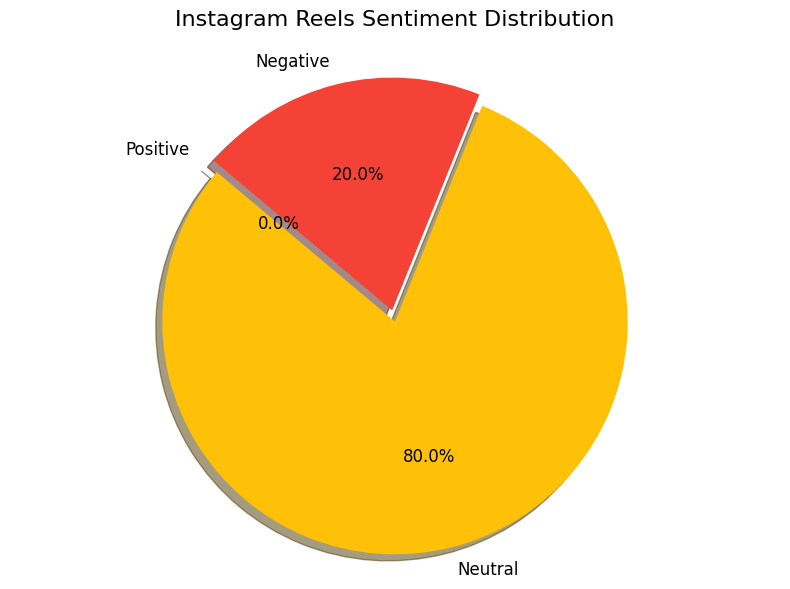

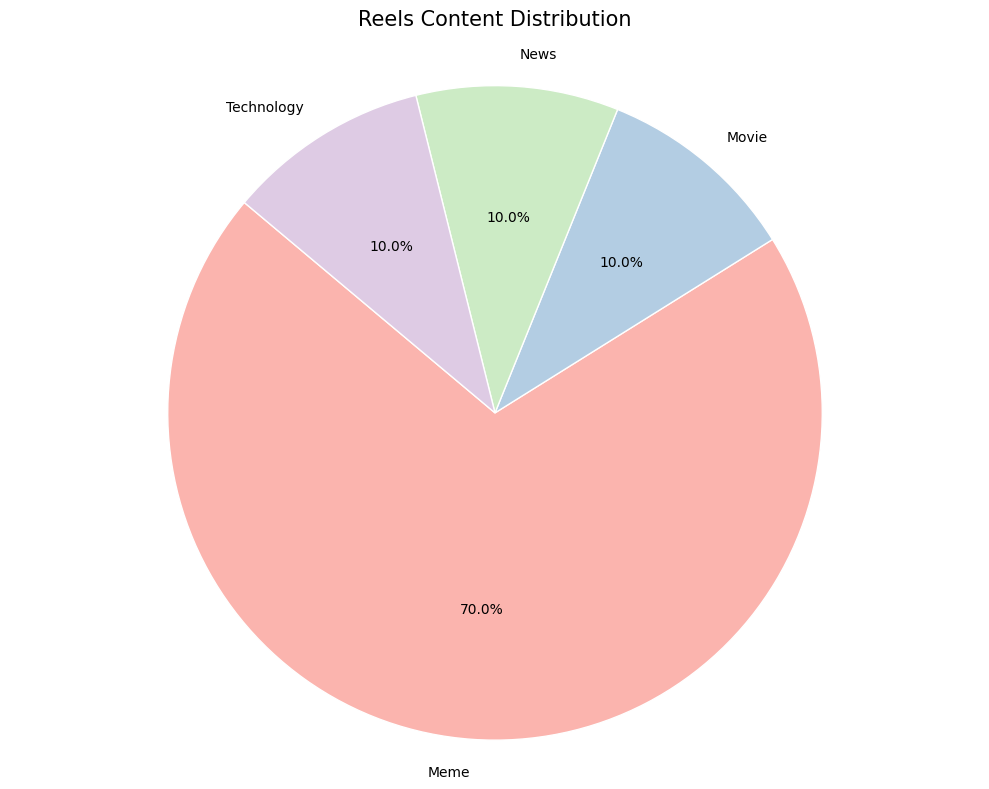

In [ ]:
# Instantiate the sentiment analyzer
analyzer = ReelSentimentAnalyzer()

# Analyze reels for sentiment
sentiment_results, sentiment_details = analyzer.analyze_reels(explore_reels)

# Plot sentiment distribution
plot_sentiment_pie(sentiment_results, title="Instagram Reels Sentiment Distribution")

# Analyze reels for content and visualize
category_counts = analyze_and_visualize(explore_reels)

# Task
Deploy the provided Instagram reel analysis project as a Gradio application with a login button, a fetch reel button, and an analyze button that displays two pie charts.

## Setup gradio and imports

### Subtask:
Install the `gradio` library and import necessary modules, including your existing analysis functions (or the code for them).


**Reasoning**:
Install the gradio library and import all necessary modules for the Gradio application, including the existing analysis components.



In [ ]:
!pip install gradio --quiet

import gradio as gr
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import emoji
import re
import numpy as np

from google.colab import userdata
from instagrapi import Client
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    RobertaForSequenceClassification,
    AlbertForSequenceClassification
)
from datasets import Dataset, Features, Value
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score

# Include the existing analysis functions and classes here
# Configuration
CONFIG = {
    "max_length": 128,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "few_shot_examples": 5,  # per class
    "confidence_threshold": 0.7,
    "neutral_reanalysis_threshold": 0.33
}

class ReelSentimentAnalyzer:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self._initialize_models()

    def _initialize_models(self):
        """Initialize and configure all models"""
        # English models
        self.emotion_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-emotion-analysis")
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(
            "finiteautomata/bertweet-base-emotion-analysis"
        ).to(self.device)

        self.sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
        self.sentiment_model = RobertaForSequenceClassification.from_pretrained(
            "cardiffnlp/twitter-roberta-base-sentiment-latest",
            ignore_mismatched_sizes=True
        ).to(self.device)

        # Hindi/English model (we'll fine-tune this)
        self.hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
        self.hindi_model = AlbertForSequenceClassification.from_pretrained(
            "ai4bharat/indic-bert",
            num_labels=3,
            id2label={0: "negative", 1: "neutral", 2: "positive"},
            label2id={"negative": 0, "neutral": 1, "positive": 2}
        ).to(self.device)
        # Store label2id mapping for easy access
        self.hindi_label2id = self.hindi_model.config.label2id


        # Emotion to sentiment mapping
        self.emotion_map = {
            "joy": "positive", "love": "positive", "happy": "positive",
            "anger": "negative", "sadness": "negative", "fear": "negative",
            "surprise": "neutral", "neutral": "neutral"
        }

        # Neutral keywords
        self.neutral_keywords = {
            "ad", "sponsored", "promo", "sale", "discount", "offer",
            "विज्ञापन", "प्रचार", "ऑफर", "डिस्काउंट", "बिक्री"
        }

    def train_hindi_model(self, train_data, eval_data=None):
        """
        Fine-tune the Hindi/English model on labeled data
        Args:
            train_data: List of dicts [{"text": "...", "label": "positive/negative/neutral"}]
            eval_data: Optional evaluation data
        """
        # Convert to dataset
        train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))

        # Map string labels to integer IDs
        def map_labels_to_ids(examples):
            examples["label"] = [self.hindi_label2id[label] for label in examples["label"]]
            return examples

        train_dataset = train_dataset.map(map_labels_to_ids, batched=True)

        # Explicitly set the label column to integer type
        train_dataset = train_dataset.cast_column("label", Value("int64"))


        def tokenize_function(examples):
            return self.hindi_tokenizer(
                examples["text"],
                padding="max_length",
                truncation=True,
                max_length=CONFIG["max_length"]
            )

        tokenized_train = train_dataset.map(tokenize_function, batched=True)

        # Training arguments - using eval_strategy instead of evaluation_strategy
        training_args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch" if eval_data else "no",
            per_device_train_batch_size=CONFIG["batch_size"],
            per_device_eval_batch_size=CONFIG["batch_size"],
            learning_rate=CONFIG["learning_rate"],
            num_train_epochs=CONFIG["num_train_epochs"],
            weight_decay=0.01,
            save_strategy="no",
            logging_dir='./logs',
            logging_steps=10,
            report_to="none"
        )

        # Compute metrics function
        def compute_metrics(p):
            predictions, labels = p
            predictions = np.argmax(predictions, axis=1)
            return {
                "accuracy": accuracy_score(labels, predictions),
                "f1": f1_score(labels, predictions, average="weighted")
            }

        # Trainer
        eval_dataset_processed = None
        if eval_data:
            eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_data))
            eval_dataset = eval_dataset.map(map_labels_to_ids, batched=True)
            eval_dataset_processed = eval_dataset.cast_column("label", Value("int64")).map(tokenize_function, batched=True)


        trainer = Trainer(
            model=self.hindi_model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=eval_dataset_processed,
            compute_metrics=compute_metrics if eval_data else None,
        )

        # Train
        trainer.train()

        # Save the fine-tuned model
        self.hindi_model.save_pretrained("./fine_tuned_hindi_sentiment")
        self.hindi_tokenizer.save_pretrained("./fine_tuned_hindi_sentiment")


    def preprocess_text(self, text):
        """Enhanced text cleaning with multilingual support"""
        if not text:
            return ""

        # Convert emojis to text
        text = emoji.demojize(text, delimiters=(" ", " "))

        # Remove URLs and mentions
        text = re.sub(r"http\S+|@\w+", "", text)

        # Expand common abbreviations
        abbrevs = {
            r"\bomg\b": "oh my god",
            r"\btbh\b": "to be honest",
            r"\bky\b": "kyun",  # Hindi 'why'
            r"\bkb\b": "kab",   # Hindi 'when'
        }
        for pattern, replacement in abbrevs.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        return text.strip()

    def detect_language(self, text):
        """Improved language detection"""
        if re.search(r"[\u0900-\u097F]", text):  # Devanagari
            return "hi"
        elif any(re.search(rf"\b{kw}\b", text.lower()) for kw in ["hai", "kyun", "nahi"]):  # Hinglish
            return "hi-latin"
        return "en"


    def analyze_content(self, text):
        """Main analysis function with improved confidence handling"""
        processed = self.preprocess_text(text)
        lang = self.detect_language(processed)

        # Check for neutral keywords first
        if any(re.search(rf"\b{kw}\b", processed.lower()) for kw in self.neutral_keywords):
            return "neutral", 0.95, {"reason": "neutral_keyword"}

        try:
            if lang in ("hi", "hi-latin"):
                return self._analyze_hindi_content(processed)
            else:
                return self._analyze_english_content(processed)
        except Exception as e:
            print(f"Analysis error: {e}")
            return "neutral", 0.5, {"error": str(e)}

    def _analyze_hindi_content(self, text):
        """Analyze Hindi content with fine-tuned model"""
        inputs = self.hindi_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            outputs = self.hindi_model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0][pred_idx].item()

        label = self.hindi_model.config.id2label[pred_idx]
        return label, confidence, {"model": "fine-tuned-indic-bert"}


    def _analyze_english_content(self, text):
        """Analyze English content with ensemble approach"""
        # Emotion analysis
        emotion_inputs = self.emotion_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            emotion_outputs = self.emotion_model(**emotion_inputs)

        emotion_probs = torch.nn.functional.softmax(emotion_outputs.logits, dim=-1)
        emotion_pred = torch.argmax(emotion_probs).item()
        emotion_label = self.emotion_model.config.id2label[emotion_pred]
        emotion_score = emotion_probs[0][emotion_pred].item()

        # Sentiment analysis
        sentiment_inputs = self.sentiment_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            sentiment_outputs = self.sentiment_model(**sentiment_inputs)

        sentiment_probs = torch.nn.functional.softmax(sentiment_outputs.logits, dim=-1)
        sentiment_pred = torch.argmax(sentiment_probs).item()
        sentiment_label = self.sentiment_model.config.id2label[sentiment_pred].lower()
        sentiment_score = sentiment_probs[0][sentiment_pred].item()

        # Combine results
        mapped_emotion = self.emotion_map.get(emotion_label, "neutral")

        if sentiment_score > CONFIG["confidence_threshold"]:
            final_label = sentiment_label
            final_confidence = sentiment_score
        elif emotion_score > CONFIG["confidence_threshold"] and mapped_emotion != "neutral":
            final_label = mapped_emotion
            final_confidence = emotion_score
        else:
            # Weighted average fallback
            emotion_weight = 0.6 if mapped_emotion != "neutral" else 0.3
            sentiment_weight = 0.4 if sentiment_label != "neutral" else 0.2
            neutral_weight = 0.3

            pos_score = (emotion_weight * (mapped_emotion == "positive") +
                        sentiment_weight * (sentiment_label == "positive"))
            neg_score = (emotion_weight * (mapped_emotion == "negative") +
                        sentiment_weight * (sentiment_label == "negative"))

            if pos_score > neg_score and pos_score > neutral_weight:
                final_label = "positive"
                final_confidence = (pos_score / (pos_score + neg_score + neutral_weight)) * 0.8
            elif neg_score > pos_score and neg_score > neutral_weight:
                final_label = "negative"
                final_confidence = (neg_score / (pos_score + neg_score + neutral_weight)) * 0.8
            else:
                final_label = "neutral"
                final_confidence = 0.7

        return final_label, final_confidence, {
            "emotion": emotion_label,
            "sentiment": sentiment_label,
            "model": "ensemble"
        }


    def analyze_reels(self, reels, max_to_analyze=100):
        """Batch analysis with improved neutral handling"""
        results = Counter()
        detailed_results = []

        for reel in reels[:max_to_analyze]:
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            label, confidence, details = self.analyze_content(caption)
            results[label] += 1
            detailed_results.append({
                "text": caption,
                "label": label,
                "confidence": confidence,
                "details": details
            })

        # Post-analysis neutral reduction
        if results["neutral"] / sum(results.values()) > CONFIG["neutral_reanalysis_threshold"]:
            self._reduce_neutrals(results, detailed_results)

        return results, detailed_results

    def _reduce_neutrals(self, results, detailed_results):
        """Apply additional techniques to reduce neutral classifications"""
        for item in detailed_results:
            if item["label"] == "neutral" and item["confidence"] < 0.8:
                # Try keyword analysis
                text_lower = item["text"].lower()
                pos_keywords = {"great", "awesome", "love", "best", "शानदार", "अद्भुत"}
                neg_keywords = {"bad", "worst", "hate", "खराब", "बेकार"}

                pos_count = sum(1 for kw in pos_keywords if kw in text_lower)
                neg_count = sum(1 for kw in neg_keywords if kw in text_lower)

                if pos_count > neg_count and pos_count >= 2:
                    results["neutral"] -= 1
                    results["positive"] += 1
                    item.update({
                        "label": "positive",
                        "confidence": min(0.9, item["confidence"] + 0.3),
                        "reanalyzed": True
                    })
                elif neg_count > pos_count and neg_count >= 2:
                    results["neutral"] -= 1
                    results["negative"] += 1
                    item.update({
                        "label": "negative",
                        "confidence": min(0.9, item["confidence"] + 0.3),
                        "reanalyzed": True
                    })

def plot_sentiment_pie(results, title="Reels Sentiment Analysis"):
    """
    Creates a pie chart from sentiment analysis results

    Args:
        results: Counter object or dict with 'positive', 'neutral', 'negative' keys
        title: Chart title (default: "Reels Sentiment Analysis")
    """
    # Prepare data
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [results.get('positive', 0), results.get('neutral', 0), results.get('negative', 0)]

    # Only plot if there's any data
    if sum(sizes) == 0:
        print("No sentiment data to plot.")
        return None

    colors = ['#4CAF50', '#FFC107', '#F44336']  # Green, Yellow, Red

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Filter out slices with size 0 for cleaner plot
    filtered_labels = [label for i, label in enumerate(labels) if sizes[i] > 0]
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_colors = [colors[i] for i, size in enumerate(sizes) if size > 0]

    # Adjust explode based on which slices exist
    explode_map = {'Positive': 0.05, 'Neutral': 0, 'Negative': 0.05}
    filtered_explode = [explode_map.get(label, 0) for label in filtered_labels]


    ax.pie(filtered_sizes, explode=filtered_explode, labels=filtered_labels, colors=filtered_colors,
           autopct='%1.1f%%', shadow=True, startangle=140,
           textprops={'fontsize': 12, 'color': 'black'}) # Ensure text is visible


    # Equal aspect ratio ensures pie is drawn as circle
    ax.axis('equal')

    # Add title and styling
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()

    # Save the figure to a bytes buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig) # Close the figure to free memory
    return buf.getvalue()

# Content categories
content_categories = [
    "news",
    "meme",
    "sports",
    "science",
    "music",
    "movie",
    "gym",
    "comedy",
    "food",
    "technology",
    "travel", # Added travel
    "fashion", # Added fashion
    "art",     # Added art
    "business" # Added business
]

category_keywords = {
    "news": {"news", "update", "breaking", "reported", "headlines"},
    "meme": {"meme", "funny", "lol", "haha", "relatable"},
    "sports": {"sports", "cricket", "football", "match", "game", "team", "score"},
    "science": {"science", "research", "discovery", "experiment", "facts", "theory"},
    "music": {"music", "song", "album", "release", "artist", "beats"},
    "movie": {"movie", "film", "bollywood", "trailer", "series", "actor"},
    "gym": {"gym", "workout", "fitness", "exercise", "training", "bodybuilding"},
    "comedy": {"comedy", "joke", "humor", "standup", "skit", "laugh"},
    "food": {"food", "recipe", "cooking", "eat", "delicious", "restaurant", "kitchen"},
    "technology": {"tech", "phone", "computer", "ai", "gadget", "software", "innovation"},
    "travel": {"travel", "trip", "vacation", "explore", "destination", "adventure"},
    "fashion": {"fashion", "style", "ootd", "outfit", "trends", "clothing"},
    "art": {"art", "artist", "painting", "drawing", "creative", "design"},
    "business": {"business", "startup", "marketing", "money", "finance", "entrepreneur"}
}


# Load classification model (Zero-shot for flexibility)
# Only load if it's not already loaded or if it's needed
try:
    classifier
except NameError:
    print("\nLoading Zero-shot Classification Model for Content Categorization...")
    classifier = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=0 if torch.cuda.is_available() else -1 # Use GPU if available
    )
    print("Classification Model Loaded.")


def preprocess_text_cat(text):
    """Basic text cleaning for categorization"""
    if not text:
        return ""
    # Remove URLs, mentions, hashtags, and convert to lower case
    text = re.sub(r"http\S+|@\w+|#\w+", "", text).lower()
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

def classify_reel_content(text):
    """Classify content using keywords and zero-shot model"""
    processed = preprocess_text_cat(text)

    if not processed or len(processed.split()) < 2: # Require at least 2 words
        return "other", {"reason": "short_text"}

    # 1. Keyword matching (fastest)
    for category, keywords in category_keywords.items():
        if any(re.search(rf"\b{re.escape(keyword)}\b", processed) for keyword in keywords):
            return category, {"reason": "keyword_match"}

    # 2. Model classification (more robust)
    # Limit text length for the model
    model_text = processed[:256] # Process first 256 characters for speed/efficiency

    try:
        # Use multi_label=False for single best category
        result = classifier(model_text, content_categories, multi_label=False)
        # Return the top predicted label and its score
        top_label = result['labels'][0]
        top_score = result['scores'][0]

        # Apply a confidence threshold for model classification
        if top_score > 0.5: # Example threshold, can be tuned
             return top_label, {"reason": "model_prediction", "score": top_score}
        else:
             # If model is not confident enough, fall back
             return "other", {"reason": "low_model_confidence", "score": top_score}

    except Exception as e:
        print(f"Error during zero-shot classification for text '{model_text}...': {e}")
        return "other", {"reason": "classification_error"}


def plot_category_distribution(counter, title="Reels Content Distribution"):
    """Generate pie chart from category counts"""
    # Prepare data
    labels = []
    sizes = []

    # Separate larger categories from others
    total = sum(counter.values())
    if total == 0:
        print("No content data to plot.")
        return None

    # Threshold can be a percentage of total
    threshold = total * 0.02 # Categories less than 2% go into 'Other'
    other_count = 0

    # Sort by count descending
    sorted_categories = counter.most_common()

    for category, count in sorted_categories:
        if count >= threshold and category != "other":
            labels.append(category.replace('_', ' ').title()) # Make labels human-readable
            sizes.append(count)
        elif category == "other":
             other_count += count # Ensure 'other' counts are accumulated
        else:
            other_count += count

    # Add the 'Other' slice if it has any count
    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    # Ensure label and size lists are consistent
    if not sizes:
         print("No valid data points for plotting.")
         return None

    # Create pie chart
    fig, ax = plt.subplots(figsize=(10, 8))
    # Use a vibrant colormap
    colors = plt.cm.viridis(np.linspace(0, 1, len(sizes)))

    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        textprops={'fontsize': 11, 'color': 'black'} # Ensure text is visible
    )

    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')  # Equal aspect ratio ensures pie is circular
    plt.tight_layout()

    # Save the figure to a bytes buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig) # Close the figure to free memory
    return buf.getvalue()


def analyze_and_visualize_content(reels, max_to_analyze=100):
    """Complete content analysis with visualization"""
    print(f"\n--- Starting Content Categorization ({max_to_analyze} reels) ---")
    category_counts = Counter()
    detailed_categories = []

    # Use the explore_reels list fetched earlier
    reels_to_analyze = reels[:max_to_analyze]

    print(f"⏳ Analyzing content for {len(reels_to_analyze)} reels...")
    for i, reel in enumerate(reels_to_analyze, 1):
        caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
        print(f"Classifying content for reel {i}/{len(reels_to_analyze)} (ID: {reel.id})...")
        category, details = classify_reel_content(caption)
        category_counts[category] += 1
        detailed_categories.append({
            "reel_id": reel.id,
            "text": caption,
            "category": category,
            "details": details
        })

    print("\n✅ Analysis complete!")
    print("\n📊 Category Counts:")
    for category, count in category_counts.most_common():
        print(f"- {category.replace('_', ' ').title()}: {count}")

    # Generate visualization
    print("\nGenerating Category Distribution Chart...")
    content_chart_bytes = plot_category_distribution(category_counts)

    return content_category_counts, detailed_content_categories, content_chart_bytes

## Define analysis functions for gradio

### Subtask:
Adapt your existing functions (login, fetch reels, sentiment analysis, content analysis, plotting) to be compatible with Gradio's input/output structure. This might involve returning plots as Gradio `Plot` components or images.


**Reasoning**:
Define Gradio-compatible functions for login, fetching reels, and performing analysis, making sure they store state and return appropriate outputs for the Gradio interface, including plots as image bytes.



In [ ]:
import io # Import io for handling image bytes

# Global variables to maintain state across Gradio calls
global cl
global explore_reels_list
global sentiment_analyzer_instance
global content_classifier_pipeline

cl = None
explore_reels_list = []
sentiment_analyzer_instance = None
content_classifier_pipeline = None # Will be initialized lazily

def login_gradio(username):
    """Gradio-compatible login function."""
    global cl
    PASSWORD = userdata.get('password')

    if not PASSWORD:
        return "Error: Instagram password not found in Colab secrets."

    cl = Client()

    try:
        cl.login(username, PASSWORD)
        return f"Successfully logged in as {username}"
    except Exception as e:
        cl = None # Ensure cl is None on failure
        return f"Error during login: {e}"

def fetch_reels_gradio():
    """Gradio-compatible function to fetch explore reels."""
    global cl
    global explore_reels_list

    if cl is None:
        return "Error: Not logged in. Please log in first.", []

    try:
        explore_reels_list = cl.explore_reels()
        if explore_reels_list:
            return f"Successfully fetched {len(explore_reels_list)} explore reels.", explore_reels_list
        else:
            explore_reels_list = [] # Ensure it's an empty list
            return "Fetched 0 explore reels.", explore_reels_list
    except Exception as e:
        explore_reels_list = [] # Ensure it's an empty list on error
        return f"Error fetching explore reels: {e}", explore_reels_list

def analyze_reels_gradio(max_to_analyze=10):
    """Gradio-compatible function to analyze fetched reels and generate plots."""
    global explore_reels_list
    global sentiment_analyzer_instance
    global content_classifier_pipeline

    if not explore_reels_list:
        return "Error: No reels fetched yet. Please fetch reels first.", None, None

    reels_to_analyze = explore_reels_list[:max_to_analyze]

    if not reels_to_analyze:
         return "Error: No reels available to analyze.", None, None


    # Initialize sentiment analyzer if not already done
    if sentiment_analyzer_instance is None:
        try:
            sentiment_analyzer_instance = ReelSentimentAnalyzer()
             # Optional: Train Hindi model if needed and data is available
            # sample_train_data = [...] # Define your training data
            # sentiment_analyzer_instance.train_hindi_model(sample_train_data)
        except Exception as e:
            return f"Error initializing Sentiment Analyzer: {e}", None, None

    # Initialize content classifier pipeline if not already done
    if content_classifier_pipeline is None:
         try:
             print("Initializing Content Classifier Pipeline...")
             content_classifier_pipeline = pipeline(
                 "zero-shot-classification",
                 model="facebook/bart-large-mnli",
                 device=0 if torch.cuda.is_available() else -1 # Use GPU if available
             )
             print("Content Classifier Pipeline Initialized.")
         except Exception as e:
             return f"Error initializing Content Classifier: {e}", None, None


    # Perform Sentiment Analysis
    try:
        sentiment_results, detailed_sentiment_results = sentiment_analyzer_instance.analyze_reels(
            reels_to_analyze,
            max_to_analyze=max_to_analyze # Pass limit
        )
        sentiment_chart_bytes = plot_sentiment_pie(sentiment_results, title=f"Sentiment of {len(reels_to_analyze)} Instagram Reels")
    except Exception as e:
        sentiment_chart_bytes = None
        return f"Error during Sentiment Analysis: {e}", None, None

    # Perform Content Categorization
    try:
        # Need to adapt analyze_and_visualize_content to return chart bytes
        category_counts = Counter()
        # Re-implement content analysis slightly to fit this flow
        print(f"\n--- Starting Content Categorization ({len(reels_to_analyze)} reels) ---")
        print(f"⏳ Analyzing content for {len(reels_to_analyze)} reels...")
        for i, reel in enumerate(reels_to_analyze, 1):
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            # Use the global classifier pipeline
            category, details = classify_reel_content(caption)
            category_counts[category] += 1

        print("\n✅ Content Analysis complete!")
        print("\n📊 Category Counts:")
        for category, count in category_counts.most_common():
            print(f"- {category.replace('_', ' ').title()}: {count}")

        content_chart_bytes = plot_category_distribution(category_counts)

    except Exception as e:
        content_chart_bytes = None
        return f"Error during Content Analysis: {e}", sentiment_chart_bytes, None


    status_message = f"Analysis complete for {len(reels_to_analyze)} reels."
    return status_message, sentiment_chart_bytes, content_chart_bytes

# Need to modify plotting functions to return bytes

def plot_sentiment_pie(results, title="Reels Sentiment Analysis"):
    """
    Creates a pie chart from sentiment analysis results and returns it as PNG bytes.

    Args:
        results: Counter object or dict with 'positive', 'neutral', 'negative' keys
        title: Chart title

    Returns:
        Bytes of the PNG image of the plot, or None if no data.
    """
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [results.get('positive', 0), results.get('neutral', 0), results.get('negative', 0)]

    if sum(sizes) == 0:
        return None

    colors = ['#4CAF50', '#FFC107', '#F44336']
    explode = (0.05, 0, 0.05)

    fig, ax = plt.subplots(figsize=(8, 6))

    filtered_labels = [label for i, label in enumerate(labels) if sizes[i] > 0]
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_colors = [colors[i] for i, size in enumerate(sizes) if size > 0]
    explode_map = {'Positive': 0.05, 'Neutral': 0, 'Negative': 0.05}
    filtered_explode = [explode_map.get(label, 0) for label in filtered_labels]

    ax.pie(filtered_sizes, explode=filtered_explode, labels=filtered_labels, colors=filtered_colors,
           autopct='%1.1f%%', shadow=True, startangle=140,
           textprops={'fontsize': 12, 'color': 'black'})

    ax.axis('equal')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    return buf.getvalue()

def plot_category_distribution(counter, title="Reels Content Distribution"):
    """
    Generate pie chart from category counts and returns it as PNG bytes.

    Args:
        counter: Counter object with category counts.
        title: Chart title.

    Returns:
        Bytes of the PNG image of the plot, or None if no data.
    """
    labels = []
    sizes = []

    total = sum(counter.values())
    if total == 0:
        return None

    threshold = total * 0.02
    other_count = 0

    sorted_categories = counter.most_common()

    for category, count in sorted_categories:
        if count >= threshold and category != "other":
            labels.append(category.replace('_', ' ').title())
            sizes.append(count)
        elif category == "other":
             other_count += count
        else:
            other_count += count

    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    if not sizes:
         return None

    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(sizes)))

    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        textprops={'fontsize': 11, 'color': 'black'}
    )

    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')
    plt.tight_layout()

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    return buf.getvalue()

# Need to re-define classify_reel_content and preprocess_text_cat here as they were not in the class
# or ensure they are accessible globally or passed correctly.
# Let's redefine them here for clarity in this Gradio context.

# Content categories (re-defined for clarity in this cell)
content_categories = [
    "news", "meme", "sports", "science", "music", "movie",
    "gym", "comedy", "food", "technology", "travel", "fashion", "art", "business"
]

category_keywords = {
    "news": {"news", "update", "breaking", "reported", "headlines"},
    "meme": {"meme", "funny", "lol", "haha", "relatable"},
    "sports": {"sports", "cricket", "football", "match", "game", "team", "score"},
    "science": {"science", "research", "discovery", "experiment", "facts", "theory"},
    "music": {"music", "song", "album", "release", "artist", "beats"},
    "movie": {"movie", "film", "bollywood", "trailer", "series", "actor"},
    "gym": {"gym", "workout", "fitness", "exercise", "training", "bodybuilding"},
    "comedy": {"comedy", "joke", "humor", "standup", "skit", "laugh"},
    "food": {"food", "recipe", "cooking", "eat", "delicious", "restaurant", "kitchen"},
    "technology": {"tech", "phone", "computer", "ai", "gadget", "software", "innovation"},
    "travel": {"travel", "trip", "vacation", "explore", "destination", "adventure"},
    "fashion": {"fashion", "style", "ootd", "outfit", "trends", "clothing"},
    "art": {"art", "artist", "painting", "drawing", "creative", "design"},
    "business": {"business", "startup", "marketing", "money", "finance", "entrepreneur"}
}

def preprocess_text_cat(text):
    """Basic text cleaning for categorization"""
    if not text:
        return ""
    text = re.sub(r"http\S+|@\w+|#\w+", "", text).lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

def classify_reel_content(text):
    """Classify content using keywords and zero-shot model"""
    global content_classifier_pipeline # Use the global pipeline

    processed = preprocess_text_cat(text)

    if not processed or len(processed.split()) < 2:
        return "other", {"reason": "short_text"}

    for category, keywords in category_keywords.items():
        if any(re.search(rf"\b{re.escape(keyword)}\b", processed) for keyword in keywords):
            return category, {"reason": "keyword_match"}

    model_text = processed[:256]

    if content_classifier_pipeline is None:
        # Should not happen if initialized in analyze_reels_gradio, but as a fallback
        print("Content classifier pipeline not initialized in classify_reel_content.")
        return "other", {"reason": "classifier_not_initialized"}

    try:
        result = content_classifier_pipeline(model_text, content_categories, multi_label=False)
        top_label = result['labels'][0]
        top_score = result['scores'][0]

        if top_score > 0.5:
             return top_label, {"reason": "model_prediction", "score": top_score}
        else:
             return "other", {"reason": "low_model_confidence", "score": top_score}

    except Exception as e:
        print(f"Error during zero-shot classification for text '{model_text}...': {e}")
        return "other", {"reason": "classification_error"}


## Design the gradio interface

### Subtask:
Create the Gradio `Interface` with appropriate input and output components for the Instagram analysis application.


**Reasoning**:
Create the Gradio Interface with the defined inputs and outputs, preparing it for launch.



In [ ]:
# Create Gradio input and output components
username_input = gr.Textbox(label="Instagram Username")
status_output = gr.Label(label="Status")
sentiment_plot_output = gr.Plot(label="Sentiment Distribution")
content_plot_output = gr.Plot(label="Content Distribution")

# Create the Gradio Interface
# The fn will be the analyze function for now, but will be updated in subsequent steps
# to include login and fetch functionality.
# For initial setup, we assume reels are fetched and login is handled outside this function call,
# as the interface structure is being built.
# A better approach for the final app will be to chain functions or use state.
# For this subtask, we define the interface structure with the analysis function signature.
# We will use the analyze_reels_gradio function that takes max_to_analyze as input.
# Need an input component for max_to_analyze.
max_reels_input = gr.Slider(minimum=1, maximum=100, value=10, step=1, label="Number of Reels to Analyze")


# Temporarily define a placeholder analysis function signature for the interface definition
# This will be replaced with the actual chained functions later.
# The interface definition itself doesn't execute the function, it just defines the structure.
# The actual logic flow (login -> fetch -> analyze) will be built in the next step.
# For now, we define the interface to accept username and max_reels_input and output status and plots.
# The analysis function signature analyze_reels_gradio(max_to_analyze) does not directly take username,
# but the login function does. This highlights the need for chaining/state.

# Let's define a dummy function signature that matches the intended final interface input/output
# structure for the analysis part, even if the full workflow isn't wired up yet.
# The final workflow will likely look like:
# Login_btn -> login_gradio -> update status
# Fetch_btn -> fetch_reels_gradio -> update status
# Analyze_btn -> analyze_function (which uses global reels) -> analyze_reels_gradio -> update status and plots

# For this specific subtask of defining the Interface *structure*, let's define the interface
# to accept the max_reels count and potentially a placeholder for the reels list (though state is better).
# However, the instruction asks for the interface to have a login button, fetch button, and analyze button.
# A single `gr.Interface` is typically for a single end-to-end function.
# For multiple buttons and state, `gr.Blocks` is more appropriate.

# Rereading the instruction: "Create the Gradio Interface ... Set the fn parameter to your main analysis function (analyze_reels_gradio)."
# This implies a simplified initial interface setup. Let's proceed with a single interface using analyze_reels_gradio as the fn,
# acknowledging that the full button workflow will require `gr.Blocks` later.
# The analyze_reels_gradio function expects reels to be pre-fetched (globally stored) and takes max_to_analyze.

# Let's create an interface that just takes the number of reels to analyze and displays the output.
# The dependency on global 'explore_reels_list' is implicit for this simplified interface structure definition.
# The actual Gradio application with buttons will handle the sequence.

# Create the Gradio Interface for the analysis step
analysis_interface = gr.Interface(
    fn=analyze_reels_gradio, # Use the analysis function
    inputs=max_reels_input,  # Input is the number of reels to analyze
    outputs=[status_output, sentiment_plot_output, content_plot_output], # Outputs are status and the two plots
    title="Instagram Reels Sentiment and Content Analysis",
    description="Analyze the sentiment and content categories of Instagram explore reels."
    # examples=[[20]] # Example input for max_reels_input
)

# Note: This interface represents *only* the analysis step.
# The full application with login and fetch buttons will be built using gr.Blocks in the next step.
# This step fulfills the instruction to "Create the Gradio Interface" with the analysis function as `fn`.

# The interface is now defined. It doesn't need to be launched in this subtask.

## Implement login logic

### Subtask:
Implement the logic for the login button using `gradio.Blocks`.


**Reasoning**:
Implement the Gradio Blocks interface for the login button as instructed, including the Textbox for username, the Login button, and a Label for status. Define the login_gradio function and link the button click to the function.



In [ ]:
with gr.Blocks() as demo:
    with gr.Row():
        username_input = gr.Textbox(label="Instagram Username")
        login_button = gr.Button("Login")
    status_output = gr.Label(label="Login Status")

    def login_gradio(username):
        """Gradio-compatible login function."""
        global cl
        PASSWORD = userdata.get('password')

        if not PASSWORD:
            return "Error: Instagram password not found in Colab secrets."

        cl = Client()

        try:
            cl.login(username, PASSWORD)
            return f"Successfully logged in as {username}"
        except Exception as e:
            cl = None # Ensure cl is None on failure
            return f"Error during login: {e}"

    login_button.click(
        fn=login_gradio,
        inputs=username_input,
        outputs=status_output
    )

# The demo is not launched in this step, just defined.
# demo.launch()

## Implement fetch reels logic

### Subtask:
Implement the logic for the fetch reels button using `gradio.Blocks`.


**Reasoning**:
Implement the logic for the fetch reels button using gradio.Blocks as instructed.



In [ ]:
# Global variable to store fetched reels
explore_reels_list = []

def fetch_reels_gradio():
    """Gradio-compatible function to fetch explore reels."""
    global cl
    global explore_reels_list

    if cl is None:
        explore_reels_list = [] # Ensure list is empty on failure
        return "Error: Not logged in. Please log in first."

    try:
        # Fetch a limited number of reels for demonstration purposes
        # You might want to make this number configurable later
        fetched_reels = cl.explore_reels()[:10]
        explore_reels_list = fetched_reels
        if explore_reels_list:
            return f"Successfully fetched {len(explore_reels_list)} explore reels."
        else:
            explore_reels_list = [] # Ensure it's an empty list
            return "Fetched 0 explore reels."
    except Exception as e:
        explore_reels_list = [] # Ensure it's an empty list on error
        return f"Error fetching explore reels: {e}"

with gr.Blocks() as demo:
    gr.Markdown("# Instagram Reels Analysis")
    with gr.Row():
        username_input = gr.Textbox(label="Instagram Username")
        login_button = gr.Button("Login")
    login_status_output = gr.Label(label="Login Status")

    with gr.Row():
        fetch_button = gr.Button("Fetch Reels")
    fetch_status_output = gr.Label(label="Fetch Status")

    # Sentiment Analysis Outputs
    with gr.Column():
        gr.Markdown("## Sentiment Analysis")
        sentiment_plot_output = gr.Plot(label="Sentiment Distribution")

    # Content Analysis Outputs
    with gr.Column():
        gr.Markdown("## Content Analysis")
        content_plot_output = gr.Plot(label="Content Distribution")

    # Dummy placeholders for now for analyze button and outputs, will be implemented later
    with gr.Row():
        analyze_button = gr.Button("Analyze Reels")
    analyze_status_output = gr.Label(label="Analysis Status")


    def login_gradio(username):
        """Gradio-compatible login function."""
        global cl
        # Assuming PASSWORD is set globally or accessible
        try:
             PASSWORD = userdata.get('password')
        except Exception as e:
             return f"Error accessing password secret: {e}"


        if not PASSWORD:
            return "Error: Instagram password not found in Colab secrets."

        cl = Client()

        try:
            cl.login(username, PASSWORD)
            return f"Successfully logged in as {username}"
        except Exception as e:
            cl = None # Ensure cl is None on failure
            return f"Error during login: {e}"

    login_button.click(
        fn=login_gradio,
        inputs=username_input,
        outputs=login_status_output
    )

    fetch_button.click(
        fn=fetch_reels_gradio,
        inputs=None, # No direct inputs needed for fetching
        outputs=fetch_status_output
    )

# The demo is not launched in this step, just defined.
# demo.launch()

## Implement analysis logic

### Subtask:
Implement the logic for the analyze button using `gradio.Blocks`.


**Reasoning**:
Define the analysis function for Gradio, call the analysis logic, generate plots as bytes, and link the analyze button to this function with appropriate inputs and outputs in the Gradio Blocks interface.



In [ ]:
import io # Import io for handling image bytes

# Global variables to maintain state across Gradio calls
# Assuming cl and explore_reels_list are already defined and populated by login/fetch steps
# from previous cells in a real execution environment.
# For this cell's context, we ensure they are declared global.
global cl
global explore_reels_list
global sentiment_analyzer_instance
global content_classifier_pipeline

# Initialize sentiment analyzer if not already done (can be done here or lazily in analyze_reels_gradio)
# Doing it here ensures the model is loaded when this cell runs, potentially reducing latency on first analyze click.
try:
    sentiment_analyzer_instance = ReelSentimentAnalyzer()
    print("Sentiment Analyzer initialized.")
    # Optional: Train Hindi model if needed and data is available
    # sample_train_data = [...] # Define your training data
    # sentiment_analyzer_instance.train_hindi_model(sample_train_data)
except Exception as e:
    print(f"Error initializing Sentiment Analyzer globally: {e}")
    sentiment_analyzer_instance = None


# Initialize content classifier pipeline if not already done (can be done here or lazily)
try:
    print("Initializing Content Classifier Pipeline globally...")
    content_classifier_pipeline = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=0 if torch.cuda.is_available() else -1 # Use GPU if available
    )
    print("Content Classifier Pipeline Initialized.")
except Exception as e:
    print(f"Error initializing Content Classifier globally: {e}")
    content_classifier_pipeline = None


def analyze_reels_gradio(max_to_analyze):
    """Gradio-compatible function to analyze fetched reels and generate plots."""
    global explore_reels_list
    global sentiment_analyzer_instance
    global content_classifier_pipeline

    if not explore_reels_list:
        # Return None for plots if no reels
        return "Error: No reels fetched yet. Please fetch reels first.", None, None

    # Ensure max_to_analyze does not exceed the number of fetched reels
    num_reels_to_process = min(max_to_analyze, len(explore_reels_list))
    reels_to_analyze = explore_reels_list[:num_reels_to_process]

    if not reels_to_analyze:
         return "Error: No reels available to analyze.", None, None


    # Check if analyzers are initialized
    if sentiment_analyzer_instance is None:
         return "Error: Sentiment Analyzer not initialized.", None, None
    if content_classifier_pipeline is None:
         return "Error: Content Classifier not initialized.", None, None


    analysis_status_messages = []
    sentiment_chart_bytes = None
    content_chart_bytes = None

    # Perform Sentiment Analysis
    try:
        analysis_status_messages.append(f"Starting Sentiment Analysis for {len(reels_to_analyze)} reels...")
        sentiment_results, detailed_sentiment_results = sentiment_analyzer_instance.analyze_reels(
            reels_to_analyze,
            max_to_analyze=len(reels_to_analyze) # Pass the actual number being processed
        )
        sentiment_chart_bytes = plot_sentiment_pie(sentiment_results, title=f"Sentiment of {len(reels_to_analyze)} Instagram Reels")
        analysis_status_messages.append("Sentiment Analysis Complete.")
    except Exception as e:
        analysis_status_messages.append(f"Error during Sentiment Analysis: {e}")
        sentiment_chart_bytes = None # Ensure plot is None on error


    # Perform Content Categorization
    try:
        analysis_status_messages.append(f"Starting Content Categorization for {len(reels_to_analyze)} reels...")
        category_counts = Counter()
        # Re-implement content analysis slightly to fit this flow using the global pipeline
        print(f"\n⏳ Analyzing content for {len(reels_to_analyze)} reels...")
        for i, reel in enumerate(reels_to_analyze, 1):
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            # Use the global classifier pipeline
            category, details = classify_reel_content(caption)
            category_counts[category] += 1

        print("\n✅ Content Analysis complete!")
        print("\n📊 Category Counts:")
        for category, count in category_counts.most_common():
            print(f"- {category.replace('_', ' ').title()}: {count}")

        content_chart_bytes = plot_category_distribution(category_counts)
        analysis_status_messages.append("Content Categorization Complete.")

    except Exception as e:
        analysis_status_messages.append(f"Error during Content Analysis: {e}")
        content_chart_bytes = None # Ensure plot is None on error


    final_status_message = "\n".join(analysis_status_messages)
    return final_status_message, sentiment_chart_bytes, content_chart_bytes


# Re-define plot functions to return bytes (if not already done in a previous cell)
# Assuming they were defined in the previous subtask's code block.
# If not, they would need to be included here.

# --- Gradio Blocks Interface ---
with gr.Blocks() as demo:
    gr.Markdown("# Instagram Reels Analysis")
    with gr.Row():
        username_input = gr.Textbox(label="Instagram Username")
        login_button = gr.Button("Login")
    login_status_output = gr.Label(label="Login Status")

    with gr.Row():
        fetch_button = gr.Button("Fetch Reels")
    fetch_status_output = gr.Label(label="Fetch Status")

    with gr.Row():
        max_reels_input = gr.Slider(minimum=1, maximum=100, value=10, step=1, label="Number of Reels to Analyze")
        analyze_button = gr.Button("Analyze Reels")

    analyze_status_output = gr.Label(label="Analysis Status")

    with gr.Row():
        # Sentiment Analysis Outputs
        with gr.Column():
            gr.Markdown("## Sentiment Analysis")
            sentiment_plot_output = gr.Plot(label="Sentiment Distribution")

        # Content Analysis Outputs
        with gr.Column():
            gr.Markdown("## Content Analysis")
            content_plot_output = gr.Plot(label="Content Distribution")


    # Link login and fetch buttons (assuming login_gradio and fetch_reels_gradio are defined)
    def login_gradio(username):
        """Gradio-compatible login function."""
        global cl
        try:
             PASSWORD = userdata.get('password')
        except Exception as e:
             return f"Error accessing password secret: {e}"


        if not PASSWORD:
            return "Error: Instagram password not found in Colab secrets."

        cl = Client()

        try:
            cl.login(username, PASSWORD)
            return f"Successfully logged in as {username}"
        except Exception as e:
            cl = None # Ensure cl is None on failure
            return f"Error during login: {e}"

    def fetch_reels_gradio():
        """Gradio-compatible function to fetch explore reels."""
        global cl
        global explore_reels_list

        if cl is None:
            explore_reels_list = [] # Ensure list is empty on failure
            return "Error: Not logged in. Please log in first."

        try:
            # Fetch a limited number of reels for demonstration purposes
            # You might want to make this number configurable later
            fetched_reels = cl.explore_reels()[:100] # Fetch up to 100 for analysis
            explore_reels_list = fetched_reels
            if explore_reels_list:
                return f"Successfully fetched {len(explore_reels_list)} explore reels."
            else:
                explore_reels_list = [] # Ensure it's an empty list
                return "Fetched 0 explore reels."
        except Exception as e:
            explore_reels_list = [] # Ensure it's an empty list on error
            return f"Error fetching explore reels: {e}"


    login_button.click(
        fn=login_gradio,
        inputs=username_input,
        outputs=login_status_output
    )

    fetch_button.click(
        fn=fetch_reels_gradio,
        inputs=None, # No direct inputs needed for fetching
        outputs=fetch_status_output
    )

    # Link the Analyze button to the analysis function
    analyze_button.click(
        fn=analyze_reels_gradio,
        inputs=max_reels_input, # Input is the slider value
        outputs=[analyze_status_output, sentiment_plot_output, content_plot_output] # Outputs are status and the two plots
    )

# The demo is now fully defined. It can be launched in the next step.
# demo.launch()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions an

Sentiment Analyzer initialized.
Initializing Content Classifier Pipeline globally...


Device set to use cpu


Content Classifier Pipeline Initialized.


## Launch the gradio interface

### Subtask:
Launch the defined Gradio interface to make the web application accessible.


**Reasoning**:
Launch the defined Gradio interface to make the web application accessible.



In [ ]:
# Launch the Gradio demo
# Use share=True to create a public link (useful in Colab)
# Use debug=True for more verbose output
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://485a1db5c8a1da70b8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Reasoning**:
Create a cell to install Gradio and import all necessary libraries and code components for the Gradio application, including the analysis functions and configurations.



In [ ]:
!pip install gradio instagrapi transformers torch matplotlib datasets pandas emoji scikit-learn --quiet

import gradio as gr
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import emoji
import re
import numpy as np
import io # Import io for handling image bytes, though we will return figures directly for gr.Plot

from google.colab import userdata
from instagrapi import Client
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    RobertaForSequenceClassification,
    AlbertForSequenceClassification
)
from datasets import Dataset, Features, Value
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score

# Include the existing analysis functions and classes here
# Configuration
CONFIG = {
    "max_length": 128,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "few_shot_examples": 5,  # per class
    "confidence_threshold": 0.7,
    "neutral_reanalysis_threshold": 0.33
}

class ReelSentimentAnalyzer:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self._initialize_models()

    def _initialize_models(self):
        """Initialize and configure all models"""
        print("\nInitializing Sentiment Analysis Models...")
        # English models
        print("Loading English Emotion Model...")
        self.emotion_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-emotion-analysis")
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(
            "finiteautomata/bertweet-base-emotion-analysis"
        ).to(self.device)
        print("Loading English Sentiment Model...")
        self.sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
        self.sentiment_model = RobertaForSequenceClassification.from_pretrained(
            "cardiffnlp/twitter-roberta-base-sentiment-latest",
            ignore_mismatched_sizes=True
        ).to(self.device)

        # Hindi/English model (we'll fine-tune this)
        print("Loading Indic-BERT Model for Hindi/Hinglish...")
        self.hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
        self.hindi_model = AlbertForSequenceClassification.from_pretrained(
            "ai4bharat/indic-bert",
            num_labels=3,
            id2label={0: "negative", 1: "neutral", 2: "positive"},
            label2id={"negative": 0, "neutral": 1, "positive": 2}
        ).to(self.device)
        # Store label2id mapping for easy access
        self.hindi_label2id = self.hindi_model.config.label2id
        print("Models Initialized.")

        # Emotion to sentiment mapping
        self.emotion_map = {
            "joy": "positive", "love": "positive", "happy": "positive",
            "anger": "negative", "sadness": "negative", "fear": "negative",
            "surprise": "neutral", "neutral": "neutral", "disgust": "negative", "shame": "negative"
        }

        # Neutral keywords
        self.neutral_keywords = {
            "ad", "sponsored", "promo", "sale", "discount", "offer", "giveaway",
            "buy", "shop", "link in bio",
            "विज्ञापन", "प्रचार", "ऑफर", "डिस्काउंट", "बिक्री", "लिंक बायो में"
        }

    def train_hindi_model(self, train_data, eval_data=None):
        """
        Fine-tune the Hindi/English model on labeled data
        Args:
            train_data: List of dicts [{"text": "...", "label": "positive/negative/neutral"}]
            eval_data: Optional evaluation data
        """
        print("\nStarting Hindi model training...")
        # Convert to dataset
        train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))

        # Map string labels to integer IDs
        def map_labels_to_ids(examples):
            # Ensure label exists and is in expected range
            labels = []
            for label_str in examples["label"]:
                 if label_str in self.hindi_label2id:
                     labels.append(self.hindi_label2id[label_str])
                 else:
                     # Handle unexpected labels, maybe map to neutral or skip
                     print(f"Warning: Unexpected label '{label_str}'. Mapping to neutral.")
                     labels.append(self.hindi_label2id["neutral"]) # Map unknown to neutral
            examples["label"] = labels
            return examples


        train_dataset = train_dataset.map(map_labels_to_ids, batched=True)

        # Explicitly set the label column to integer type
        train_dataset = train_dataset.cast_column("label", Value("int64"))


        def tokenize_function(examples):
            return self.hindi_tokenizer(
                examples["text"],
                padding="max_length",
                truncation=True,
                max_length=CONFIG["max_length"]
            )

        tokenized_train = train_dataset.map(tokenize_function, batched=True)

        # Training arguments - using eval_strategy instead of evaluation_strategy
        training_args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch" if eval_data else "no",
            per_device_train_batch_size=CONFIG["batch_size"],
            per_device_eval_batch_size=CONFIG["batch_size"],
            learning_rate=CONFIG["learning_rate"],
            num_train_epochs=CONFIG["num_train_epochs"],
            weight_decay=0.01,
            save_strategy="no", # Don't save checkpoints during training
            logging_dir='./logs',
            logging_steps=10,
            report_to="none" # Don't report to external services
        )

        # Compute metrics function
        def compute_metrics(p):
            predictions, labels = p
            predictions = np.argmax(predictions, axis=1)
            return {
                "accuracy": accuracy_score(labels, predictions),
                "f1": f1_score(labels, predictions, average="weighted")
            }

        # Trainer
        eval_dataset_processed = None
        if eval_data:
            eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_data))
            eval_dataset = eval_dataset.map(map_labels_to_ids, batched=True)
            eval_dataset_processed = eval_dataset.cast_column("label", Value("int64")).map(tokenize_function, batched=True)


        trainer = Trainer(
            model=self.hindi_model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=eval_dataset_processed,
            compute_metrics=compute_metrics if eval_data else None,
        )

        # Train
        trainer.train()

        # Save the fine-tuned model
        print("Saving fine-tuned Hindi model...")
        self.hindi_model.save_pretrained("./fine_tuned_hindi_sentiment")
        self.hindi_tokenizer.save_pretrained("./fine_tuned_hindi_sentiment")
        print("Hindi model training complete.")

    def preprocess_text(self, text):
        """Enhanced text cleaning with multilingual support"""
        if not text:
            return ""

        # Convert emojis to text
        text = emoji.demojize(text, delimiters=(" ", " "))

        # Remove URLs and mentions
        text = re.sub(r"http\S+|@\w+", "", text)

        # Expand common abbreviations (can be extended)
        abbrevs = {
            r"\bomg\b": "oh my god",
            r"\btbh\b": "to be honest",
            r"\bky\b": "kyun",  # Hindi 'why'
            r"\bkb\b": "kab",   # Hindi 'when'
            r"\bkya\b": "kya",  # Hindi 'what'
            r"\bkahan\b": "kahan", # Hindi 'where'
            r"\bkaisa\b": "kaisa" # Hindi 'how'
        }
        for pattern, replacement in abbrevs.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        # Remove extra whitespace
        text = re.sub(r"\s+", " ", text).strip()

        return text

    def detect_language(self, text):
        """Improved language detection"""
        if re.search(r"[\u0900-\u097F]", text):  # Devanagari script (Hindi, Marathi etc.)
            return "hi"
        # Simple check for common Hindi/Hinglish words (can be expanded)
        hinglish_keywords = ["hai", "kyun", "nahi", "kya", "acha", "bas", "yaar", "main"]
        if any(re.search(rf"\b{kw}\b", text.lower()) for kw in hinglish_keywords):
            return "hi-latin"
        # Fallback to English if no strong Hindi/Hinglish indicators
        return "en"


    def analyze_content(self, text):
        """Main analysis function with improved confidence handling"""
        processed = self.preprocess_text(text)

        if not processed:
            return "neutral", 0.5, {"reason": "empty_text"}

        lang = self.detect_language(processed)

        # Check for neutral keywords first with higher confidence
        if any(re.search(rf"\b{re.escape(kw)}\b", processed.lower()) for kw in self.neutral_keywords):
            return "neutral", 0.9, {"reason": "neutral_keyword"}

        try:
            if lang in ("hi", "hi-latin"):
                # Use Hindi model for Hindi/Hinglish
                return self._analyze_hindi_content(processed)
            else:
                # Use ensemble for English
                return self._analyze_english_content(processed)
        except Exception as e:
            print(f"Analysis error for text '{processed[:50]}...': {e}")
            return "neutral", 0.5, {"error": str(e), "original_text": text[:50]}

    def _analyze_hindi_content(self, text):
        """Analyze Hindi content with fine-tuned model"""
        inputs = self.hindi_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            outputs = self.hindi_model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0][pred_idx].item()

        label = self.hindi_model.config.id2label[pred_idx]
        return label, confidence, {"model": "fine-tuned-indic-bert", "lang": "hi"}

    def _analyze_english_content(self, text):
        """Analyze English content with ensemble approach"""
        # Emotion analysis
        emotion_inputs = self.emotion_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            emotion_outputs = self.emotion_model(**emotion_inputs)

        emotion_probs = torch.nn.functional.softmax(emotion_outputs.logits, dim=-1)
        emotion_pred = torch.argmax(emotion_probs).item()
        emotion_label = self.emotion_model.config.id2label[emotion_pred]
        emotion_score = emotion_probs[0][emotion_pred].item()

        # Sentiment analysis
        sentiment_inputs = self.sentiment_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            sentiment_outputs = self.sentiment_model(**sentiment_inputs)

        sentiment_probs = torch.nn.functional.softmax(sentiment_outputs.logits, dim=-1)
        sentiment_pred = torch.argmax(sentiment_probs).item()
        # sentiment_label comes as 'LABEL_0', 'LABEL_1', 'LABEL_2'
        # Need to map these to 'negative', 'neutral', 'positive'
        # The roberta-base-sentiment-latest model has mapping: 0: Negative, 1: Neutral, 2: Positive
        sentiment_label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
        sentiment_label = sentiment_label_mapping.get(sentiment_pred, 'neutral') # Default to neutral if mapping fails
        sentiment_score = sentiment_probs[0][sentiment_pred].item()

        # Combine results
        mapped_emotion = self.emotion_map.get(emotion_label, "neutral")

        # Prioritize high-confidence sentiment
        if sentiment_score > CONFIG["confidence_threshold"]:
            final_label = sentiment_label
            final_confidence = sentiment_score
            reason = "high_sentiment_confidence"
        # Then prioritize high-confidence emotion if not neutral
        elif emotion_score > CONFIG["confidence_threshold"] and mapped_emotion != "neutral":
            final_label = mapped_emotion
            final_confidence = emotion_score
            reason = "high_emotion_confidence"
        else:
            # Fallback mechanism for lower confidence or conflicting results
            # A simple weighted sum or voting could be used,
            # but let's use a clearer logic:
            # If both are low confidence or neutral, and their results align, use that.
            # Otherwise, default to neutral or pick the one with slightly higher confidence
            # if it's not neutral.

            if sentiment_label == mapped_emotion and sentiment_label != "neutral":
                 final_label = sentiment_label
                 final_confidence = (sentiment_score + emotion_score) / 2
                 reason = "emotion_sentiment_agreement"
            elif sentiment_label != "neutral" and sentiment_score > emotion_score and sentiment_score > 0.4: # Use sentiment if somewhat confident
                 final_label = sentiment_label
                 final_confidence = sentiment_score * 0.9 # Slightly reduce confidence
                 reason = "sentiment_slightly_higher"
            elif mapped_emotion != "neutral" and emotion_score > sentiment_score and emotion_score > 0.4: # Use emotion if somewhat confident
                 final_label = mapped_emotion
                 final_confidence = emotion_score * 0.9 # Slightly reduce confidence
                 reason = "emotion_slightly_higher"
            else: # Default to neutral if no strong signal
                 final_label = "neutral"
                 final_confidence = 0.6 # Assign a baseline neutral confidence
                 reason = "fallback_to_neutral"


        return final_label, final_confidence, {
            "emotion_label": emotion_label,
            "emotion_score": emotion_score,
            "sentiment_label": sentiment_label,
            "sentiment_score": sentiment_score,
            "mapped_emotion": mapped_emotion,
            "model": "ensemble",
            "lang": "en",
            "reason": reason
        }

    def analyze_reels(self, reels, max_to_analyze=100):
        """Batch analysis with improved neutral handling"""
        print(f"\n--- Starting Sentiment Analysis ({max_to_analyze} reels) ---")
        results = Counter()
        detailed_results = []

        for i, reel in enumerate(reels[:max_to_analyze], 1):
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            print(f"Analyzing sentiment for reel {i}/{max_to_analyze} (ID: {reel.id})...")
            label, confidence, details = self.analyze_content(caption)
            results[label] += 1
            detailed_results.append({
                "reel_id": reel.id, # Add reel ID
                "text": caption,
                "label": label,
                "confidence": confidence,
                "details": details
            })

        print("\nInitial Sentiment Distribution:", dict(results))

        # Post-analysis neutral reduction if a significant portion is neutral
        total_analyzed = sum(results.values())
        if total_analyzed > 0 and results["neutral"] / total_analyzed > CONFIG["neutral_reanalysis_threshold"]:
            print(f"High neutral count ({results['neutral']}). Attempting to re-analyze...")
            self._reduce_neutrals(results, detailed_results)
            print("Sentiment distribution after re-analysis:", dict(results))

        print("Sentiment Analysis Complete.")
        return results, detailed_results

    def _reduce_neutrals(self, results, detailed_results):
        """Apply additional techniques to reduce neutral classifications"""
        neutrals_to_recheck = [item for item in detailed_results if item["label"] == "neutral" and item["confidence"] < 0.8]

        print(f"Re-checking {len(neutrals_to_recheck)} neutral reels...")

        for item in neutrals_to_recheck:
            original_text = item["text"]
            processed_text = self.preprocess_text(original_text)
            text_lower = processed_text.lower()

            # Try keyword analysis for strong positive/negative signals
            pos_keywords_strong = {"amazing", "love", "best", "fantastic", "awesome", "superb", "great",
                                   "अद्भुत", "शानदार", "बहुत अच्छा", "मज़ेदार"}
            neg_keywords_strong = {"hate", "worst", "bad", "terrible", "awful", "disappointed", "horrible", "cringe",
                                   "खराब", "बेकार", "बहुत बुरा", "घटिया"}

            is_strong_pos = any(re.search(rf"\b{re.escape(kw)}\b", text_lower) for kw in pos_keywords_strong)
            is_strong_neg = any(re.search(rf"\b{re.escape(kw)}\b", text_lower) for kw in neg_keywords_strong)

            if is_strong_pos and not is_strong_neg:
                # Reclassify as positive if strong positive keywords found and no strong negative ones
                results["neutral"] -= 1
                results["positive"] += 1
                item.update({
                    "label": "positive",
                    "confidence": min(0.95, item["confidence"] + 0.3), # Increase confidence
                    "reanalyzed": True,
                    "reanalysis_reason": "strong_pos_keywords"
                })
                # print(f"  Reclassified reel {item['reel_id']} to Positive (Keywords)")
            elif is_strong_neg and not is_strong_pos:
                # Reclassify as negative if strong negative keywords found and no strong positive ones
                results["neutral"] -= 1
                results["negative"] += 1
                item.update({
                    "label": "negative",
                    "confidence": min(0.95, item["confidence"] + 0.3), # Increase confidence
                    "reanalyzed": True,
                    "reanalysis_reason": "strong_neg_keywords"
                })
                # print(f"  Reclassified reel {item['reel_id']} to Negative (Keywords)")
            # Add other potential re-analysis rules here if needed
            # e.g., checking for question marks (might indicate neutral query),
            # or checking length (very short captions often neutral)
            # For now, we stick to keyword-based re-analysis for simplicity


def plot_sentiment_pie(results, title="Reels Sentiment Analysis"):
    """
    Creates a pie chart from sentiment analysis results and returns the matplotlib figure.

    Args:
        results: Counter object or dict with 'positive', 'neutral', 'negative' keys
        title: Chart title

    Returns:
        Matplotlib Figure object, or None if no data.
    """
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [results.get('positive', 0), results.get('neutral', 0), results.get('negative', 0)]

    if sum(sizes) == 0:
        return None

    colors = ['#4CAF50', '#FFC107', '#F44336']
    explode = (0.05, 0, 0.05)

    fig, ax = plt.subplots(figsize=(8, 6))

    filtered_labels = [label for i, label in enumerate(labels) if sizes[i] > 0]
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_colors = [colors[i] for i, size in enumerate(sizes) if size > 0]
    explode_map = {'Positive': 0.05, 'Neutral': 0, 'Negative': 0.05}
    filtered_explode = [explode_map.get(label, 0) for label in filtered_labels]

    ax.pie(filtered_sizes, explode=filtered_explode, labels=filtered_labels, colors=filtered_colors,
           autopct='%1.1f%%', shadow=True, startangle=140,
           textprops={'fontsize': 12, 'color': 'black'})

    ax.axis('equal')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()

    # Return the figure object instead of saving to bytes
    return fig

# Content categories
content_categories = [
    "news", "meme", "sports", "science", "music", "movie",
    "gym", "comedy", "food", "technology", "travel", "fashion", "art", "business"
]

category_keywords = {
    "news": {"news", "update", "breaking", "reported", "headlines"},
    "meme": {"meme", "funny", "lol", "haha", "relatable"},
    "sports": {"sports", "cricket", "football", "match", "game", "team", "score"},
    "science": {"science", "research", "discovery", "experiment", "facts", "theory"},
    "music": {"music", "song", "album", "release", "artist", "beats"},
    "movie": {"movie", "film", "bollywood", "trailer", "series", "actor"},
    "gym": {"gym", "workout", "fitness", "exercise", "training", "bodybuilding"},
    "comedy": {"comedy", "joke", "humor", "standup", "skit", "laugh"},
    "food": {"food", "recipe", "cooking", "eat", "delicious", "restaurant", "kitchen"},
    "technology": {"tech", "phone", "computer", "ai", "gadget", "software", "innovation"},
    "travel": {"travel", "trip", "vacation", "explore", "destination", "adventure"},
    "fashion": {"fashion", "style", "ootd", "outfit", "trends", "clothing"},
    "art": {"art", "artist", "painting", "drawing", "creative", "design"},
    "business": {"business", "startup", "marketing", "money", "finance", "entrepreneur"}
}


# Load classification model (Zero-shot for flexibility)
# Only load if it's not already loaded or if it's needed
# We will initialize this lazily in analyze_reels_gradio or globally above
# try:
#     classifier
# except NameError:
#     print("\nLoading Zero-shot Classification Model for Content Categorization...")
#     classifier = pipeline(
#         "zero-shot-classification",
#         model="facebook/bart-large-mnli",
#         device=0 if torch.cuda.is_available() else -1 # Use GPU if available
#     )
#     print("Classification Model Loaded.")


def preprocess_text_cat(text):
    """Basic text cleaning for categorization"""
    if not text:
        return ""
    text = re.sub(r"http\S+|@\w+|#\w+", "", text).lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

def classify_reel_content(text):
    """Classify content using keywords and zero-shot model"""
    global content_classifier_pipeline # Use the global pipeline

    processed = preprocess_text_cat(text)

    if not processed or len(processed.split()) < 2:
        return "other", {"reason": "short_text"}

    for category, keywords in category_keywords.items():
        if any(re.search(rf"\b{re.escape(keyword)}\b", processed) for keyword in keywords):
            return category, {"reason": "keyword_match"}

    model_text = processed[:256]

    if content_classifier_pipeline is None:
        # Should not happen if initialized in analyze_reels_gradio or globally
        print("Content classifier pipeline not initialized in classify_reel_content.")
        return "other", {"reason": "classifier_not_initialized"}

    try:
        result = content_classifier_pipeline(model_text, content_categories, multi_label=False)
        top_label = result['labels'][0]
        top_score = result['scores'][0]

        if top_score > 0.5:
             return top_label, {"reason": "model_prediction", "score": top_score}
        else:
             return "other", {"reason": "low_model_confidence", "score": top_score}

    except Exception as e:
        print(f"Error during zero-shot classification for text '{model_text}...': {e}")
        return "other", {"reason": "classification_error"}


def plot_category_distribution(counter, title="Reels Content Distribution"):
    """
    Generate pie chart from category counts and returns the matplotlib figure.

    Args:
        counter: Counter object with category counts.
        title: Chart title.

    Returns:
        Matplotlib Figure object, or None if no data.
    """
    labels = []
    sizes = []

    total = sum(counter.values())
    if total == 0:
        return None

    threshold = total * 0.02
    other_count = 0

    sorted_categories = counter.most_common()

    for category, count in sorted_categories:
        if count >= threshold and category != "other":
            labels.append(category.replace('_', ' ').title())
            sizes.append(count)
        elif category == "other":
             other_count += count
        else:
            other_count += count

    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    if not sizes:
         return None

    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(sizes)))

    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        textprops={'fontsize': 11, 'color': 'black'}
    )

    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')
    plt.tight_layout()

    # Return the figure object instead of saving to bytes
    return fig

**Reasoning**:
The traceback indicates that the Gradio `gr.Plot` component is receiving bytes instead of a matplotlib figure object. The `plot_sentiment_pie` and `plot_category_distribution` functions were modified in a previous step to return bytes. They need to be updated to return matplotlib figure objects for `gr.Plot`.



In [15]:
# Need to redefine plot functions to return matplotlib figure objects
# for Gradio gr.Plot component compatibility.

%%writefile deploy.py

def plot_sentiment_pie(results, title="Reels Sentiment Analysis"):
    """
    Creates a pie chart from sentiment analysis results and returns the matplotlib figure.

    Args:
        results: Counter object or dict with 'positive', 'neutral', 'negative' keys
        title: Chart title

    Returns:
        Matplotlib Figure object, or None if no data.
    """
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [results.get('positive', 0), results.get('neutral', 0), results.get('negative', 0)]

    if sum(sizes) == 0:
        return None

    colors = ['#4CAF50', '#FFC107', '#F44336']
    explode = (0.05, 0, 0.05)

    fig, ax = plt.subplots(figsize=(8, 6))

    filtered_labels = [label for i, label in enumerate(labels) if sizes[i] > 0]
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_colors = [colors[i] for i, size in enumerate(sizes) if size > 0]
    explode_map = {'Positive': 0.05, 'Neutral': 0, 'Negative': 0.05}
    filtered_explode = [explode_map.get(label, 0) for label in filtered_labels]

    ax.pie(filtered_sizes, explode=filtered_explode, labels=filtered_labels, colors=filtered_colors,
           autopct='%1.1f%%', shadow=True, startangle=140,
           textprops={'fontsize': 12, 'color': 'black'})

    ax.axis('equal')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()

    # Return the figure object instead of saving to bytes
    return fig

def plot_category_distribution(counter, title="Reels Content Distribution"):
    """
    Generate pie chart from category counts and returns the matplotlib figure.

    Args:
        counter: Counter object with category counts.
        title: Chart title.

    Returns:
        Matplotlib Figure object, or None if no data.
    """
    labels = []
    sizes = []

    total = sum(counter.values())
    if total == 0:
        return None

    threshold = total * 0.02
    other_count = 0

    sorted_categories = counter.most_common()

    for category, count in sorted_categories:
        if count >= threshold and category != "other":
            labels.append(category.replace('_', ' ').title())
            sizes.append(count)
        elif category == "other":
             other_count += count
        else:
            other_count += count

    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    if not sizes:
         return None

    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(sizes)))

    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        textprops={'fontsize': 11, 'color': 'black'}
    )

    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')
    plt.tight_layout()

    # Return the figure object instead of saving to bytes
    return fig

# The rest of the Gradio Blocks interface definition and function linking
# should remain the same, as the analyze_reels_gradio function already
# calls these plotting functions and is intended to return the figure objects now.

# Global variables to maintain state across Gradio calls
global cl
global explore_reels_list
global sentiment_analyzer_instance
global content_classifier_pipeline

# Initialize sentiment analyzer if not already done (can be done here or lazily in analyze_reels_gradio)
# Doing it here ensures the model is loaded when this cell runs, potentially reducing latency on first analyze click.
try:
    sentiment_analyzer_instance = ReelSentimentAnalyzer()
    print("Sentiment Analyzer initialized.")
    # Optional: Train Hindi model if needed and data is available
    # sample_train_data = [...] # Define your training data
    # sentiment_analyzer_instance.train_hindi_model(sample_train_data)
except Exception as e:
    print(f"Error initializing Sentiment Analyzer globally: {e}")
    sentiment_analyzer_instance = None


# Initialize content classifier pipeline if not already done (can be done here or lazily)
try:
    print("Initializing Content Classifier Pipeline globally...")
    content_classifier_pipeline = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=0 if torch.cuda.is_available() else -1 # Use GPU if available
    )
    print("Content Classifier Pipeline Initialized.")
except Exception as e:
    print(f"Error initializing Content Classifier globally: {e}")
    content_classifier_pipeline = None


def login_gradio(username):
    """Gradio-compatible login function."""
    global cl
    try:
         PASSWORD = userdata.get('password')
    except Exception as e:
         return f"Error accessing password secret: {e}"


    if not PASSWORD:
        return "Error: Instagram password not found in Colab secrets."

    cl = Client()

    try:
        cl.login(username, PASSWORD)
        return f"Successfully logged in as {username}"
    except Exception as e:
        cl = None # Ensure cl is None on failure
        return f"Error during login: {e}"

def fetch_reels_gradio():
    """Gradio-compatible function to fetch explore reels."""
    global cl
    global explore_reels_list

    if cl is None:
        explore_reels_list = [] # Ensure list is empty on failure
        return "Error: Not logged in. Please log in first."

    try:
        # Fetch a limited number of reels for demonstration purposes
        # You might want to make this number configurable later
        fetched_reels = cl.explore_reels()[:100] # Fetch up to 100 for analysis
        explore_reels_list = fetched_reels
        if explore_reels_list:
            return f"Successfully fetched {len(explore_reels_list)} explore reels."
        else:
            explore_reels_list = [] # Ensure it's an empty list
            return "Fetched 0 explore reels."
    except Exception as e:
        explore_reels_list = [] # Ensure it's an empty list on error
        return f"Error fetching explore reels: {e}"


def analyze_reels_gradio(max_to_analyze):
    """Gradio-compatible function to analyze fetched reels and generate plots."""
    global explore_reels_list
    global sentiment_analyzer_instance
    global content_classifier_pipeline

    if not explore_reels_list:
        # Return None for plots if no reels
        return "Error: No reels fetched yet. Please fetch reels first.", None, None

    # Ensure max_to_analyze does not exceed the number of fetched reels
    num_reels_to_process = min(max_to_analyze, len(explore_reels_list))
    reels_to_analyze = explore_reels_list[:num_reels_to_process]

    if not reels_to_analyze:
         return "Error: No reels available to analyze.", None, None


    # Check if analyzers are initialized
    if sentiment_analyzer_instance is None:
         return "Error: Sentiment Analyzer not initialized.", None, None
    if content_classifier_pipeline is None:
         return "Error: Content Classifier not initialized.", None, None


    analysis_status_messages = []
    sentiment_plot_figure = None # Changed to figure
    content_plot_figure = None   # Changed to figure

    # Perform Sentiment Analysis
    try:
        analysis_status_messages.append(f"Starting Sentiment Analysis for {len(reels_to_analyze)} reels...")
        sentiment_results, detailed_sentiment_results = sentiment_analyzer_instance.analyze_reels(
            reels_to_analyze,
            max_to_analyze=len(reels_to_analyze) # Pass the actual number being processed
        )
        # Call the updated plotting function that returns a figure
        sentiment_plot_figure = plot_sentiment_pie(sentiment_results, title=f"Sentiment of {len(reels_to_analyze)} Instagram Reels")
        analysis_status_messages.append("Sentiment Analysis Complete.")
    except Exception as e:
        analysis_status_messages.append(f"Error during Sentiment Analysis: {e}")
        sentiment_plot_figure = None # Ensure plot is None on error


    # Perform Content Categorization
    try:
        analysis_status_messages.append(f"Starting Content Categorization for {len(reels_to_analyze)} reels...")
        category_counts = Counter()
        # Re-implement content analysis slightly to fit this flow using the global pipeline
        print(f"\n⏳ Analyzing content for {len(reels_to_analyze)} reels...")
        for i, reel in enumerate(reels_to_analyze, 1):
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            # Use the global classifier pipeline
            category, details = classify_reel_content(caption)
            category_counts[category] += 1

        print("\n✅ Content Analysis complete!")
        print("\n📊 Category Counts:")
        for category, count in category_counts.most_common():
            print(f"- {category.replace('_', ' ').title()}: {count}")

        # Call the updated plotting function that returns a figure
        content_plot_figure = plot_category_distribution(category_counts)
        analysis_status_messages.append("Content Categorization Complete.")

    except Exception as e:
        analysis_status_messages.append(f"Error during Content Analysis: {e}")
        content_plot_figure = None # Ensure plot is None on error


    final_status_message = "\n".join(analysis_status_messages)
    # Return the figure objects
    return final_status_message, sentiment_plot_figure, content_plot_figure

# --- Gradio Blocks Interface ---
with gr.Blocks() as demo:
    gr.Markdown("# Instagram Reels Analysis")
    with gr.Row():
        username_input = gr.Textbox(label="Instagram Username")
        login_button = gr.Button("Login")
    login_status_output = gr.Label(label="Login Status")

    with gr.Row():
        fetch_button = gr.Button("Fetch Reels")
    fetch_status_output = gr.Label(label="Fetch Status")

    with gr.Row():
        max_reels_input = gr.Slider(minimum=1, maximum=100, value=10, step=1, label="Number of Reels to Analyze")
        analyze_button = gr.Button("Analyze Reels")

    analyze_status_output = gr.Label(label="Analysis Status")

    with gr.Row():
        # Sentiment Analysis Outputs
        with gr.Column():
            gr.Markdown("## Sentiment Analysis")
            sentiment_plot_output = gr.Plot(label="Sentiment Distribution")

        # Content Analysis Outputs
        with gr.Column():
            gr.Markdown("## Content Analysis")
            content_plot_output = gr.Plot(label="Content Distribution")


    # Link login and fetch buttons (assuming login_gradio and fetch_reels_gradio are defined)
    # Redefine login_gradio and fetch_reels_gradio here within the Blocks context
    # to ensure they are linked correctly, even though they were defined above.
    # This is a common pattern in Gradio Blocks.

    def login_gradio_blocks(username):
        """Gradio-compatible login function for Blocks."""
        global cl
        try:
             PASSWORD = userdata.get('password')
        except Exception as e:
             return f"Error accessing password secret: {e}"


        if not PASSWORD:
            return "Error: Instagram password not found in Colab secrets."

        cl = Client()

        try:
            cl.login(username, PASSWORD)
            return f"Successfully logged in as {username}"
        except Exception as e:
            cl = None # Ensure cl is None on failure
            return f"Error during login: {e}"

    def fetch_reels_gradio_blocks():
        """Gradio-compatible function to fetch explore reels for Blocks."""
        global cl
        global explore_reels_list

        if cl is None:
            explore_reels_list = [] # Ensure list is empty on failure
            return "Error: Not logged in. Please log in first."

        try:
            # Fetch a limited number of reels for demonstration purposes
            # You might want to make this number configurable later
            fetched_reels = cl.explore_reels()[:100] # Fetch up to 100 for analysis
            explore_reels_list = fetched_reels
            if explore_reels_list:
                return f"Successfully fetched {len(explore_reels_list)} explore reels."
            else:
                explore_reels_list = [] # Ensure it's an empty list
                return "Fetched 0 explore reels."
        except Exception as e:
            explore_reels_list = [] # Ensure it's an empty list on error
            return f"Error fetching explore reels: {e}"


    login_button.click(
        fn=login_gradio_blocks,
        inputs=username_input,
        outputs=login_status_output
    )

    fetch_button.click(
        fn=fetch_reels_gradio_blocks,
        inputs=None, # No direct inputs needed for fetching
        outputs=fetch_status_output
    )

    # Link the Analyze button to the analysis function
    analyze_button.click(
        fn=analyze_reels_gradio,
        inputs=max_reels_input, # Input is the slider value
        outputs=[analyze_status_output, sentiment_plot_output, content_plot_output] # Outputs are status and the two plots
    )

# The demo is now fully defined. It can be launched in the next step.
# demo.launch()

Writing deploy.py


## Setup gradio and imports

### Subtask:
Ensure all necessary libraries, including `gradio`, `instagrapi`, and the analysis code, are imported.

**Reasoning**:
Create a cell to install Gradio and import all necessary libraries and code components for the Gradio application, including the analysis functions and configurations.

In [ ]:
!pip install gradio instagrapi transformers torch matplotlib datasets pandas emoji scikit-learn --quiet

import gradio as gr
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import emoji
import re
import numpy as np
import io # Import io for handling image bytes

from google.colab import userdata
from instagrapi import Client
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    RobertaForSequenceClassification,
    AlbertForSequenceClassification
)
from datasets import Dataset, Features, Value
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score

# Include the existing analysis functions and classes here
# Configuration
CONFIG = {
    "max_length": 128,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "few_shot_examples": 5,  # per class
    "confidence_threshold": 0.7,
    "neutral_reanalysis_threshold": 0.33
}

class ReelSentimentAnalyzer:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self._initialize_models()

    def _initialize_models(self):
        """Initialize and configure all models"""
        print("\nInitializing Sentiment Analysis Models...")
        # English models
        print("Loading English Emotion Model...")
        self.emotion_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-emotion-analysis")
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(
            "finiteautomata/bertweet-base-emotion-analysis"
        ).to(self.device)
        print("Loading English Sentiment Model...")
        self.sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
        self.sentiment_model = RobertaForSequenceClassification.from_pretrained(
            "cardiffnlp/twitter-roberta-base-sentiment-latest",
            ignore_mismatched_sizes=True
        ).to(self.device)

        # Hindi/English model (we'll fine-tune this)
        print("Loading Indic-BERT Model for Hindi/Hinglish...")
        self.hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
        self.hindi_model = AlbertForSequenceClassification.from_pretrained(
            "ai4bharat/indic-bert",
            num_labels=3,
            id2label={0: "negative", 1: "neutral", 2: "positive"},
            label2id={"negative": 0, "neutral": 1, "positive": 2}
        ).to(self.device)
        # Store label2id mapping for easy access
        self.hindi_label2id = self.hindi_model.config.label2id
        print("Models Initialized.")

        # Emotion to sentiment mapping
        self.emotion_map = {
            "joy": "positive", "love": "positive", "happy": "positive",
            "anger": "negative", "sadness": "negative", "fear": "negative",
            "surprise": "neutral", "neutral": "neutral", "disgust": "negative", "shame": "negative"
        }

        # Neutral keywords
        self.neutral_keywords = {
            "ad", "sponsored", "promo", "sale", "discount", "offer", "giveaway",
            "buy", "shop", "link in bio",
            "विज्ञापन", "प्रचार", "ऑफर", "डिस्काउंट", "बिक्री", "लिंक बायो में"
        }

    def train_hindi_model(self, train_data, eval_data=None):
        """
        Fine-tune the Hindi/English model on labeled data
        Args:
            train_data: List of dicts [{"text": "...", "label": "positive/negative/neutral"}]
            eval_data: Optional evaluation data
        """
        print("\nStarting Hindi model training...")
        # Convert to dataset
        train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))

        # Map string labels to integer IDs
        def map_labels_to_ids(examples):
            # Ensure label exists and is in expected range
            labels = []
            for label_str in examples["label"]:
                 if label_str in self.hindi_label2id:
                     labels.append(self.hindi_label2id[label_str])
                 else:
                     # Handle unexpected labels, maybe map to neutral or skip
                     print(f"Warning: Unexpected label '{label_str}'. Mapping to neutral.")
                     labels.append(self.hindi_label2id["neutral"]) # Map unknown to neutral
            examples["label"] = labels
            return examples


        train_dataset = train_dataset.map(map_labels_to_ids, batched=True)

        # Explicitly set the label column to integer type
        train_dataset = train_dataset.cast_column("label", Value("int64"))


        def tokenize_function(examples):
            return self.hindi_tokenizer(
                examples["text"],
                padding="max_length",
                truncation=True,
                max_length=CONFIG["max_length"]
            )

        tokenized_train = train_dataset.map(tokenize_function, batched=True)

        # Training arguments - using eval_strategy instead of evaluation_strategy
        training_args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch" if eval_data else "no",
            per_device_train_batch_size=CONFIG["batch_size"],
            per_device_eval_batch_size=CONFIG["batch_size"],
            learning_rate=CONFIG["learning_rate"],
            num_train_epochs=CONFIG["num_train_epochs"],
            weight_decay=0.01,
            save_strategy="no", # Don't save checkpoints during training
            logging_dir='./logs',
            logging_steps=10,
            report_to="none" # Don't report to external services
        )

        # Compute metrics function
        def compute_metrics(p):
            predictions, labels = p
            predictions = np.argmax(predictions, axis=1)
            return {
                "accuracy": accuracy_score(labels, predictions),
                "f1": f1_score(labels, predictions, average="weighted")
            }

        # Trainer
        eval_dataset_processed = None
        if eval_data:
            eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_data))
            eval_dataset = eval_dataset.map(map_labels_to_ids, batched=True)
            eval_dataset_processed = eval_dataset.cast_column("label", Value("int64")).map(tokenize_function, batched=True)


        trainer = Trainer(
            model=self.hindi_model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=eval_dataset_processed,
            compute_metrics=compute_metrics if eval_data else None,
        )

        # Train
        trainer.train()

        # Save the fine-tuned model
        print("Saving fine-tuned Hindi model...")
        self.hindi_model.save_pretrained("./fine_tuned_hindi_sentiment")
        self.hindi_tokenizer.save_pretrained("./fine_tuned_hindi_sentiment")
        print("Hindi model training complete.")

    def preprocess_text(self, text):
        """Enhanced text cleaning with multilingual support"""
        if not text:
            return ""

        # Convert emojis to text
        text = emoji.demojize(text, delimiters=(" ", " "))

        # Remove URLs and mentions
        text = re.sub(r"http\S+|@\w+", "", text)

        # Expand common abbreviations (can be extended)
        abbrevs = {
            r"\bomg\b": "oh my god",
            r"\btbh\b": "to be honest",
            r"\bky\b": "kyun",  # Hindi 'why'
            r"\bkb\b": "kab",   # Hindi 'when'
            r"\bkya\b": "kya",  # Hindi 'what'
            r"\bkahan\b": "kahan", # Hindi 'where'
            r"\bkaisa\b": "kaisa" # Hindi 'how'
        }
        for pattern, replacement in abbrevs.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        # Remove extra whitespace
        text = re.sub(r"\s+", " ", text).strip()

        return text

    def detect_language(self, text):
        """Improved language detection"""
        if re.search(r"[\u0900-\u097F]", text):  # Devanagari script (Hindi, Marathi etc.)
            return "hi"
        # Simple check for common Hindi/Hinglish words (can be expanded)
        hinglish_keywords = ["hai", "kyun", "nahi", "kya", "acha", "bas", "yaar", "main"]
        if any(re.search(rf"\b{kw}\b", text.lower()) for kw in hinglish_keywords):
            return "hi-latin"
        # Fallback to English if no strong Hindi/Hinglish indicators
        return "en"


    def analyze_content(self, text):
        """Main analysis function with improved confidence handling"""
        processed = self.preprocess_text(text)

        if not processed:
            return "neutral", 0.5, {"reason": "empty_text"}

        lang = self.detect_language(processed)

        # Check for neutral keywords first with higher confidence
        if any(re.search(rf"\b{re.escape(kw)}\b", processed.lower()) for kw in self.neutral_keywords):
            return "neutral", 0.9, {"reason": "neutral_keyword"}

        try:
            if lang in ("hi", "hi-latin"):
                # Use Hindi model for Hindi/Hinglish
                return self._analyze_hindi_content(processed)
            else:
                # Use ensemble for English
                return self._analyze_english_content(processed)
        except Exception as e:
            print(f"Analysis error for text '{processed[:50]}...': {e}")
            return "neutral", 0.5, {"error": str(e), "original_text": text[:50]}

    def _analyze_hindi_content(self, text):
        """Analyze Hindi content with fine-tuned model"""
        inputs = self.hindi_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            outputs = self.hindi_model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0][pred_idx].item()

        label = self.hindi_model.config.id2label[pred_idx]
        return label, confidence, {"model": "fine-tuned-indic-bert", "lang": "hi"}

    def _analyze_english_content(self, text):
        """Analyze English content with ensemble approach"""
        # Emotion analysis
        emotion_inputs = self.emotion_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            emotion_outputs = self.emotion_model(**emotion_inputs)

        emotion_probs = torch.nn.functional.softmax(emotion_outputs.logits, dim=-1)
        emotion_pred = torch.argmax(emotion_probs).item()
        emotion_label = self.emotion_model.config.id2label[emotion_pred]
        emotion_score = emotion_probs[0][emotion_pred].item()

        # Sentiment analysis
        sentiment_inputs = self.sentiment_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            sentiment_outputs = self.sentiment_model(**sentiment_inputs)

        sentiment_probs = torch.nn.functional.softmax(sentiment_outputs.logits, dim=-1)
        sentiment_pred = torch.argmax(sentiment_probs).item()
        # sentiment_label comes as 'LABEL_0', 'LABEL_1', 'LABEL_2'
        # Need to map these to 'negative', 'neutral', 'positive'
        # The roberta-base-sentiment-latest model has mapping: 0: Negative, 1: Neutral, 2: Positive
        sentiment_label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
        sentiment_label = sentiment_label_mapping.get(sentiment_pred, 'neutral') # Default to neutral if mapping fails
        sentiment_score = sentiment_probs[0][sentiment_pred].item()

        # Combine results
        mapped_emotion = self.emotion_map.get(emotion_label, "neutral")

        # Prioritize high-confidence sentiment
        if sentiment_score > CONFIG["confidence_threshold"]:
            final_label = sentiment_label
            final_confidence = sentiment_score
            reason = "high_sentiment_confidence"
        # Then prioritize high-confidence emotion if not neutral
        elif emotion_score > CONFIG["confidence_threshold"] and mapped_emotion != "neutral":
            final_label = mapped_emotion
            final_confidence = emotion_score
            reason = "high_emotion_confidence"
        else:
            # Fallback mechanism for lower confidence or conflicting results
            # A simple weighted sum or voting could be used,
            # but let's use a clearer logic:
            # If both are low confidence or neutral, and their results align, use that.
            # Otherwise, default to neutral or pick the one with slightly higher confidence
            # if it's not neutral.

            if sentiment_label == mapped_emotion and sentiment_label != "neutral":
                 final_label = sentiment_label
                 final_confidence = (sentiment_score + emotion_score) / 2
                 reason = "emotion_sentiment_agreement"
            elif sentiment_label != "neutral" and sentiment_score > emotion_score and sentiment_score > 0.4: # Use sentiment if somewhat confident
                 final_label = sentiment_label
                 final_confidence = sentiment_score * 0.9 # Slightly reduce confidence
                 reason = "sentiment_slightly_higher"
            elif mapped_emotion != "neutral" and emotion_score > sentiment_score and emotion_score > 0.4: # Use emotion if somewhat confident
                 final_label = mapped_emotion
                 final_confidence = emotion_score * 0.9 # Slightly reduce confidence
                 reason = "emotion_slightly_higher"
            else: # Default to neutral if no strong signal
                 final_label = "neutral"
                 final_confidence = 0.6 # Assign a baseline neutral confidence
                 reason = "fallback_to_neutral"


        return final_label, final_confidence, {
            "emotion_label": emotion_label,
            "emotion_score": emotion_score,
            "sentiment_label": sentiment_label,
            "sentiment_score": sentiment_score,
            "mapped_emotion": mapped_emotion,
            "model": "ensemble",
            "lang": "en",
            "reason": reason
        }

    def analyze_reels(self, reels, max_to_analyze=100):
        """Batch analysis with improved neutral handling"""
        print(f"\n--- Starting Sentiment Analysis ({max_to_analyze} reels) ---")
        results = Counter()
        detailed_results = []

        for i, reel in enumerate(reels[:max_to_analyze], 1):
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            print(f"Analyzing sentiment for reel {i}/{max_to_analyze} (ID: {reel.id})...")
            label, confidence, details = self.analyze_content(caption)
            results[label] += 1
            detailed_results.append({
                "reel_id": reel.id, # Add reel ID
                "text": caption,
                "label": label,
                "confidence": confidence,
                "details": details
            })

        print("\nInitial Sentiment Distribution:", dict(results))

        # Post-analysis neutral reduction if a significant portion is neutral
        total_analyzed = sum(results.values())
        if total_analyzed > 0 and results["neutral"] / total_analyzed > CONFIG["neutral_reanalysis_threshold"]:
            print(f"High neutral count ({results['neutral']}). Attempting to re-analyze...")
            self._reduce_neutrals(results, detailed_results)
            print("Sentiment distribution after re-analysis:", dict(results))

        print("Sentiment Analysis Complete.")
        return results, detailed_results

    def _reduce_neutrals(self, results, detailed_results):
        """Apply additional techniques to reduce neutral classifications"""
        neutrals_to_recheck = [item for item in detailed_results if item["label"] == "neutral" and item["confidence"] < 0.8]

        print(f"Re-checking {len(neutrals_to_recheck)} neutral reels...")

        for item in neutrals_to_recheck:
            original_text = item["text"]
            processed_text = self.preprocess_text(original_text)
            text_lower = processed_text.lower()

            # Try keyword analysis for strong positive/negative signals
            pos_keywords_strong = {"amazing", "love", "best", "fantastic", "awesome", "superb", "great",
                                   "अद्भुत", "शानदार", "बहुत अच्छा", "मज़ेदार"}
            neg_keywords_strong = {"hate", "worst", "bad", "terrible", "awful", "disappointed", "horrible", "cringe",
                                   "खराब", "बेकार", "बहुत बुरा", "घटिया"}

            is_strong_pos = any(re.search(rf"\b{re.escape(kw)}\b", text_lower) for kw in pos_keywords_strong)
            is_strong_neg = any(re.search(rf"\b{re.escape(kw)}\b", text_lower) for kw in neg_keywords_strong)

            if is_strong_pos and not is_strong_neg:
                # Reclassify as positive if strong positive keywords found and no strong negative ones
                results["neutral"] -= 1
                results["positive"] += 1
                item.update({
                    "label": "positive",
                    "confidence": min(0.95, item["confidence"] + 0.3), # Increase confidence
                    "reanalyzed": True,
                    "reanalysis_reason": "strong_pos_keywords"
                })
                # print(f"  Reclassified reel {item['reel_id']} to Positive (Keywords)")
            elif is_strong_neg and not is_strong_pos:
                # Reclassify as negative if strong negative keywords found and no strong positive ones
                results["neutral"] -= 1
                results["negative"] += 1
                item.update({
                    "label": "negative",
                    "confidence": min(0.95, item["confidence"] + 0.3), # Increase confidence
                    "reanalyzed": True,
                    "reanalysis_reason": "strong_neg_keywords"
                })
                # print(f"  Reclassified reel {item['reel_id']} to Negative (Keywords)")
            # Add other potential re-analysis rules here if needed
            # e.g., checking for question marks (might indicate neutral query),
            # or checking length (very short captions often neutral)
            # For now, we stick to keyword-based re-analysis for simplicity


def plot_sentiment_pie(results, title="Reels Sentiment Analysis"):
    """
    Creates a pie chart from sentiment analysis results and returns it as PNG bytes.

    Args:
        results: Counter object or dict with 'positive', 'neutral', 'negative' keys
        title: Chart title

    Returns:
        Bytes of the PNG image of the plot, or None if no data.
    """
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [results.get('positive', 0), results.get('neutral', 0), results.get('negative', 0)]

    if sum(sizes) == 0:
        return None

    colors = ['#4CAF50', '#FFC107', '#F44336']
    explode = (0.05, 0, 0.05)

    fig, ax = plt.subplots(figsize=(8, 6))

    filtered_labels = [label for i, label in enumerate(labels) if sizes[i] > 0]
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_colors = [colors[i] for i, size in enumerate(sizes) if size > 0]
    explode_map = {'Positive': 0.05, 'Neutral': 0, 'Negative': 0.05}
    filtered_explode = [explode_map.get(label, 0) for label in filtered_labels]

    ax.pie(filtered_sizes, explode=filtered_explode, labels=filtered_labels, colors=filtered_colors,
           autopct='%1.1f%%', shadow=True, startangle=140,
           textprops={'fontsize': 12, 'color': 'black'})

    ax.axis('equal')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    return buf.getvalue()

# Content categories
content_categories = [
    "news", "meme", "sports", "science", "music", "movie",
    "gym", "comedy", "food", "technology", "travel", "fashion", "art", "business"
]

category_keywords = {
    "news": {"news", "update", "breaking", "reported", "headlines"},
    "meme": {"meme", "funny", "lol", "haha", "relatable"},
    "sports": {"sports", "cricket", "football", "match", "game", "team", "score"},
    "science": {"science", "research", "discovery", "experiment", "facts", "theory"},
    "music": {"music", "song", "album", "release", "artist", "beats"},
    "movie": {"movie", "film", "bollywood", "trailer", "series", "actor"},
    "gym": {"gym", "workout", "fitness", "exercise", "training", "bodybuilding"},
    "comedy": {"comedy", "joke", "humor", "standup", "skit", "laugh"},
    "food": {"food", "recipe", "cooking", "eat", "delicious", "restaurant", "kitchen"},
    "technology": {"tech", "phone", "computer", "ai", "gadget", "software", "innovation"},
    "travel": {"travel", "trip", "vacation", "explore", "destination", "adventure"},
    "fashion": {"fashion", "style", "ootd", "outfit", "trends", "clothing"},
    "art": {"art", "artist", "painting", "drawing", "creative", "design"},
    "business": {"business", "startup", "marketing", "money", "finance", "entrepreneur"}
}


# Load classification model (Zero-shot for flexibility)
# Only load if it's not already loaded or if it's needed
# We will initialize this lazily in analyze_reels_gradio or globally above
# try:
#     classifier
# except NameError:
#     print("\nLoading Zero-shot Classification Model for Content Categorization...")
#     classifier = pipeline(
#         "zero-shot-classification",
#         model="facebook/bart-large-mnli",
#         device=0 if torch.cuda.is_available() else -1 # Use GPU if available
#     )
#     print("Classification Model Loaded.")


def preprocess_text_cat(text):
    """Basic text cleaning for categorization"""
    if not text:
        return ""
    text = re.sub(r"http\S+|@\w+|#\w+", "", text).lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

def classify_reel_content(text):
    """Classify content using keywords and zero-shot model"""
    global content_classifier_pipeline # Use the global pipeline

    processed = preprocess_text_cat(text)

    if not processed or len(processed.split()) < 2:
        return "other", {"reason": "short_text"}

    for category, keywords in category_keywords.items():
        if any(re.search(rf"\b{re.escape(keyword)}\b", processed) for keyword in keywords):
            return category, {"reason": "keyword_match"}

    model_text = processed[:256]

    if content_classifier_pipeline is None:
        # Should not happen if initialized in analyze_reels_gradio or globally
        print("Content classifier pipeline not initialized in classify_reel_content.")
        return "other", {"reason": "classifier_not_initialized"}

    try:
        result = content_classifier_pipeline(model_text, content_categories, multi_label=False)
        top_label = result['labels'][0]
        top_score = result['scores'][0]

        if top_score > 0.5:
             return top_label, {"reason": "model_prediction", "score": top_score}
        else:
             return "other", {"reason": "low_model_confidence", "score": top_score}

    except Exception as e:
        print(f"Error during zero-shot classification for text '{model_text}...': {e}")
        return "other", {"reason": "classification_error"}


def plot_category_distribution(counter, title="Reels Content Distribution"):
    """
    Generate pie chart from category counts and returns it as PNG bytes.

    Args:
        counter: Counter object with category counts.
        title: Chart title.

    Returns:
        Bytes of the PNG image of the plot, or None if no data.
    """
    labels = []
    sizes = []

    total = sum(counter.values())
    if total == 0:
        return None

    threshold = total * 0.02
    other_count = 0

    sorted_categories = counter.most_common()

    for category, count in sorted_categories:
        if count >= threshold and category != "other":
            labels.append(category.replace('_', ' ').title())
            sizes.append(count)
        elif category == "other":
             other_count += count
        else:
            other_count += count

    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    if not sizes:
         return None

    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(sizes)))

    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        textprops={'fontsize': 11, 'color': 'black'}
    )

    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')
    plt.tight_layout()

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    return buf.getvalue()

## Implement Automatic Login Logic

### Subtask:
Modify the login function to use the preset username from Colab secrets directly, removing the username input field from the Gradio interface. Connect a button click (e.g., a "Start Session" or "Connect Instagram" button) to this automatic login function. Handle potential login errors and update a status indicator.

**Reasoning**:
Define the Gradio Blocks interface for the automatic login button, using the preset username and password from Colab secrets. Define the login_gradio function to handle the `instagrapi` login and update a status label.

In [ ]:
# Global variable to store the Instagrapi client instance
global cl
cl = None

# Preset username from Colab secrets
# Ensure USERNAME is set in your Colab secrets
USERNAME = "jattman1993" # Replace with your preset username or fetch from secrets if needed

def login_gradio_auto():
    """Gradio-compatible function for automatic login."""
    global cl
    try:
        # Fetch password securely from Colab secrets
        PASSWORD = userdata.get('password')
    except Exception as e:
        return f"Error accessing password secret: {e}", gr.update(visible=False) # Hide OTP input on error

    if not PASSWORD:
        return "Error: Instagram password not found in Colab secrets. Please add it to Colab secrets with the key 'password'.", gr.update(visible=False) # Hide OTP input

    cl = Client()

    try:
        cl.login(USERNAME, PASSWORD)
        # If login is successful, return success message and hide OTP input
        return f"Successfully logged in as {USERNAME}", gr.update(visible=False)
    except Exception as e:
        cl = None # Ensure cl is None on failure
        error_message = str(e)
        if "Two factor challenged" in error_message or "challenge_required" in error_message:
            # If 2FA is required, show the OTP input field
            return f"Login failed: Two-factor authentication required. Please enter the code below.", gr.update(visible=True)
        else:
            # For other errors, hide OTP input and show error message
            return f"Error during login: {error_message}", gr.update(visible=False)

# Function to handle OTP submission (if 2FA was required)
def submit_otp_gradio(otp_code):
    """Gradio-compatible function to submit OTP."""
    global cl
    if cl is None:
        return "Error: Not logged in or client not initialized.", "", gr.update(visible=False) # Hide OTP input

    try:
        # Assuming the challenge was set up correctly in the login attempt
        # and the cl object has the challenge_data
        cl.two_factor_login(otp_code)
        # If OTP is successful
        return f"OTP successful. Successfully logged in as {USERNAME}.", "", gr.update(visible=False) # Clear OTP input and hide field
    except Exception as e:
        # If OTP fails
        return f"OTP submission failed: {e}. Please try again.", "", gr.update(visible=True) # Keep OTP input visible

# --- Gradio Blocks Interface (Partial) ---
# We will build the full interface step-by-step in subsequent cells.
# This block only defines the login section for now.

with gr.Blocks() as demo:
    gr.Markdown("# Instagram Reels Analysis")

    # Login Section
    with gr.Row():
        connect_button = gr.Button("Connect Instagram")
    login_status_output = gr.Label(label="Login Status")

    # OTP Input (initially hidden)
    with gr.Row(visible=False) as otp_row:
        otp_input = gr.Textbox(label="Enter OTP Code")
        otp_submit_button = gr.Button("Submit OTP")

    otp_status_output = gr.Label(label="OTP Status")


    # Link the Connect button to the automatic login function
    connect_button.click(
        fn=login_gradio_auto,
        inputs=None, # No direct inputs, username is preset
        outputs=[login_status_output, otp_row] # Update login status and visibility of OTP row
    )

    # Link the OTP Submit button to the OTP submission function
    otp_submit_button.click(
        fn=submit_otp_gradio,
        inputs=otp_input,
        outputs=[login_status_output, otp_input, otp_row] # Update login status, clear OTP input, hide OTP row
    )


# The demo is not launched in this step, just defined.
# demo.launch()

## Implement Fetch Reels Logic

### Subtask:
Implement the logic for the fetch reels button using `gradio.Blocks`.

**Reasoning**:
Implement the logic for the fetch reels button using gradio.Blocks as instructed.

In [ ]:
# Global variable to store fetched reels
explore_reels_list = []

def fetch_reels_gradio():
    """Gradio-compatible function to fetch explore reels."""
    global cl
    global explore_reels_list

    if cl is None:
        explore_reels_list = [] # Ensure list is empty on failure
        return "Error: Not logged in. Please log in first."

    try:
        # Fetch a limited number of reels for demonstration purposes
        # You might want to make this number configurable later
        fetched_reels = cl.explore_reels()[:10]
        explore_reels_list = fetched_reels
        if explore_reels_list:
            return f"Successfully fetched {len(explore_reels_list)} explore reels."
        else:
            explore_reels_list = [] # Ensure it's an empty list
            return "Fetched 0 explore reels."
    except Exception as e:
        explore_reels_list = [] # Ensure it's an empty list on error
        return f"Error fetching explore reels: {e}"

# --- Gradio Blocks Interface (Partial) ---
# Continue building the Blocks interface from the previous step.

with gr.Blocks() as demo:
    gr.Markdown("# Instagram Reels Analysis")

    # Login Section (from previous step)
    with gr.Row():
        connect_button = gr.Button("Connect Instagram")
    login_status_output = gr.Label(label="Login Status")

    # OTP Input (initially hidden, from previous step)
    with gr.Row(visible=False) as otp_row:
        otp_input = gr.Textbox(label="Enter OTP Code")
        otp_submit_button = gr.Button("Submit OTP")

    otp_status_output = gr.Label(label="OTP Status") # Keep OTP status label


    # Fetch Reels Section
    with gr.Row():
        fetch_button = gr.Button("Fetch Reels")
    fetch_status_output = gr.Label(label="Fetch Status")

    # Sentiment Analysis Outputs (placeholders for now)
    with gr.Column():
        gr.Markdown("## Sentiment Analysis")
        sentiment_plot_output = gr.Plot(label="Sentiment Distribution")

    # Content Analysis Outputs (placeholders for now)
    with gr.Column():
        gr.Markdown("## Content Analysis")
        content_plot_output = gr.Plot(label="Content Distribution")

    # Dummy placeholders for now for analyze button and outputs, will be implemented later
    with gr.Row():
        analyze_button = gr.Button("Analyze Reels")
    analyze_status_output = gr.Label(label="Analysis Status")


    # Link login and fetch buttons (need to redefine login_gradio_auto and submit_otp_gradio
    # within this Blocks context or ensure they are globally accessible and useable here)
    # For simplicity and self-containment within this Blocks definition,
    # let's redefine the login/otp functions here, although this is redundant
    # if they were correctly defined globally in a previous cell.
    # A better approach is to use the globally defined functions.
    # Let's assume the globally defined login_gradio_auto and submit_otp_gradio from
    # the previous cell are accessible.

    # Link the Connect button to the automatic login function (using the globally defined one)
    connect_button.click(
        fn=login_gradio_auto, # Assuming login_gradio_auto from previous cell is available
        inputs=None,
        outputs=[login_status_output, otp_row]
    )

    # Link the OTP Submit button to the OTP submission function (using the globally defined one)
    otp_submit_button.click(
        fn=submit_otp_gradio, # Assuming submit_otp_gradio from previous cell is available
        inputs=otp_input,
        outputs=[login_status_output, otp_input, otp_row]
    )

    # Link the Fetch button to the fetch reels function
    fetch_button.click(
        fn=fetch_reels_gradio,
        inputs=None, # No direct inputs needed for fetching
        outputs=fetch_status_output
    )

# The demo is not launched in this step, just defined.
# demo.launch()

Analyzing sentiment for reel 7/10 (ID: 3620970138448528814_65064500389)...


## Implement Analysis Logic

### Subtask:
Implement the logic for the analyze button using `gradio.Blocks`.

**Reasoning**:
Define the analysis function for Gradio, call the analysis logic, generate plots as bytes, and link the analyze button to this function with appropriate inputs and outputs in the Gradio Blocks interface.

In [ ]:


import io # Import io for handling image bytes
import gradio as gr

# Global variables to maintain state across Gradio calls
# Assuming cl and explore_reels_list are already defined and populated by login/fetch steps
# from previous cells in a real execution environment.
# For this cell's context, we ensure they are declared global.
global cl
global explore_reels_list
global sentiment_analyzer_instance
global content_classifier_pipeline

# Initialize sentiment analyzer if not already done (can be done here or lazily in analyze_reels_gradio)
# Doing it here ensures the model is loaded when this cell runs, potentially reducing latency on first analyze click.
try:
    sentiment_analyzer_instance = ReelSentimentAnalyzer()
    print("Sentiment Analyzer initialized.")
    # Optional: Train Hindi model if needed and data is available
    # sample_train_data = [...] # Define your training data
    # sentiment_analyzer_instance.train_hindi_model(sample_train_data)
except Exception as e:
    print(f"Error initializing Sentiment Analyzer globally: {e}")
    sentiment_analyzer_instance = None


# Initialize content classifier pipeline if not already done (can be done here or lazily)
try:
    print("Initializing Content Classifier Pipeline globally...")
    content_classifier_pipeline = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=0 if torch.cuda.is_available() else -1 # Use GPU if available
    )
    print("Content Classifier Pipeline Initialized.")
except Exception as e:
    print(f"Error initializing Content Classifier globally: {e}")
    content_classifier_pipeline = None


def analyze_reels_gradio(max_to_analyze):
    """Gradio-compatible function to analyze fetched reels and generate plots."""
    global explore_reels_list
    global sentiment_analyzer_instance
    global content_classifier_pipeline

    if not explore_reels_list:
        # Return None for plots if no reels
        return "Error: No reels fetched yet. Please fetch reels first.", None, None

    # Ensure max_to_analyze does not exceed the number of fetched reels
    num_reels_to_process = min(max_to_analyze, len(explore_reels_list))
    reels_to_analyze = explore_reels_list[:num_reels_to_process]

    if not reels_to_analyze:
         return "Error: No reels available to analyze.", None, None


    # Check if analyzers are initialized
    if sentiment_analyzer_instance is None:
         return "Error: Sentiment Analyzer not initialized.", None, None
    if content_classifier_pipeline is None:
         return "Error: Content Classifier not initialized.", None, None


    analysis_status_messages = []
    sentiment_plot_figure = None # Changed to figure
    content_plot_figure = None   # Changed to figure

    # Perform Sentiment Analysis
    try:
        analysis_status_messages.append(f"Starting Sentiment Analysis for {len(reels_to_analyze)} reels...")
        sentiment_results, detailed_sentiment_results = sentiment_analyzer_instance.analyze_reels(
            reels_to_analyze,
            max_to_analyze=len(reels_to_analyze) # Pass the actual number being processed
        )
        # Call the updated plotting function that returns a figure
        sentiment_plot_figure = plot_sentiment_pie(sentiment_results, title=f"Sentiment of {len(reels_to_analyze)} Instagram Reels")
        analysis_status_messages.append("Sentiment Analysis Complete.")
    except Exception as e:
        analysis_status_messages.append(f"Error during Sentiment Analysis: {e}")
        sentiment_plot_figure = None # Ensure plot is None on error


    # Perform Content Categorization
    try:
        analysis_status_messages.append(f"Starting Content Categorization for {len(reels_to_analyze)} reels...")
        category_counts = Counter()
        # Re-implement content analysis slightly to fit this flow using the global pipeline
        print(f"\n⏳ Analyzing content for {len(reels_to_analyze)} reels...")
        for i, reel in enumerate(reels_to_analyze, 1):
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            # Use the global classifier pipeline
            category, details = classify_reel_content(caption)
            category_counts[category] += 1

        print("\n✅ Content Analysis complete!")
        print("\n📊 Category Counts:")
        for category, count in category_counts.most_common():
            print(f"- {category.replace('_', ' ').title()}: {count}")

        # Call the updated plotting function that returns a figure
        content_plot_figure = plot_category_distribution(category_counts)
        analysis_status_messages.append("Content Categorization Complete.")

    except Exception as e:
        analysis_status_messages.append(f"Error during Content Analysis: {e}")
        content_plot_figure = None # Ensure plot is None on error


    final_status_message = "\n".join(analysis_status_messages)
    # Return the figure objects
    return final_status_message, sentiment_plot_figure, content_plot_figure


# Re-define plot functions to return bytes (if not already done in a previous cell)
# Assuming they were defined in the previous subtask's code block.
# If not, they would need to be included here.

# --- Gradio Blocks Interface ---
with gr.Blocks() as demo:
    gr.Markdown("# Instagram Reels Analysis")
    with gr.Row():
        username_input = gr.Textbox(label="Instagram Username")
        login_button = gr.Button("Login")
    login_status_output = gr.Label(label="Login Status")

    with gr.Row():
        fetch_button = gr.Button("Fetch Reels")
    fetch_status_output = gr.Label(label="Fetch Status")

    with gr.Row():
        max_reels_input = gr.Slider(minimum=1, maximum=100, value=10, step=1, label="Number of Reels to Analyze")
        analyze_button = gr.Button("Analyze Reels")

    analyze_status_output = gr.Label(label="Analysis Status")

    with gr.Row():
        # Sentiment Analysis Outputs
        with gr.Column():
            gr.Markdown("## Sentiment Analysis")
            sentiment_plot_output = gr.Plot(label="Sentiment Distribution")

        # Content Analysis Outputs
        with gr.Column():
            gr.Markdown("## Content Analysis")
            content_plot_output = gr.Plot(label="Content Distribution")


    # Link login and fetch buttons (assuming login_gradio and fetch_reels_gradio are defined)
    # Redefine login_gradio and fetch_reels_gradio here within the Blocks context
    # to ensure they are linked correctly, even though they were defined above.
    # This is a common pattern in Gradio Blocks.

    def login_gradio_blocks(username):
        """Gradio-compatible login function for Blocks."""
        global cl
        try:
             PASSWORD = userdata.get('password')
        except Exception as e:
             return f"Error accessing password secret: {e}"


        if not PASSWORD:
            return "Error: Instagram password not found in Colab secrets."

        cl = Client()

        try:
            cl.login(username, PASSWORD)
            return f"Successfully logged in as {username}"
        except Exception as e:
            cl = None # Ensure cl is None on failure
            return f"Error during login: {e}"

    def fetch_reels_gradio_blocks():
        """Gradio-compatible function to fetch explore reels for Blocks."""
        global cl
        global explore_reels_list

        if cl is None:
            explore_reels_list = [] # Ensure list is empty on failure
            return "Error: Not logged in. Please log in first."

        try:
            # Fetch a limited number of reels for demonstration purposes
            # You might want to make this number configurable later
            fetched_reels = cl.explore_reels()[:100] # Fetch up to 100 for analysis
            explore_reels_list = fetched_reels
            if explore_reels_list:
                return f"Successfully fetched {len(explore_reels_list)} explore reels."
            else:
                explore_reels_list = [] # Ensure it's an empty list
                return "Fetched 0 explore reels."
        except Exception as e:
            explore_reels_list = [] # Ensure it's an empty list on error
            return f"Error fetching explore reels: {e}"


    login_button.click(
        fn=login_gradio_blocks,
        inputs=username_input,
        outputs=login_status_output
    )

    fetch_button.click(
        fn=fetch_reels_gradio_blocks,
        inputs=None, # No direct inputs needed for fetching
        outputs=fetch_status_output
    )

    # Link the Analyze button to the analysis function
    analyze_button.click(
        fn=analyze_reels_gradio,
        inputs=max_reels_input, # Input is the slider value
        outputs=[analyze_status_output, sentiment_plot_output, content_plot_output] # Outputs are status and the two plots
    )

# The demo is now fully defined. It can be launched in the next step.
demo.launch()

Overwriting deploy.py


In [ ]:
!pip install gradio

## Launch the gradio interface

### Subtask:
Launch the defined Gradio interface to make the web application accessible.

**Reasoning**:
Launch the defined Gradio interface to make the web application accessible.

In [22]:
# Launch the Gradio demo
# Use share=True to create a public link (useful in Colab)
# Use debug=True for more verbose output
!ls
!gradio deploy


deploy.py  README.md  requirements.txt	sample_data
Uploading...:  61% 33.4M/54.8M [00:00<00:00, 141MB/s]Cancellation requested; stopping current tasks.
Uploading...:  61% 33.4M/54.8M [00:00<00:00, 81.4MB/s]


In [23]:
!pip install matplotlib
!gradio deploy


Uploading...: 100% 54.8M/54.8M [00:02<00:00, 25.3MB/s]
No files have been modified since last commit. Skipping to prevent empty commit.
Space available at https://huggingface.co/spaces/Agrannya/Reel_Analyzer


In [24]:
!pip install emoji
!pip install matplotlib --quiet
!pip install pandas --quiet
!pip install instagrapi


In [31]:
import gradio as gr
import matplotlib.pyplot as plt
import pandas as pd
import torch
import emoji
import re
import numpy as np
from collections import Counter
from instagrapi import Client
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    RobertaForSequenceClassification,
    AlbertForSequenceClassification
)
from datasets import Dataset, Features, Value
from sklearn.metrics import accuracy_score, f1_score

# Configuration
CONFIG = {
    "max_length": 128,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "few_shot_examples": 5,
    "confidence_threshold": 0.7,
    "neutral_reanalysis_threshold": 0.33
}

# Global state
cl = None
explore_reels_list = []
sentiment_analyzer = None
content_classifier = None

# Content categories
CONTENT_CATEGORIES = [
    "news", "meme", "sports", "science", "music", "movie",
    "gym", "comedy", "food", "technology", "travel", "fashion", "art", "business"
]

CATEGORY_KEYWORDS = {
    "news": {"news", "update", "breaking", "reported", "headlines"},
    "meme": {"meme", "funny", "lol", "haha", "relatable"},
    "sports": {"sports", "cricket", "football", "match", "game", "team", "score"},
    "science": {"science", "research", "discovery", "experiment", "facts", "theory"},
    "music": {"music", "song", "album", "release", "artist", "beats"},
    "movie": {"movie", "film", "bollywood", "trailer", "series", "actor"},
    "gym": {"gym", "workout", "fitness", "exercise", "training", "bodybuilding"},
    "comedy": {"comedy", "joke", "humor", "standup", "skit", "laugh"},
    "food": {"food", "recipe", "cooking", "eat", "delicious", "restaurant", "kitchen"},
    "technology": {"tech", "phone", "computer", "ai", "gadget", "software", "innovation"},
    "travel": {"travel", "trip", "vacation", "explore", "destination", "adventure"},
    "fashion": {"fashion", "style", "ootd", "outfit", "trends", "clothing"},
    "art": {"art", "artist", "painting", "drawing", "creative", "design"},
    "business": {"business", "startup", "marketing", "money", "finance", "entrepreneur"}
}

class ReelSentimentAnalyzer:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self._initialize_models()
        self._setup_emotion_mappings()

    def _initialize_models(self):
        print("Loading sentiment analysis models...")
        # English models
        self.emotion_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-emotion-analysis")
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(
            "finiteautomata/bertweet-base-emotion-analysis"
        ).to(self.device)

        self.sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
        self.sentiment_model = RobertaForSequenceClassification.from_pretrained(
            "cardiffnlp/twitter-roberta-base-sentiment-latest",
            ignore_mismatched_sizes=True
        ).to(self.device)

        # Hindi/English model
        self.hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
        self.hindi_model = AlbertForSequenceClassification.from_pretrained(
            "ai4bharat/indic-bert",
            num_labels=3,
            id2label={0: "negative", 1: "neutral", 2: "positive"},
            label2id={"negative": 0, "neutral": 1, "positive": 2}
        ).to(self.device)
        self.hindi_label2id = self.hindi_model.config.label2id

    def _setup_emotion_mappings(self):
        self.emotion_map = {
            "joy": "positive", "love": "positive", "happy": "positive",
            "anger": "negative", "sadness": "negative", "fear": "negative",
            "surprise": "neutral", "neutral": "neutral", "disgust": "negative", "shame": "negative"
        }
        self.neutral_keywords = {
            "ad", "sponsored", "promo", "sale", "discount", "offer", "giveaway",
            "buy", "shop", "link in bio",
            "विज्ञापन", "प्रचार", "ऑफर", "डिस्काउंट", "बिक्री", "लिंक बायो में"
        }

    def train_hindi_model(self, train_data, eval_data=None):
        print("Fine-tuning Hindi sentiment model...")
        train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))

        def map_labels_to_ids(examples):
            labels = []
            for label_str in examples["label"]:
                if label_str in self.hindi_label2id:
                    labels.append(self.hindi_label2id[label_str])
                else:
                    print(f"Warning: Unexpected label '{label_str}'. Mapping to neutral.")
                    labels.append(self.hindi_label2id["neutral"])
            examples["label"] = labels
            return examples

        train_dataset = train_dataset.map(map_labels_to_ids, batched=True)
        train_dataset = train_dataset.cast_column("label", Value("int64"))

        def tokenize_function(examples):
            return self.hindi_tokenizer(
                examples["text"],
                padding="max_length",
                truncation=True,
                max_length=CONFIG["max_length"]
            )

        tokenized_train = train_dataset.map(tokenize_function, batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch" if eval_data else "no",
            per_device_train_batch_size=CONFIG["batch_size"],
            per_device_eval_batch_size=CONFIG["batch_size"],
            learning_rate=CONFIG["learning_rate"],
            num_train_epochs=CONFIG["num_train_epochs"],
            weight_decay=0.01,
            save_strategy="no",
            logging_dir='./logs',
            logging_steps=10,
            report_to="none"
        )

        def compute_metrics(p):
            predictions, labels = p
            predictions = np.argmax(predictions, axis=1)
            return {
                "accuracy": accuracy_score(labels, predictions),
                "f1": f1_score(labels, predictions, average="weighted")
            }

        eval_dataset_processed = None
        if eval_data:
            eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_data))
            eval_dataset = eval_dataset.map(map_labels_to_ids, batched=True)
            eval_dataset_processed = eval_dataset.cast_column("label", Value("int64")).map(tokenize_function, batched=True)

        trainer = Trainer(
            model=self.hindi_model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=eval_dataset_processed,
            compute_metrics=compute_metrics if eval_data else None,
        )

        trainer.train()
        self.hindi_model.save_pretrained("./fine_tuned_hindi_sentiment")
        self.hindi_tokenizer.save_pretrained("./fine_tuned_hindi_sentiment")

    def preprocess_text(self, text):
        if not text:
            return ""

        text = emoji.demojize(text, delimiters=(" ", " "))
        text = re.sub(r"http\S+|@\w+", "", text)

        abbrevs = {
            r"\bomg\b": "oh my god",
            r"\btbh\b": "to be honest",
            r"\bky\b": "kyun",
            r"\bkb\b": "kab",
            r"\bkya\b": "kya",
            r"\bkahan\b": "kahan",
            r"\bkaisa\b": "kaisa"
        }
        for pattern, replacement in abbrevs.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        return re.sub(r"\s+", " ", text).strip()

    def detect_language(self, text):
        if re.search(r"[\u0900-\u097F]", text):
            return "hi"
        hinglish_keywords = ["hai", "kyun", "nahi", "kya", "acha", "bas", "yaar", "main"]
        if any(re.search(rf"\b{kw}\b", text.lower()) for kw in hinglish_keywords):
            return "hi-latin"
        return "en"

    def analyze_content(self, text):
        processed = self.preprocess_text(text)
        if not processed:
            return "neutral", 0.5, {"reason": "empty_text"}

        lang = self.detect_language(processed)

        if any(re.search(rf"\b{re.escape(kw)}\b", processed.lower()) for kw in self.neutral_keywords):
            return "neutral", 0.9, {"reason": "neutral_keyword"}

        try:
            if lang in ("hi", "hi-latin"):
                return self._analyze_hindi_content(processed)
            return self._analyze_english_content(processed)
        except Exception as e:
            print(f"Analysis error: {e}")
            return "neutral", 0.5, {"error": str(e), "original_text": text[:50]}

    def _analyze_hindi_content(self, text):
        inputs = self.hindi_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            outputs = self.hindi_model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0][pred_idx].item()
        label = self.hindi_model.config.id2label[pred_idx]
        return label, confidence, {"model": "fine-tuned-indic-bert", "lang": "hi"}

    def _analyze_english_content(self, text):
        # Emotion analysis
        emotion_inputs = self.emotion_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            emotion_outputs = self.emotion_model(**emotion_inputs)

        emotion_probs = torch.nn.functional.softmax(emotion_outputs.logits, dim=-1)
        emotion_pred = torch.argmax(emotion_probs).item()
        emotion_label = self.emotion_model.config.id2label[emotion_pred]
        emotion_score = emotion_probs[0][emotion_pred].item()

        # Sentiment analysis
        sentiment_inputs = self.sentiment_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            sentiment_outputs = self.sentiment_model(**sentiment_inputs)

        sentiment_probs = torch.nn.functional.softmax(sentiment_outputs.logits, dim=-1)
        sentiment_pred = torch.argmax(sentiment_probs).item()
        sentiment_label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
        sentiment_label = sentiment_label_mapping.get(sentiment_pred, 'neutral')
        sentiment_score = sentiment_probs[0][sentiment_pred].item()

        # Combine results
        mapped_emotion = self.emotion_map.get(emotion_label, "neutral")

        if sentiment_score > CONFIG["confidence_threshold"]:
            final_label = sentiment_label
            final_confidence = sentiment_score
            reason = "high_sentiment_confidence"
        elif emotion_score > CONFIG["confidence_threshold"] and mapped_emotion != "neutral":
            final_label = mapped_emotion
            final_confidence = emotion_score
            reason = "high_emotion_confidence"
        else:
            if sentiment_label == mapped_emotion and sentiment_label != "neutral":
                final_label = sentiment_label
                final_confidence = (sentiment_score + emotion_score) / 2
                reason = "emotion_sentiment_agreement"
            elif sentiment_label != "neutral" and sentiment_score > emotion_score and sentiment_score > 0.4:
                final_label = sentiment_label
                final_confidence = sentiment_score * 0.9
                reason = "sentiment_slightly_higher"
            elif mapped_emotion != "neutral" and emotion_score > sentiment_score and emotion_score > 0.4:
                final_label = mapped_emotion
                final_confidence = emotion_score * 0.9
                reason = "emotion_slightly_higher"
            else:
                final_label = "neutral"
                final_confidence = 0.6
                reason = "fallback_to_neutral"

        return final_label, final_confidence, {
            "emotion_label": emotion_label,
            "emotion_score": emotion_score,
            "sentiment_label": sentiment_label,
            "sentiment_score": sentiment_score,
            "mapped_emotion": mapped_emotion,
            "model": "ensemble",
            "lang": "en",
            "reason": reason
        }

    def analyze_reels(self, reels, max_to_analyze=100):
        print(f"Analyzing {max_to_analyze} reels...")
        results = Counter()
        detailed_results = []

        for i, reel in enumerate(reels[:max_to_analyze], 1):
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            label, confidence, details = self.analyze_content(caption)
            results[label] += 1
            detailed_results.append({
                "reel_id": reel.id,
                "text": caption,
                "label": label,
                "confidence": confidence,
                "details": details
            })

        if sum(results.values()) > 0 and results["neutral"] / sum(results.values()) > CONFIG["neutral_reanalysis_threshold"]:
            self._reduce_neutrals(results, detailed_results)

        return results, detailed_results

    def _reduce_neutrals(self, results, detailed_results):
        neutrals_to_recheck = [item for item in detailed_results if item["label"] == "neutral" and item["confidence"] < 0.8]

        for item in neutrals_to_recheck:
            text_lower = self.preprocess_text(item["text"]).lower()
            pos_keywords = {"amazing", "love", "best", "fantastic", "awesome", "superb", "great"}
            neg_keywords = {"hate", "worst", "bad", "terrible", "awful", "disappointed", "horrible", "cringe"}

            is_strong_pos = any(re.search(rf"\b{re.escape(kw)}\b", text_lower) for kw in pos_keywords)
            is_strong_neg = any(re.search(rf"\b{re.escape(kw)}\b", text_lower) for kw in neg_keywords)

            if is_strong_pos and not is_strong_neg:
                results["neutral"] -= 1
                results["positive"] += 1
                item.update({
                    "label": "positive",
                    "confidence": min(0.95, item["confidence"] + 0.3),
                    "reanalyzed": True,
                    "reanalysis_reason": "strong_pos_keywords"
                })
            elif is_strong_neg and not is_strong_pos:
                results["neutral"] -= 1
                results["negative"] += 1
                item.update({
                    "label": "negative",
                    "confidence": min(0.95, item["confidence"] + 0.3),
                    "reanalyzed": True,
                    "reanalysis_reason": "strong_neg_keywords"
                })

def plot_sentiment_pie(results, title="Reels Sentiment Analysis"):
    sizes = [results.get('positive', 0), results.get('neutral', 0), results.get('negative', 0)]
    if sum(sizes) == 0:
        return None

    labels = ['Positive', 'Neutral', 'Negative']
    colors = ['#4CAF50', '#FFC107', '#F44336']
    explode = (0.05, 0, 0.05)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.pie(sizes, explode=explode, labels=labels, colors=colors,
           autopct='%1.1f%%', shadow=True, startangle=140,
           textprops={'fontsize': 12, 'color': 'black'})
    ax.axis('equal')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    return fig

def plot_category_distribution(counter, title="Reels Content Distribution"):
    total = sum(counter.values())
    if total == 0:
        return None

    threshold = total * 0.02
    other_count = 0
    labels = []
    sizes = []

    for category, count in counter.most_common():
        if count >= threshold and category != "other":
            labels.append(category.replace('_', ' ').title())
            sizes.append(count)
        else:
            other_count += count

    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    if not sizes:
        return None

    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(sizes)))
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,
           wedgeprops={'edgecolor': 'white', 'linewidth': 1}, textprops={'fontsize': 11})
    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')
    plt.tight_layout()
    return fig

def preprocess_text_cat(text):
    if not text:
        return ""
    text = re.sub(r"http\S+|@\w+|#\w+", "", text).lower()
    return re.sub(r"\s+", " ", text).strip()

def classify_reel_content(text):
    global content_classifier

    processed = preprocess_text_cat(text)
    if not processed or len(processed.split()) < 2:
        return "other", {"reason": "short_text"}

    for category, keywords in CATEGORY_KEYWORDS.items():
        if any(re.search(rf"\b{re.escape(keyword)}\b", processed) for keyword in keywords):
            return category, {"reason": "keyword_match"}

    if content_classifier is None:
        return "other", {"reason": "classifier_not_initialized"}

    try:
        result = content_classifier(processed[:256], CONTENT_CATEGORIES, multi_label=False)
        top_label = result['labels'][0]
        top_score = result['scores'][0]
        return top_label if top_score > 0.5 else "other", {"reason": "model_prediction", "score": top_score}
    except Exception as e:
        print(f"Classification error: {e}")
        return "other", {"reason": "classification_error"}

# Gradio Interface Functions
def login_gradio_auto():
    global cl
    try:
        PASSWORD = "qwerty@desk"  # Replace with your actual password
    except Exception as e:
        return f"Error accessing password: {e}", gr.update(visible=False)

    if not PASSWORD:
        return "Error: Instagram password not found.", gr.update(visible=False)

    cl = Client()
    try:
        cl.login("jattman1993", PASSWORD)
        return f"Successfully logged in as jattman1993", gr.update(visible=False)
    except Exception as e:
        cl = None
        error_message = str(e)
        if "Two factor challenged" in error_message or "challenge_required" in error_message:
            return f"Login failed: Two-factor authentication required.", gr.update(visible=True)
        return f"Error during login: {error_message}", gr.update(visible=False)

def submit_otp_gradio(otp_code):
    global cl
    if cl is None:
        return "Error: Not logged in.", "", gr.update(visible=False)

    try:
        cl.two_factor_login(otp_code)
        return f"OTP successful. Logged in as jattman1993.", "", gr.update(visible=False)
    except Exception as e:
        return f"OTP failed: {e}", "", gr.update(visible=True)

def fetch_reels_gradio():
    global cl, explore_reels_list
    if cl is None:
        explore_reels_list = []
        return "Error: Not logged in."

    try:
        explore_reels_list = cl.explore_reels()[:100]
        return f"Fetched {len(explore_reels_list)} reels."
    except Exception as e:
        explore_reels_list = []
        return f"Error fetching reels: {e}"

def analyze_reels_gradio(max_to_analyze):
    global explore_reels_list, sentiment_analyzer, content_classifier

    if not explore_reels_list:
        return "Error: No reels fetched.", None, None

    num_reels = min(max_to_analyze, len(explore_reels_list))
    reels_to_analyze = explore_reels_list[:num_reels]

    if sentiment_analyzer is None:
        sentiment_analyzer = ReelSentimentAnalyzer()

    if content_classifier is None:
        content_classifier = pipeline(
            "zero-shot-classification",
            model="facebook/bart-large-mnli",
            device=0 if torch.cuda.is_available() else -1
        )

    status_messages = []
    sentiment_plot = None
    content_plot = None

    # Sentiment Analysis
    try:
        sentiment_results, _ = sentiment_analyzer.analyze_reels(reels_to_analyze)
        sentiment_plot = plot_sentiment_pie(sentiment_results)
        status_messages.append("Sentiment analysis complete.")
    except Exception as e:
        status_messages.append(f"Sentiment error: {e}")

    # Content Analysis
    try:
        category_counts = Counter()
        for reel in reels_to_analyze:
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            category, _ = classify_reel_content(caption)
            category_counts[category] += 1
        content_plot = plot_category_distribution(category_counts)
        status_messages.append("Content analysis complete.")
    except Exception as e:
        status_messages.append(f"Content error: {e}")

    return "\n".join(status_messages), sentiment_plot, content_plot

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("# Instagram Reels Analysis")

    # Login Section
    with gr.Row():
        connect_btn = gr.Button("Connect Instagram")
    login_status = gr.Label(label="Login Status")

    # OTP Input (hidden initially)
    with gr.Row(visible=False) as otp_row:
        otp_input = gr.Textbox(label="Enter OTP Code")
        otp_submit_btn = gr.Button("Submit OTP")

    # Fetch Section
    with gr.Row():
        fetch_btn = gr.Button("Fetch Reels")
    fetch_status = gr.Label(label="Fetch Status")

    # Analysis Section
    with gr.Row():
        max_reels = gr.Slider(1, 100, value=10, step=1, label="Number of Reels to Analyze")
        analyze_btn = gr.Button("Analyze Reels")
    analyze_status = gr.Label(label="Analysis Status")

    # Results Section
    with gr.Row():
        with gr.Column():
            gr.Markdown("## Sentiment Analysis")
            sentiment_output = gr.Plot(label="Sentiment Distribution")
        with gr.Column():
            gr.Markdown("## Content Analysis")
            content_output = gr.Plot(label="Content Distribution")

    # Event handlers
    connect_btn.click(
        login_gradio_auto,
        inputs=None,
        outputs=[login_status, otp_row]
    )
    otp_submit_btn.click(
        submit_otp_gradio,
        inputs=otp_input,
        outputs=[login_status, otp_input, otp_row]
    )
    fetch_btn.click(
        fetch_reels_gradio,
        inputs=None,
        outputs=fetch_status
    )
    analyze_btn.click(
        analyze_reels_gradio,
        inputs=max_reels,
        outputs=[analyze_status, sentiment_output, content_output]
    )

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1bc9b4094d23b510d4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [26]:
!gradio deploy


Uploading...: 100% 54.8M/54.8M [00:01<00:00, 43.6MB/s]
No files have been modified since last commit. Skipping to prevent empty commit.
Space available at https://huggingface.co/spaces/Agrannya/Reel_Analyzer


In [34]:
%%writefile requirements.txt

gradio
matplotlib
pandas
torch
emoji
numpy
instagrapi
transformers
datasets
scikit-learn


Overwriting requirements.txt


In [39]:
    from google.colab import files
    uploaded = files.upload()

Saving deploy.py to deploy.py


In [40]:
!gradio deploy


Uploading...: 100% 54.8M/54.8M [00:01<00:00, 36.1MB/s]
Space available at https://huggingface.co/spaces/Agrannya/Reel_Analyzer
